<div class='status' style='background-color: #183a4b; color: white; padding-top: 4px; padding-bottom: 4px; padding-left: 20px; padding-right: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size: 26px; display: inline-block; text-align: center; box-shadow: 0px 3px 4px rgba(0, 0, 0, 0.5);'><b>A1Sense</B> - Prediction Hba1c</div>

## Loading Libraries

In [50]:
# Importing default Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime
import os
from tqdm import tqdm

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set the maximum number of rows and columns to be displayed
warnings.filterwarnings("ignore")

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from data_preprocessing.eda import *
from machine_l.model_selection import *
from a1sense.params import *

<div class='status' style='background-color: #f5c244; color: white; padding-top: 2px; padding-bottom: 2px; padding-left: 7px; padding-right: 7px; border-radius: 6px; font-family: Arial, sans-serif; font-size: 18px; display: inline-block; text-align: center; box-shadow: 0px 3px 4px rgba(0, 0, 0, 0.2);'><b>Loading</b> dataset</div>

In [52]:
data = update_column_names(pd.read_csv("../data/diabetes_dashboard.csv"))

In [53]:
columns_to_drop = [
    "group_consultations",
    "hypo_mon_denom",
    "month_of_birth",
    "efi_score",
    "frailty",
    "qof_invites_done",
    "qof_dm006d",
    "qof_dm006_achieved",
    "qof_dm012d",
    "qof_dm012_achieved",
    "qof_dm014d",
    "qof_dm014_achieved",
    "qof_bp_done",
    "qof_dm019d",
    "qof_dm019_achieved",
    "qof_hba1c_done",
    "qof_dm020d",
    "qof_dm020_achieved",
    "qof_dm021d",
    "qof_dm021_achieved",
    "qof_dm022d",
    "qof_dm022_achieved",
    "qof_dm023d",
    "qof_dm023_achieved",
    "hba1c_trend",
    "diag_l6y_hba1c_<=53",
    "type_1",
    "type_2",
    "both_types_recorded",
    "no_type_recorded",
    "outstanding_es_count",
    "outstanding_qof_count",
    "total_outstanding",
    "next_appt_date",
    "next_appt_with",
    "number_future_appts",
    "covid-19_high_risk",
    "glp-1_or_insulin",
    "unnamed:_110",
    "unnamed:_111",
    "unnamed:_112",
    "unnamed:_113",
    "unnamed:_114",
    "unnamed:_115",
    "unnamed:_116",
    "unnamed:_117",
    'first_name', 'surname', 'usual_gp',
       'e-mail_address', 'e-mail_address_recorded',
    "patient_id", 
      
 'risk_factor',
       'eligible_for_rewind', 'rewind_-_started', 'hypo_monitoring', "review_due"
]

In [54]:
col_list = [
    "dob",
    "first_dm_diagnosis",
    "annual_review_done",
    "hba1c",
    "bp",
    "cholesterol",
    "bmi",
    "egfr",
    "urine_acr",
    "smoking",
    "foot_risk",
    "retinal_screening",
    "9_kcp_complete",
    "3_levels_to_target",
    "mh_screen_-_dds_or_phq",
    "patient_goals",
    "care_plan",
    "education",
    "care_planning_consultation",
    "statin_date"
]

In [55]:
def calculate_age(dob):
    """
    Calculate age in years from a given date of birth.

    Parameters:
    dob (str or datetime.date): Date of birth as a 'YYYY-MM-DD' string or a datetime.date object.

    Returns:
    int: Age in years.
    """
    if isinstance(dob, str):
        dob = datetime.strptime(dob, "%Y-%m-%d").date()
    elif isinstance(dob, datetime):
        dob = dob.date()

    today = datetime.today().date()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

def calculate_length_of_diagnosis(diagnosis_date):
    """
    Calculate the length of diagnosis in months.

    Parameters:
    diagnosis_date (str or datetime.date): The date of first DM diagnosis.

    Returns:
    int: Length of diagnosis in months.
    """
    if isinstance(diagnosis_date, str):
        diagnosis_date = datetime.strptime(diagnosis_date, "%Y-%m-%d").date()
    elif isinstance(diagnosis_date, datetime):
        diagnosis_date = diagnosis_date.date()

    today = datetime.today().date()
    months = (today.year - diagnosis_date.year) * 12 + today.month - diagnosis_date.month

    # If the current day is earlier in the month than the diagnosis day, subtract one month
    if today.day < diagnosis_date.day:
        months -= 1

    return months


def load_df(df, col_list, columns_to_drop):
    """
    Load, preprocess, and calculate due columns for the dashboard.

    Parameters:
    file_path (str): Path to the CSV file.
    col_list (list): List of columns to convert to date format.
    test_info (dict): Contains columns and parameters for due calculations.

    Returns:
    pd.DataFrame: Preprocessed and enriched DataFrame with due status.
    """

# Check if columns are in DataFrame, and drop only those present
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Handle NHS number - clean and convert
    df['nhs_number'] = (
        df['nhs_number']
        .astype(str)
        .str.replace(r"\.0$", "", regex=True)  # Remove trailing .0 if present
        .str.replace(" ", "")  # Remove any spaces
    )

    # Convert valid numbers to integers, ignoring invalid entries
    df['nhs_number'] = pd.to_numeric(df['nhs_number'], errors='coerce').astype('Int64')
    # Convert specified columns to date only (no time part)
    for col in col_list:
        df[col] = pd.to_datetime(df[col], errors="coerce").dt.date

    df['age'] = df['dob'].apply(calculate_age)
    df['lenght_of_diagnosis_months'] = df['first_dm_diagnosis'].apply(calculate_length_of_diagnosis)

    return df

In [56]:
data = load_df(data, col_list, columns_to_drop)

In [57]:
data.head()

nhs_number         dob  imd_decile  ethnicity bame first_dm_diagnosis  \
0  6264571857  1950-07-14           6      Other  Yes         2008-11-02   
1  6379538607  1986-07-15           3    African  Yes                NaT   
2  7076549352  1940-01-01           6  Not Known   NK                NaT   
3  6270913543  1965-12-21           1    African  Yes                NaT   
4  6379661395  1967-11-13           5      Other  Yes         2013-07-05   

  diabetes_diagnosis  hba1c_value  sbp  dbp  total_chol  non-hdl_chol  \
0             Type 2           54  110   74         2.5           1.8   
1             Type 1           96  120   67         5.2           4.0   
2             Type 2           48  135   82         5.4           4.2   
3             Type 2           44  124   76         5.9           4.8   
4             Type 2           65  130   75         2.7           1.7   

   latest_hdl  latest_ldl  latest_egfr  latest_bmi latest_qrisk2  \
0         0.7         1.2           85        22.2           NaN   
1         1.2         3.5           90        28.7           NaN   
2         1.2         3.4           82        32.4           NaN   
3         1.1         3.4           90        27.1         17.8%   
4         1.0         1.3           90        27.7           NaN   

  annual_review_done       hba1c          bp cholesterol         bmi  \
0         2024-03-19  2024-08-29  2024-09-13  2024-08-29  2024-09-13   
1         2024-03-21  2024-10-03  2024-10-03  2024-10-03  2024-10-03   
2         2024-04-12  2024-03-05  2024-04-12  2024-03-05  2024-04-12   
3         2024-04-26  2024-04-26  2024-06-06  2024-04-26  2024-04-26   
4         2024-05-17  2024-03-08  2024-05-17  2024-03-08  2024-05-17   

         egfr   urine_acr     smoking   foot_risk retinal_screening  \
0  2024-08-29  2024-08-29  2024-09-13  2024-03-19        2024-08-13   
1  2024-10-03  2024-10-03  2024-10-03  2024-02-15        2024-02-26   
2  2024-03-05  2024-03-06  2024-04-12  2024-04-12        2023-01-12   
3  2024-04-26  2024-04-26  2024-04-26  2024-04-26        2023-12-08   
4  2024-03-08  2024-03-15  2024-05-17  2024-05-17        2024-04-02   

  9_kcp_complete 3_levels_to_target mh_screen_-_dds_or_phq patient_goals  \
0     1900-01-01         1900-01-01             1900-01-01    2024-03-19   
1     1900-01-01                NaT             1900-01-01    2024-02-15   
2     1900-01-01                NaT             1900-01-01    2024-04-12   
3     1900-01-01                NaT             1900-01-01    2024-04-26   
4     1900-01-01                NaT             1900-01-01    2024-05-17   

    care_plan   education care_planning_consultation  struc_educ_in_l5y  \
0  2024-03-19  2024-03-19                 1900-01-01                1.0   
1  2024-03-21  2024-02-15                 1900-01-01                1.0   
2  2024-04-12  2024-04-12                 1900-01-01                0.0   
3  2024-04-26  2024-04-26                 1900-01-01                1.0   
4  2024-05-17  2024-05-17                 1900-01-01                1.0   

   struc_educ_in_12m_diag statin_date                     statin  column1  \
0                     1.0  2024-08-29  Atorvastatin 20mg tablets     54.0   
1                     1.0  2024-05-13  Atorvastatin 20mg tablets     96.0   
2                     1.0  2024-06-25  Atorvastatin 80mg tablets     48.0   
3                     2.0  2024-09-06  Atorvastatin 40mg tablets     44.0   
4                     1.0  2024-08-15  Atorvastatin 40mg tablets     65.0   

   column2  column3  column4  column5  column6  column7  column8  column9  \
0     49.0     50.0     48.0     45.0     43.0     56.0     59.0     55.0   
1     97.0     67.0     71.0     57.0     99.0     99.0     79.0    105.0   
2     46.0     50.0     68.0    116.0    108.0    108.0     53.0     55.0   
3     47.0     44.0     44.0     39.0     42.0     71.0     55.0     71.0   
4     60.0     62.0     59.0     64.0     80.0     77.0     68.0      0.0   

   m

In [58]:
data.columns

Index(['nhs_number', 'dob', 'imd_decile', 'ethnicity', 'bame',
       'first_dm_diagnosis', 'diabetes_diagnosis', 'hba1c_value', 'sbp', 'dbp',
       'total_chol', 'non-hdl_chol', 'latest_hdl', 'latest_ldl', 'latest_egfr',
       'latest_bmi', 'latest_qrisk2', 'annual_review_done', 'hba1c', 'bp',
       'cholesterol', 'bmi', 'egfr', 'urine_acr', 'smoking', 'foot_risk',
       'retinal_screening', '9_kcp_complete', '3_levels_to_target',
       'mh_screen_-_dds_or_phq', 'patient_goals', 'care_plan', 'education',
       'care_planning_consultation', 'struc_educ_in_l5y',
       'struc_educ_in_12m_diag', 'statin_date', 'statin', 'column1', 'column2',
       'column3', 'column4', 'column5', 'column6', 'column7', 'column8',
       'column9', 'metformin', 'sulphonylurea', 'dpp4', 'sglt2',
       'pioglitazone', 'glp-1', 'basal_/_mix_insulin', 'rapid_acting_insulin',
       'acei/arb', 'calcium_channel_blocker', 'diuretic', 'beta_blocker',
       'spironolactone', 'doxazosin', 'age', 'lenght_of

In [59]:
data.head()

nhs_number         dob  imd_decile  ethnicity bame first_dm_diagnosis  \
0  6264571857  1950-07-14           6      Other  Yes         2008-11-02   
1  6379538607  1986-07-15           3    African  Yes                NaT   
2  7076549352  1940-01-01           6  Not Known   NK                NaT   
3  6270913543  1965-12-21           1    African  Yes                NaT   
4  6379661395  1967-11-13           5      Other  Yes         2013-07-05   

  diabetes_diagnosis  hba1c_value  sbp  dbp  total_chol  non-hdl_chol  \
0             Type 2           54  110   74         2.5           1.8   
1             Type 1           96  120   67         5.2           4.0   
2             Type 2           48  135   82         5.4           4.2   
3             Type 2           44  124   76         5.9           4.8   
4             Type 2           65  130   75         2.7           1.7   

   latest_hdl  latest_ldl  latest_egfr  latest_bmi latest_qrisk2  \
0         0.7         1.2           85        22.2           NaN   
1         1.2         3.5           90        28.7           NaN   
2         1.2         3.4           82        32.4           NaN   
3         1.1         3.4           90        27.1         17.8%   
4         1.0         1.3           90        27.7           NaN   

  annual_review_done       hba1c          bp cholesterol         bmi  \
0         2024-03-19  2024-08-29  2024-09-13  2024-08-29  2024-09-13   
1         2024-03-21  2024-10-03  2024-10-03  2024-10-03  2024-10-03   
2         2024-04-12  2024-03-05  2024-04-12  2024-03-05  2024-04-12   
3         2024-04-26  2024-04-26  2024-06-06  2024-04-26  2024-04-26   
4         2024-05-17  2024-03-08  2024-05-17  2024-03-08  2024-05-17   

         egfr   urine_acr     smoking   foot_risk retinal_screening  \
0  2024-08-29  2024-08-29  2024-09-13  2024-03-19        2024-08-13   
1  2024-10-03  2024-10-03  2024-10-03  2024-02-15        2024-02-26   
2  2024-03-05  2024-03-06  2024-04-12  2024-04-12        2023-01-12   
3  2024-04-26  2024-04-26  2024-04-26  2024-04-26        2023-12-08   
4  2024-03-08  2024-03-15  2024-05-17  2024-05-17        2024-04-02   

  9_kcp_complete 3_levels_to_target mh_screen_-_dds_or_phq patient_goals  \
0     1900-01-01         1900-01-01             1900-01-01    2024-03-19   
1     1900-01-01                NaT             1900-01-01    2024-02-15   
2     1900-01-01                NaT             1900-01-01    2024-04-12   
3     1900-01-01                NaT             1900-01-01    2024-04-26   
4     1900-01-01                NaT             1900-01-01    2024-05-17   

    care_plan   education care_planning_consultation  struc_educ_in_l5y  \
0  2024-03-19  2024-03-19                 1900-01-01                1.0   
1  2024-03-21  2024-02-15                 1900-01-01                1.0   
2  2024-04-12  2024-04-12                 1900-01-01                0.0   
3  2024-04-26  2024-04-26                 1900-01-01                1.0   
4  2024-05-17  2024-05-17                 1900-01-01                1.0   

   struc_educ_in_12m_diag statin_date                     statin  column1  \
0                     1.0  2024-08-29  Atorvastatin 20mg tablets     54.0   
1                     1.0  2024-05-13  Atorvastatin 20mg tablets     96.0   
2                     1.0  2024-06-25  Atorvastatin 80mg tablets     48.0   
3                     2.0  2024-09-06  Atorvastatin 40mg tablets     44.0   
4                     1.0  2024-08-15  Atorvastatin 40mg tablets     65.0   

   column2  column3  column4  column5  column6  column7  column8  column9  \
0     49.0     50.0     48.0     45.0     43.0     56.0     59.0     55.0   
1     97.0     67.0     71.0     57.0     99.0     99.0     79.0    105.0   
2     46.0     50.0     68.0    116.0    108.0    108.0     53.0     55.0   
3     47.0     44.0     44.0     39.0     42.0     71.0     55.0     71.0   
4     60.0     62.0     59.0     64.0     80.0     77.0     68.0      0.0   

   m

In [60]:
data['bame'].value_counts()

bame
Yes    140
No      73
NK       2
Name: count, dtype: int64

In [61]:
data.drop(columns=["dob", "ethnicity", "first_dm_diagnosis", "9_kcp_complete", "3_levels_to_target", "mh_screen_-_dds_or_phq", "patient_goals", "care_plan"], inplace=True)

In [62]:
data.head()

nhs_number  imd_decile bame diabetes_diagnosis  hba1c_value  sbp  dbp  \
0  6264571857           6  Yes             Type 2           54  110   74   
1  6379538607           3  Yes             Type 1           96  120   67   
2  7076549352           6   NK             Type 2           48  135   82   
3  6270913543           1  Yes             Type 2           44  124   76   
4  6379661395           5  Yes             Type 2           65  130   75   

   total_chol  non-hdl_chol  latest_hdl  latest_ldl  latest_egfr  latest_bmi  \
0         2.5           1.8         0.7         1.2           85        22.2   
1         5.2           4.0         1.2         3.5           90        28.7   
2         5.4           4.2         1.2         3.4           82        32.4   
3         5.9           4.8         1.1         3.4           90        27.1   
4         2.7           1.7         1.0         1.3           90        27.7   

  latest_qrisk2 annual_review_done       hba1c          bp cholesterol  \
0           NaN         2024-03-19  2024-08-29  2024-09-13  2024-08-29   
1           NaN         2024-03-21  2024-10-03  2024-10-03  2024-10-03   
2           NaN         2024-04-12  2024-03-05  2024-04-12  2024-03-05   
3         17.8%         2024-04-26  2024-04-26  2024-06-06  2024-04-26   
4           NaN         2024-05-17  2024-03-08  2024-05-17  2024-03-08   

          bmi        egfr   urine_acr     smoking   foot_risk  \
0  2024-09-13  2024-08-29  2024-08-29  2024-09-13  2024-03-19   
1  2024-10-03  2024-10-03  2024-10-03  2024-10-03  2024-02-15   
2  2024-04-12  2024-03-05  2024-03-06  2024-04-12  2024-04-12   
3  2024-04-26  2024-04-26  2024-04-26  2024-04-26  2024-04-26   
4  2024-05-17  2024-03-08  2024-03-15  2024-05-17  2024-05-17   

  retinal_screening   education care_planning_consultation  struc_educ_in_l5y  \
0        2024-08-13  2024-03-19                 1900-01-01                1.0   
1        2024-02-26  2024-02-15                 1900-01-01                1.0   
2        2023-01-12  2024-04-12                 1900-01-01                0.0   
3        2023-12-08  2024-04-26                 1900-01-01                1.0   
4        2024-04-02  2024-05-17                 1900-01-01                1.0   

   struc_educ_in_12m_diag statin_date                     statin  column1  \
0                     1.0  2024-08-29  Atorvastatin 20mg tablets     54.0   
1                     1.0  2024-05-13  Atorvastatin 20mg tablets     96.0   
2                     1.0  2024-06-25  Atorvastatin 80mg tablets     48.0   
3                     2.0  2024-09-06  Atorvastatin 40mg tablets     44.0   
4                     1.0  2024-08-15  Atorvastatin 40mg tablets     65.0   

   column2  column3  column4  column5  column6  column7  column8  column9  \
0     49.0     50.0     48.0     45.0     43.0     56.0     59.0     55.0   
1     97.0     67.0     71.0     57.0     99.0     99.0     79.0    105.0   
2     46.0     50.0     68.0    116.0    108.0    108.0     53.0     55.0   
3     47.0     44.0     44.0     39.0     42.0     71.0     55.0     71.0   
4     60.0     62.0     59.0     64.0     80.0     77.0     68.0      0.0   

   metformin  sulphonylurea  dpp4  sglt2  pioglitazone  glp-1  \
0          1              0     0      1             0      0   
1          1              0     0      0             0      0   
2          1              0     1      0             0      0   
3          1              0     0      0             0      0   
4          1              1     0      1             0      0   

   basal_/_mix_insulin  rapid_acting_insulin  acei/arb  \
0                    1                     0         1   
1                    1                     1         0   
2                    0                     0         1   
3                    0                     0         1   
4                    0                     0         0   

   calcium_channel_blocker  diuretic  beta_blocker  spironolactone  doxazosi

In [63]:
cols_toget_length =[
    "annual_review_done",
    "hba1c",
    "cholesterol",
    "bmi",
    "egfr",
    "urine_acr",
    "smoking",
    "foot_risk",
    "retinal_screening",
    "education",
    "statin_date"
]

In [64]:
for col in cols_toget_length:
    new_col = col + "_length"

    data[new_col] = data[col].apply(calculate_length_of_diagnosis)

In [65]:
data.head()

nhs_number  imd_decile bame diabetes_diagnosis  hba1c_value  sbp  dbp  \
0  6264571857           6  Yes             Type 2           54  110   74   
1  6379538607           3  Yes             Type 1           96  120   67   
2  7076549352           6   NK             Type 2           48  135   82   
3  6270913543           1  Yes             Type 2           44  124   76   
4  6379661395           5  Yes             Type 2           65  130   75   

   total_chol  non-hdl_chol  latest_hdl  latest_ldl  latest_egfr  latest_bmi  \
0         2.5           1.8         0.7         1.2           85        22.2   
1         5.2           4.0         1.2         3.5           90        28.7   
2         5.4           4.2         1.2         3.4           82        32.4   
3         5.9           4.8         1.1         3.4           90        27.1   
4         2.7           1.7         1.0         1.3           90        27.7   

  latest_qrisk2 annual_review_done       hba1c          bp cholesterol  \
0           NaN         2024-03-19  2024-08-29  2024-09-13  2024-08-29   
1           NaN         2024-03-21  2024-10-03  2024-10-03  2024-10-03   
2           NaN         2024-04-12  2024-03-05  2024-04-12  2024-03-05   
3         17.8%         2024-04-26  2024-04-26  2024-06-06  2024-04-26   
4           NaN         2024-05-17  2024-03-08  2024-05-17  2024-03-08   

          bmi        egfr   urine_acr     smoking   foot_risk  \
0  2024-09-13  2024-08-29  2024-08-29  2024-09-13  2024-03-19   
1  2024-10-03  2024-10-03  2024-10-03  2024-10-03  2024-02-15   
2  2024-04-12  2024-03-05  2024-03-06  2024-04-12  2024-04-12   
3  2024-04-26  2024-04-26  2024-04-26  2024-04-26  2024-04-26   
4  2024-05-17  2024-03-08  2024-03-15  2024-05-17  2024-05-17   

  retinal_screening   education care_planning_consultation  struc_educ_in_l5y  \
0        2024-08-13  2024-03-19                 1900-01-01                1.0   
1        2024-02-26  2024-02-15                 1900-01-01                1.0   
2        2023-01-12  2024-04-12                 1900-01-01                0.0   
3        2023-12-08  2024-04-26                 1900-01-01                1.0   
4        2024-04-02  2024-05-17                 1900-01-01                1.0   

   struc_educ_in_12m_diag statin_date                     statin  column1  \
0                     1.0  2024-08-29  Atorvastatin 20mg tablets     54.0   
1                     1.0  2024-05-13  Atorvastatin 20mg tablets     96.0   
2                     1.0  2024-06-25  Atorvastatin 80mg tablets     48.0   
3                     2.0  2024-09-06  Atorvastatin 40mg tablets     44.0   
4                     1.0  2024-08-15  Atorvastatin 40mg tablets     65.0   

   column2  column3  column4  column5  column6  column7  column8  column9  \
0     49.0     50.0     48.0     45.0     43.0     56.0     59.0     55.0   
1     97.0     67.0     71.0     57.0     99.0     99.0     79.0    105.0   
2     46.0     50.0     68.0    116.0    108.0    108.0     53.0     55.0   
3     47.0     44.0     44.0     39.0     42.0     71.0     55.0     71.0   
4     60.0     62.0     59.0     64.0     80.0     77.0     68.0      0.0   

   metformin  sulphonylurea  dpp4  sglt2  pioglitazone  glp-1  \
0          1              0     0      1             0      0   
1          1              0     0      0             0      0   
2          1              0     1      0             0      0   
3          1              0     0      0             0      0   
4          1              1     0      1             0      0   

   basal_/_mix_insulin  rapid_acting_insulin  acei/arb  \
0                    1                     0         1   
1                    1                     1         0   
2                    0                     0         1   
3                    0                     0         1   
4                    0                     0         0   

   calcium_channel_blocker  diuretic  beta_blocker  spironolactone  doxazosi

In [66]:
data["statin"].value_counts()

statin
Atorvastatin 20mg tablets    70
Atorvastatin 40mg tablets    37
Atorvastatin 80mg tablets    21
Atorvastatin 10mg tablets    15
Rosuvastatin 10mg tablets     6
Rosuvastatin 5mg tablets      2
Rosuvastatin 20mg tablets     1
Rosuvastatin 40mg tablets     1
Pravastatin 10mg tablets      1
Pravastatin 40mg tablets      1
Pravastatin 20mg tablets      1
Simvastatin 80mg tablets      1
Simvastatin 40mg tablets      1
Simvastatin 20mg tablets      1
Name: count, dtype: int64

Statins in order pf strenght to map

1.	Pravastatin 10mg tablets
2.	Pravastatin 20mg tablets
3.	Pravastatin 40mg tablets
4.	Simvastatin 20mg tablets
5.	Simvastatin 40mg tablets
6.	Simvastatin 80mg tablets
7.	Atorvastatin 10mg tablets
8.	Atorvastatin 20mg tablets
9.	Atorvastatin 40mg tablets
10.	Atorvastatin 80mg tablets
11.	Rosuvastatin 5mg tablets
12.	Rosuvastatin 10mg tablets
13.	Rosuvastatin 20mg tablets
14.	Rosuvastatin 40mg tablets

In [67]:
data.drop(columns=['annual_review_done',
       'hba1c', 'bp', 'cholesterol', 'bmi', 'egfr', 'urine_acr', 'smoking',
       'foot_risk', 'retinal_screening', 'education',
       'care_planning_consultation', 'struc_educ_in_l5y',
       'struc_educ_in_12m_diag', 'statin_date',], inplace=True)

In [68]:
data.columns

Index(['nhs_number', 'imd_decile', 'bame', 'diabetes_diagnosis', 'hba1c_value',
       'sbp', 'dbp', 'total_chol', 'non-hdl_chol', 'latest_hdl', 'latest_ldl',
       'latest_egfr', 'latest_bmi', 'latest_qrisk2', 'statin', 'column1',
       'column2', 'column3', 'column4', 'column5', 'column6', 'column7',
       'column8', 'column9', 'metformin', 'sulphonylurea', 'dpp4', 'sglt2',
       'pioglitazone', 'glp-1', 'basal_/_mix_insulin', 'rapid_acting_insulin',
       'acei/arb', 'calcium_channel_blocker', 'diuretic', 'beta_blocker',
       'spironolactone', 'doxazosin', 'age', 'lenght_of_diagnosis_months',
       'annual_review_done_length', 'hba1c_length', 'cholesterol_length',
       'bmi_length', 'egfr_length', 'urine_acr_length', 'smoking_length',
       'foot_risk_length', 'retinal_screening_length', 'education_length',
       'statin_date_length'],
      dtype='object')

In [69]:
data.head()

nhs_number  imd_decile bame diabetes_diagnosis  hba1c_value  sbp  dbp  \
0  6264571857           6  Yes             Type 2           54  110   74   
1  6379538607           3  Yes             Type 1           96  120   67   
2  7076549352           6   NK             Type 2           48  135   82   
3  6270913543           1  Yes             Type 2           44  124   76   
4  6379661395           5  Yes             Type 2           65  130   75   

   total_chol  non-hdl_chol  latest_hdl  latest_ldl  latest_egfr  latest_bmi  \
0         2.5           1.8         0.7         1.2           85        22.2   
1         5.2           4.0         1.2         3.5           90        28.7   
2         5.4           4.2         1.2         3.4           82        32.4   
3         5.9           4.8         1.1         3.4           90        27.1   
4         2.7           1.7         1.0         1.3           90        27.7   

  latest_qrisk2                     statin  column1  column2  column3  \
0           NaN  Atorvastatin 20mg tablets     54.0     49.0     50.0   
1           NaN  Atorvastatin 20mg tablets     96.0     97.0     67.0   
2           NaN  Atorvastatin 80mg tablets     48.0     46.0     50.0   
3         17.8%  Atorvastatin 40mg tablets     44.0     47.0     44.0   
4           NaN  Atorvastatin 40mg tablets     65.0     60.0     62.0   

   column4  column5  column6  column7  column8  column9  metformin  \
0     48.0     45.0     43.0     56.0     59.0     55.0          1   
1     71.0     57.0     99.0     99.0     79.0    105.0          1   
2     68.0    116.0    108.0    108.0     53.0     55.0          1   
3     44.0     39.0     42.0     71.0     55.0     71.0          1   
4     59.0     64.0     80.0     77.0     68.0      0.0          1   

   sulphonylurea  dpp4  sglt2  pioglitazone  glp-1  basal_/_mix_insulin  \
0              0     0      1             0      0                    1   
1              0     0      0             0      0                    1   
2              0     1      0             0      0                    0   
3              0     0      0             0      0                    0   
4              1     0      1             0      0                    0   

   rapid_acting_insulin  acei/arb  calcium_channel_blocker  diuretic  \
0                     0         1                        0         0   
1                     1         0                        0         0   
2                     0         1                        1         1   
3                     0         1                        1         0   
4                     0         0                        0         0   

   beta_blocker  spironolactone  doxazosin  age  lenght_of_diagnosis_months  \
0             1               1          1   74                       192.0   
1             0               0          0   38                         NaN   
2             1               0          0   84                         NaN   
3             0               0          1   58                         NaN   
4             0               0          0   56                       136.0   

   annual_review_done_length  hba1c_length  cholesterol_length  bmi_length  \
0                        7.0           2.0                   2         1.0   
1                        7.0           1.0                   1         1.0   
2                        6.0           8.0                   8         6.0   
3                        6.0           6.0                   6         6.0   
4                        5.0           7.0                   7         5.0   

   egfr_length  urine_acr_length  smoking_length  foot_risk_length  \
0            2               2.0             1.0               7.0   
1            1               1.0             1.0               8.0   
2            8               8.0             6.0               6.0   
3            6               6.0             6.0               6.0   
4            7             

In [70]:
eda0()

In [71]:
data.isna().sum()

nhs_number                      0
imd_decile                      0
bame                            0
diabetes_diagnosis              0
hba1c_value                     0
sbp                             0
dbp                             0
total_chol                      0
non-hdl_chol                    1
latest_hdl                      0
latest_ldl                      0
latest_egfr                     0
latest_bmi                      0
latest_qrisk2                 116
statin                         56
column1                         1
column2                         6
column3                        11
column4                        16
column5                        23
column6                        32
column7                        44
column8                        52
column9                        66
metformin                       0
sulphonylurea                   0
dpp4                            0
sglt2                           0
pioglitazone                    0
glp-1         

In [72]:
data.describe().T

count               mean               std  \
nhs_number                  215.0  6142670396.846512  827586326.679881   
imd_decile                  215.0           4.088372          1.980419   
hba1c_value                 215.0          56.748837         18.364741   
sbp                         215.0         126.572093         16.502709   
dbp                         215.0          75.474419          9.965269   
total_chol                  215.0           4.222326          1.196671   
non-hdl_chol                214.0           3.014486          1.108705   
latest_hdl                  215.0           1.215349          0.300611   
latest_ldl                  215.0           2.371814          0.975827   
latest_egfr                 215.0          80.934884          15.96244   
latest_bmi                  215.0          28.713488          6.913373   
column1                     214.0          57.014019         17.990472   
column2                     209.0          57.009569          18.47269   
column3                     204.0          56.328431         16.931475   
column4                     199.0          56.417085         17.511956   
column5                     192.0             56.925         20.132738   
column6                     183.0          56.128962          21.07114   
column7                     171.0          57.818713          21.02343   
column8                     163.0          57.852761         20.839253   
column9                     149.0          57.825503         21.405901   
metformin                   215.0           0.748837          0.434694   
sulphonylurea               215.0           0.190698          0.393768   
dpp4                        215.0           0.227907          0.420461   
sglt2                       215.0           0.227907          0.420461   
pioglitazone                215.0                0.0               0.0   
glp-1                       215.0           0.051163          0.220844   
basal_/_mix_insulin         215.0           0.134884          0.342397   
rapid_acting_insulin        215.0           0.055814          0.230098   
acei/arb                    215.0           0.511628          0.501031   
calcium_channel_blocker     215.0           0.348837          0.477715   
diuretic                    215.0           0.074419          0.263063   
beta_blocker                215.0           0.251163          0.434694   
spironolactone              215.0           0.032558          0.177891   
doxazosin                   215.0           0.134884          0.342397   
age                         215.0          63.539535         13.426403   
lenght_of_diagnosis_months  124.0         122.983871         95.720968   
annual_review_done_length   194.0          17.597938         19.454296   
hba1c_length                214.0            6.32243         10.966178   
cholesterol_length          215.0           6.390698         10.863465   
bmi_length                  214.0           6.415888          6.298515   
egfr_length                 215.0           5.688372          6.794762   
urine_acr_length            206.0           9.597087         12.462541   
smoking_length              214.0           5.901869          6.188335   
foot_risk_length            210.0          12.047619         12.545329   
retinal_screening_length    213.0           8.046948          11.35938   
education_length            191.0          19.068063         21.808269   
statin_date_length          159.0           2.006289          1.209126   

                                     min           25%           50%  \
nhs_number                  4045993835.0  6240891242.5  6304886918.0   
imd_decile                           1.0           2.5           4.0   
hba1c_value                          0.0          45.5          53.0   
sbp                                  0.0         118.5         130.0   
dbp                                  0.0          70.0          76.0   
total_chol                           2.0   

In [73]:
eda2()

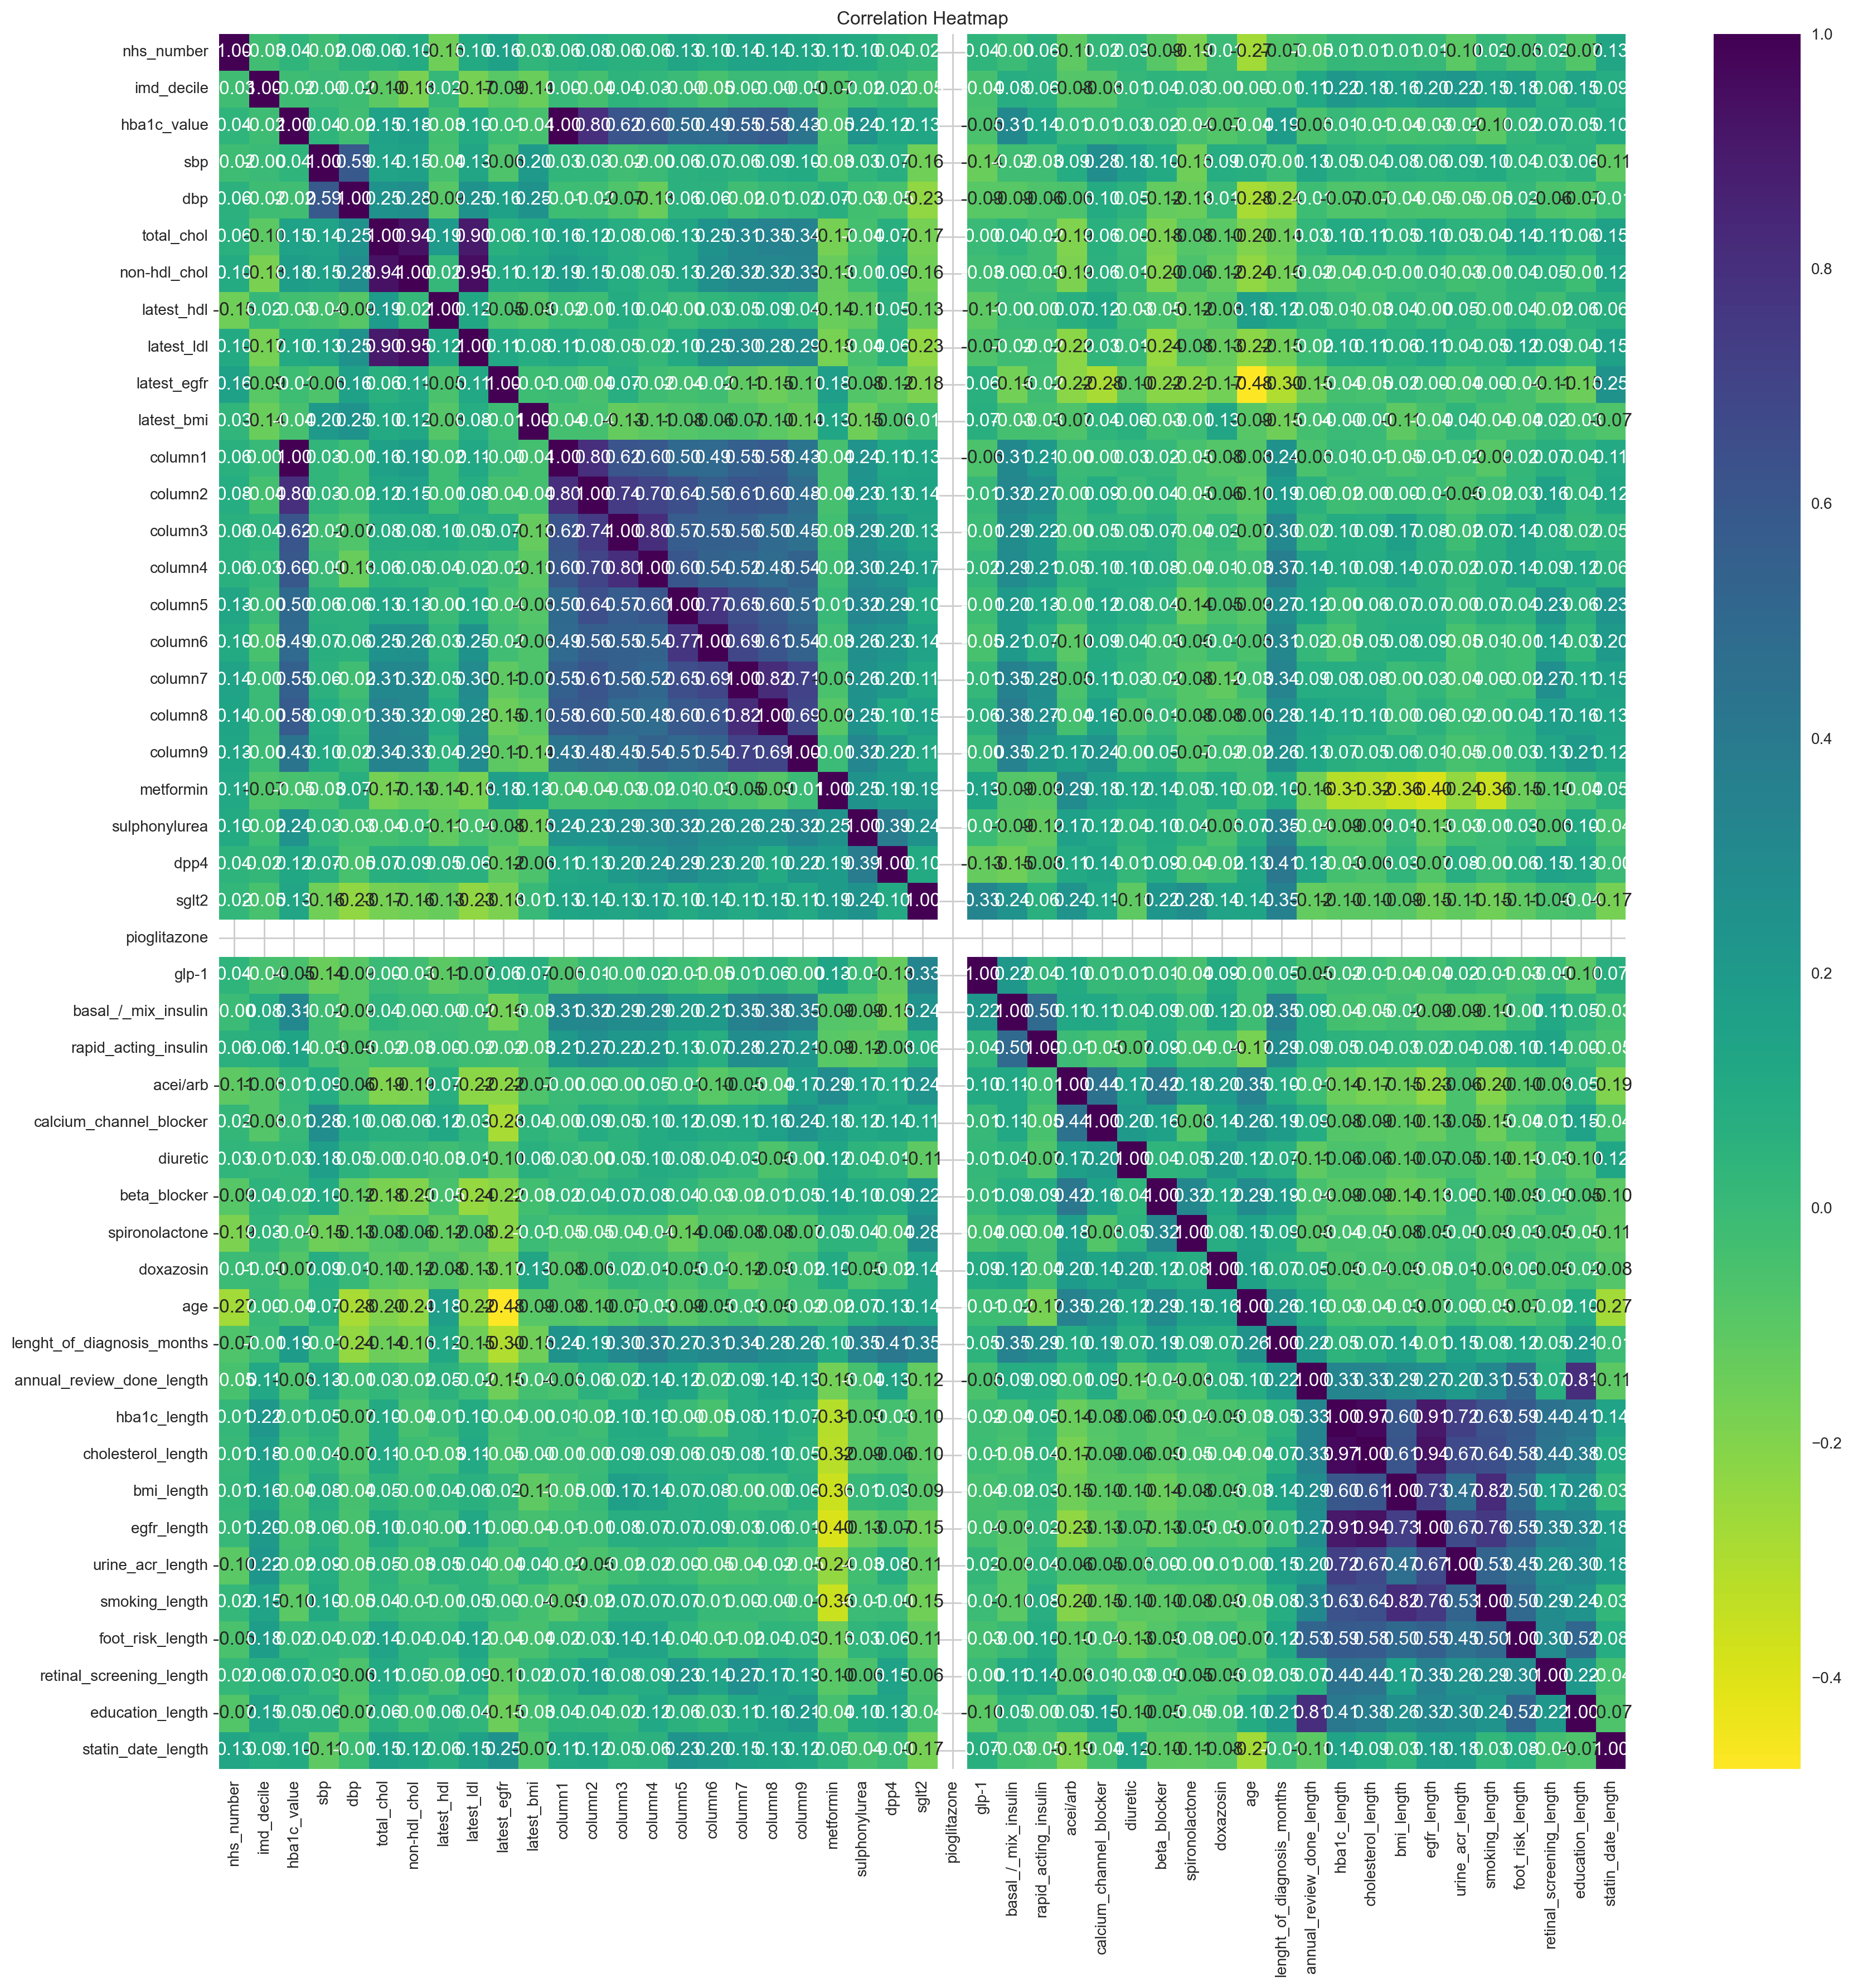

Maximum pairwise correlation: 1.00


In [74]:
correlation_analysis(data, width=18, height=18)

In [75]:
eda1()

In [76]:
eda0()

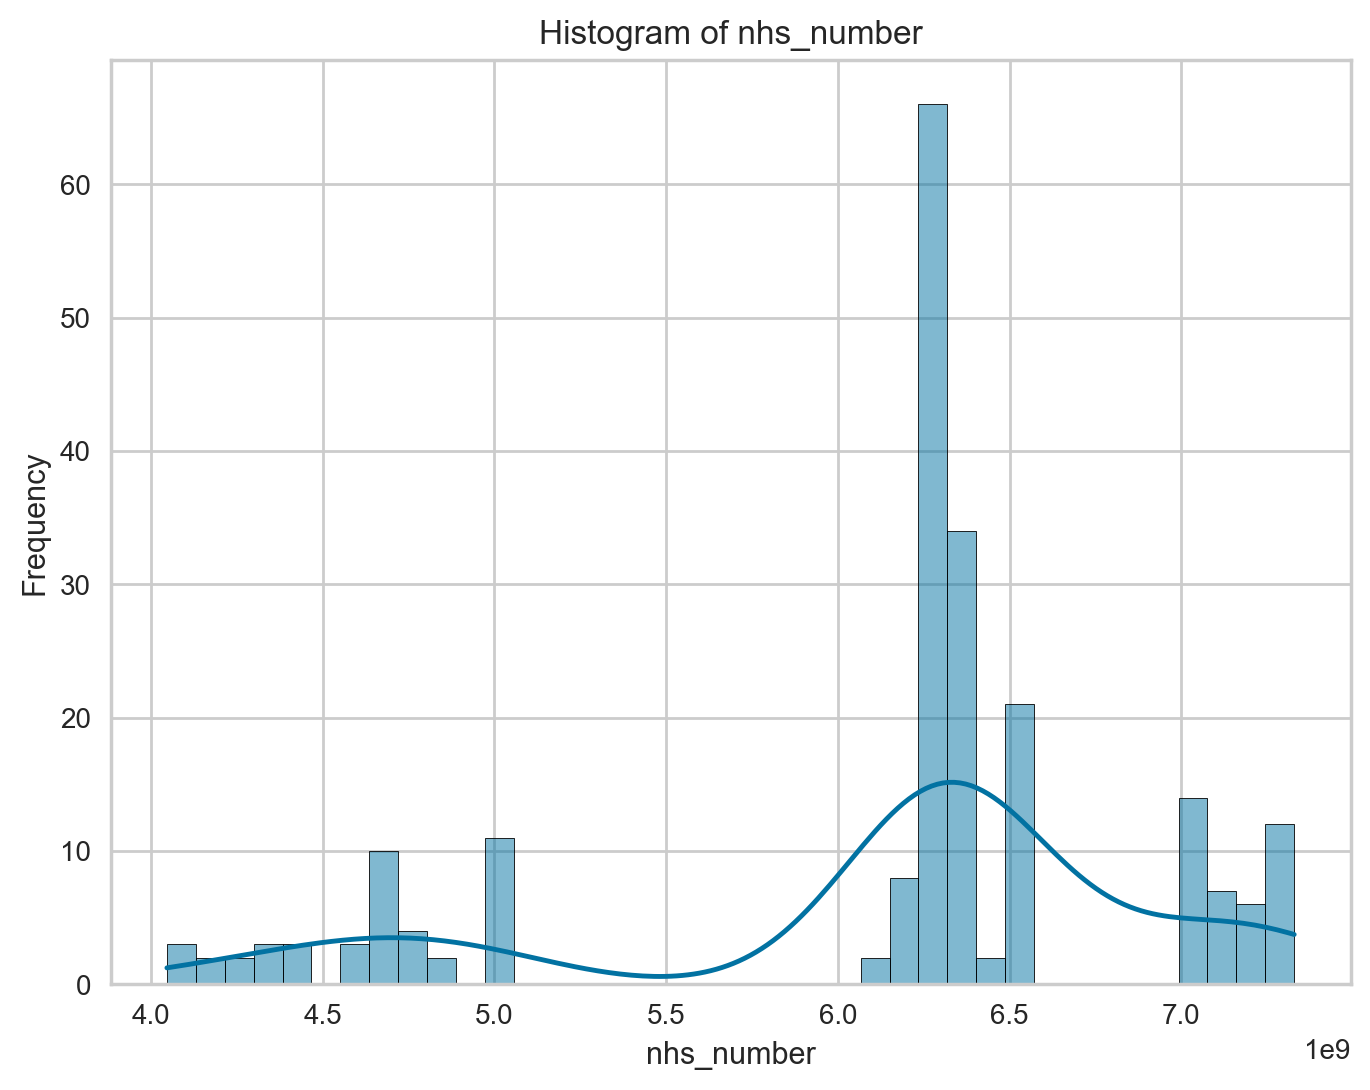

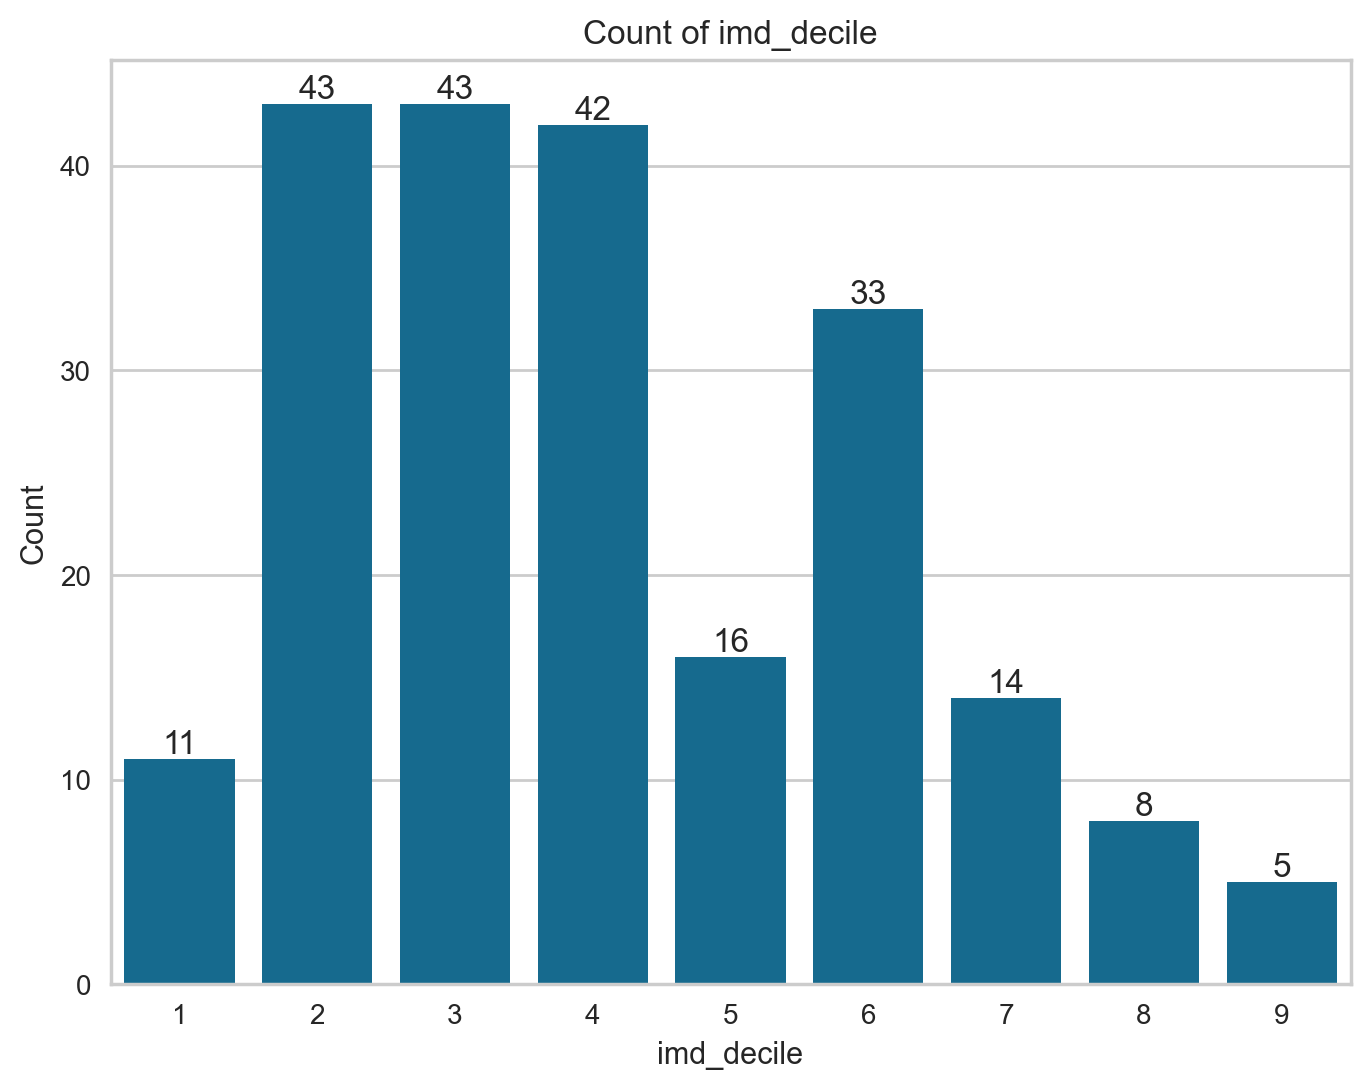

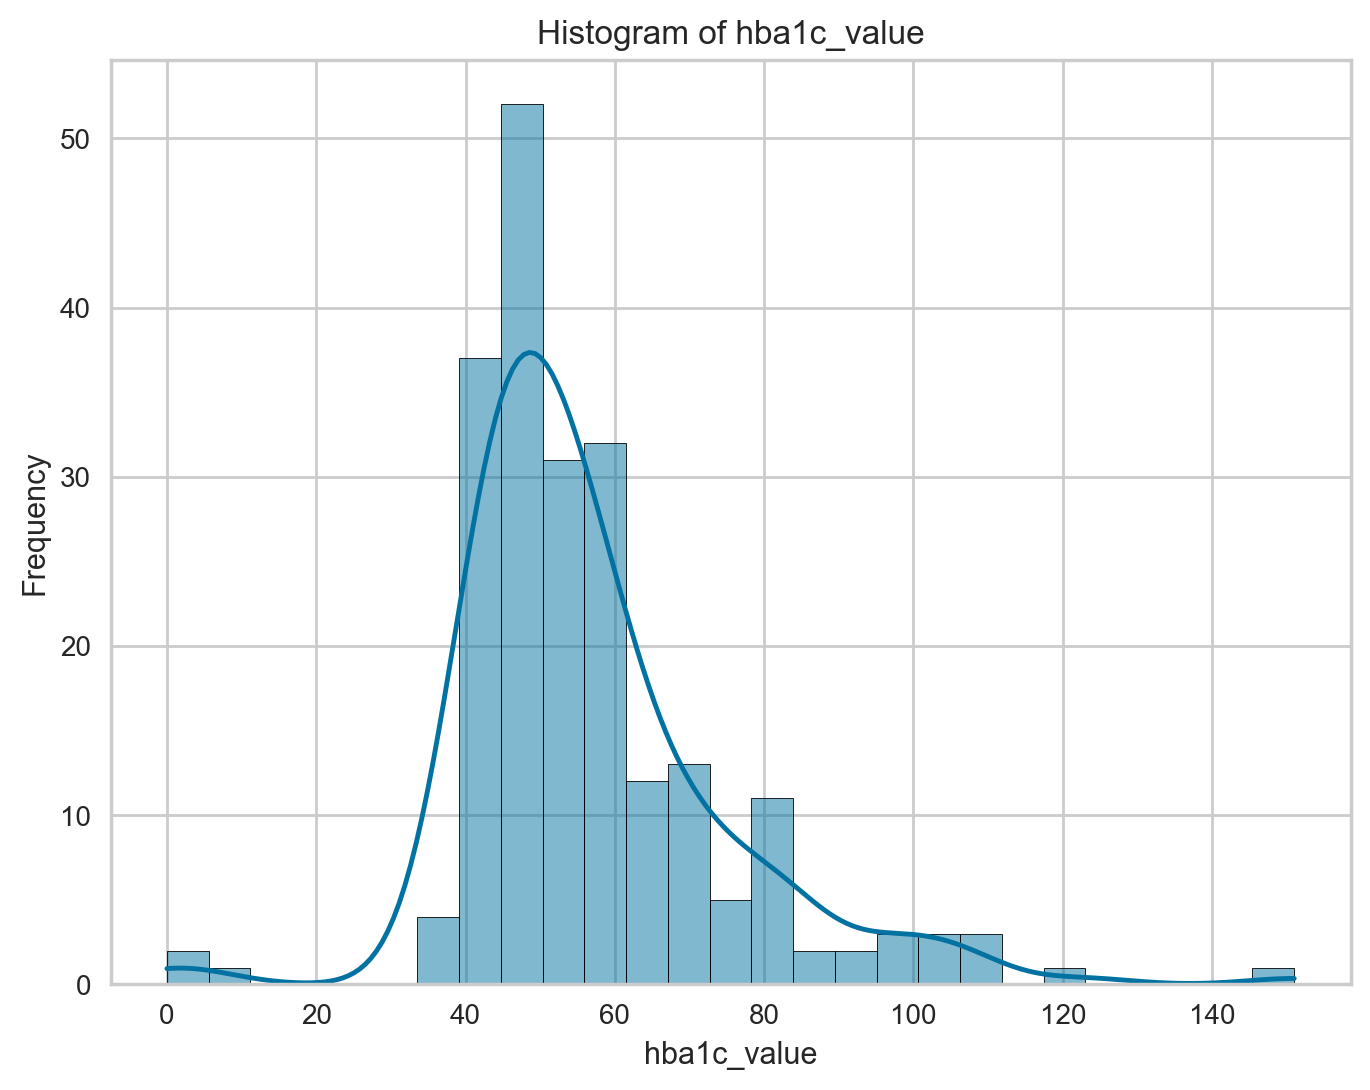

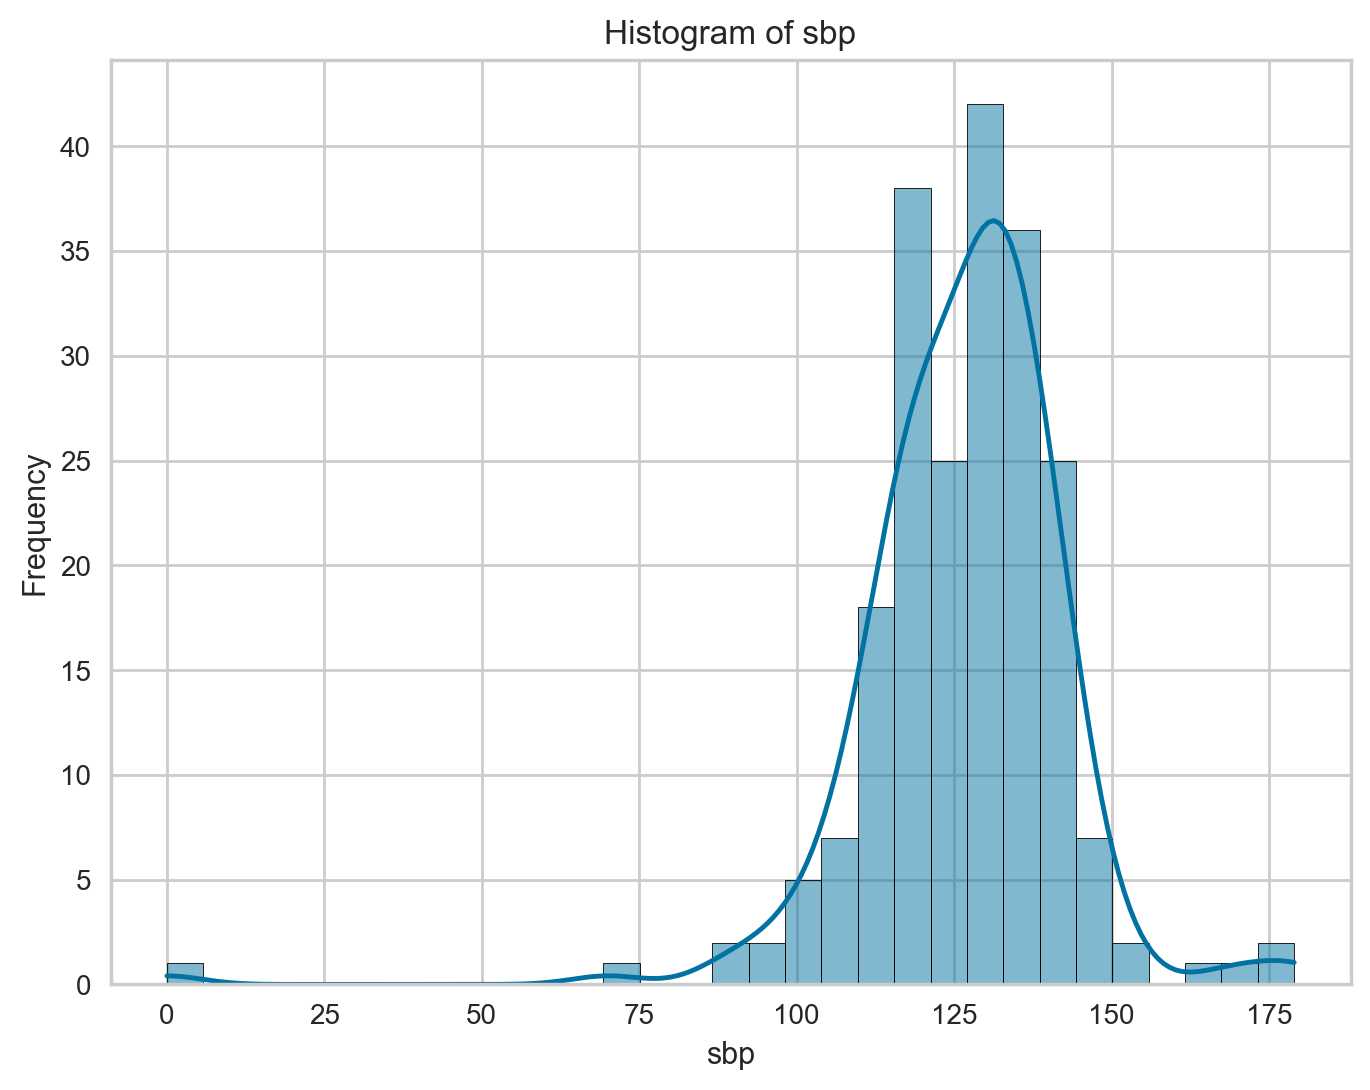

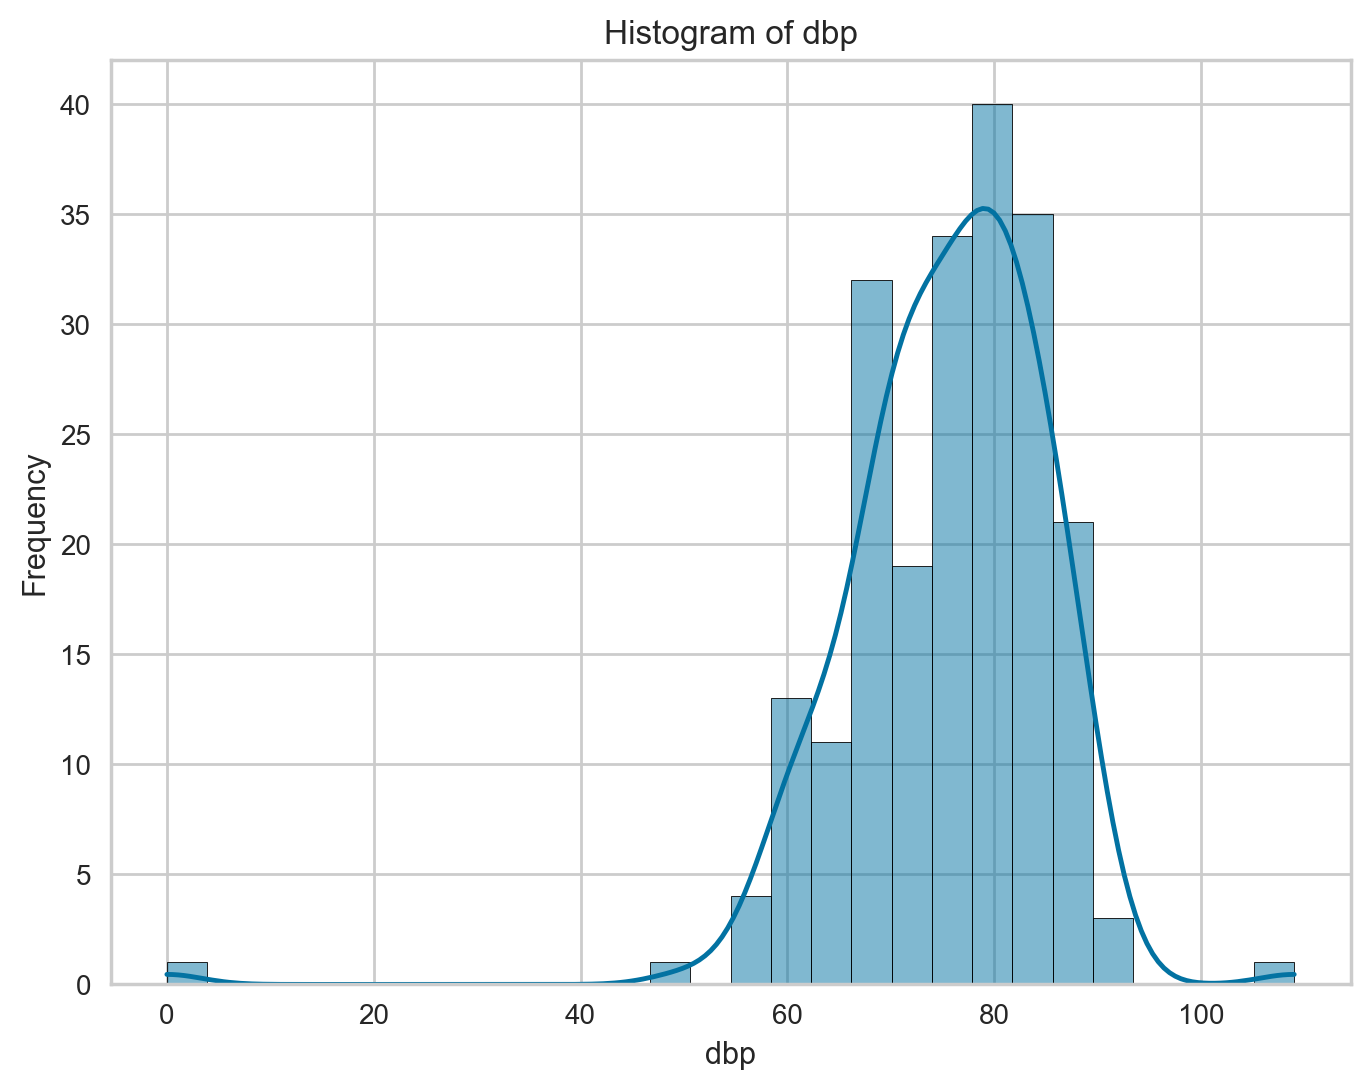

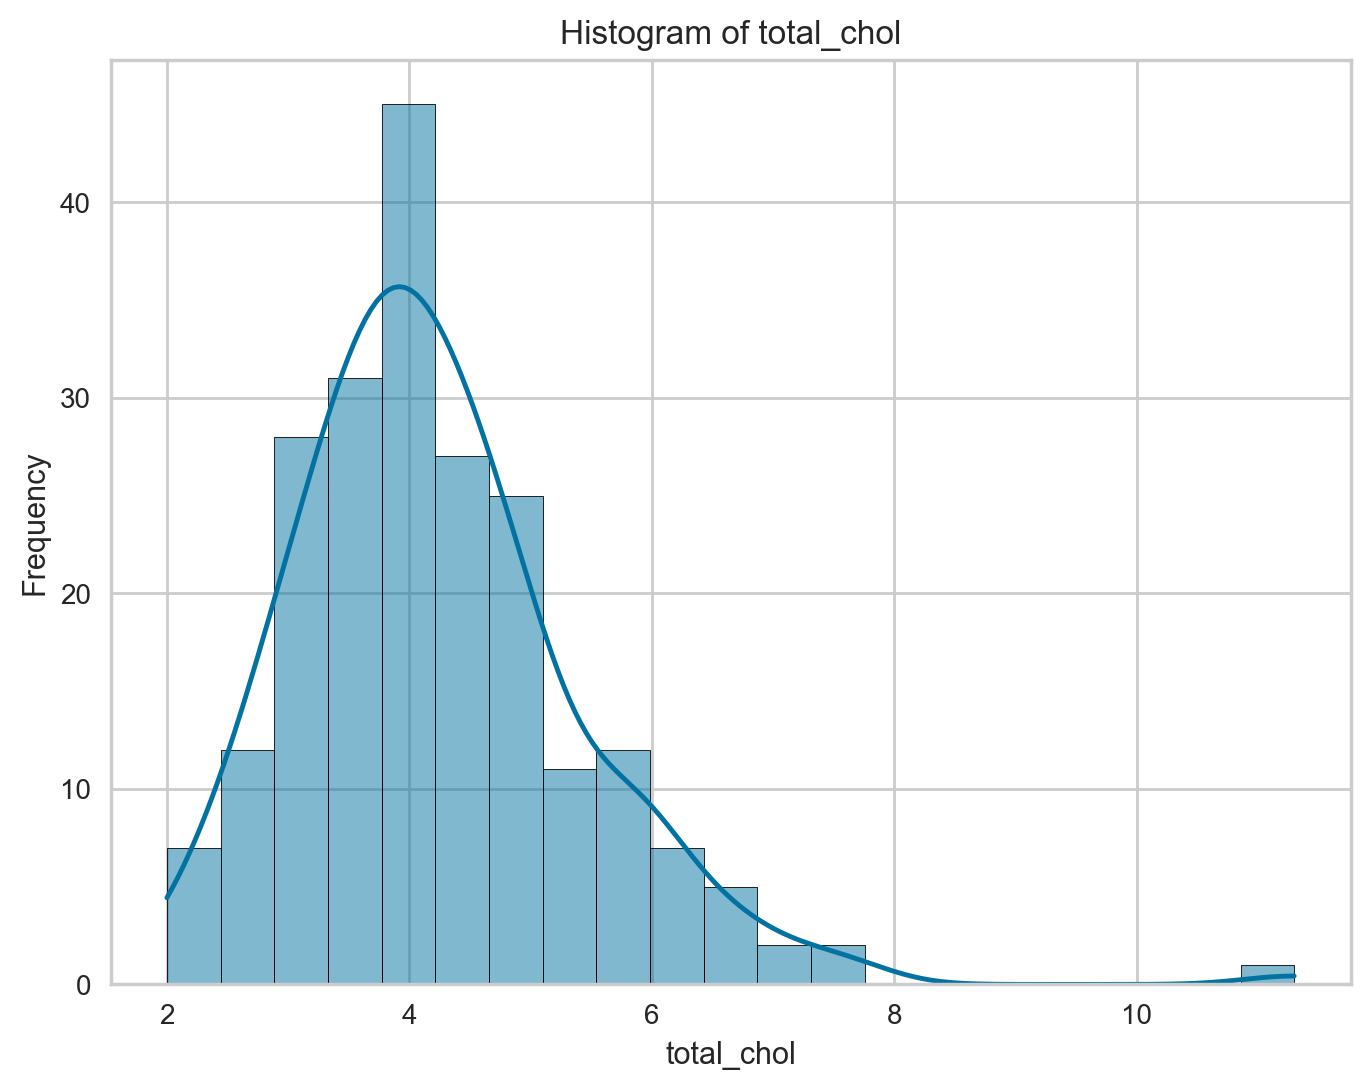

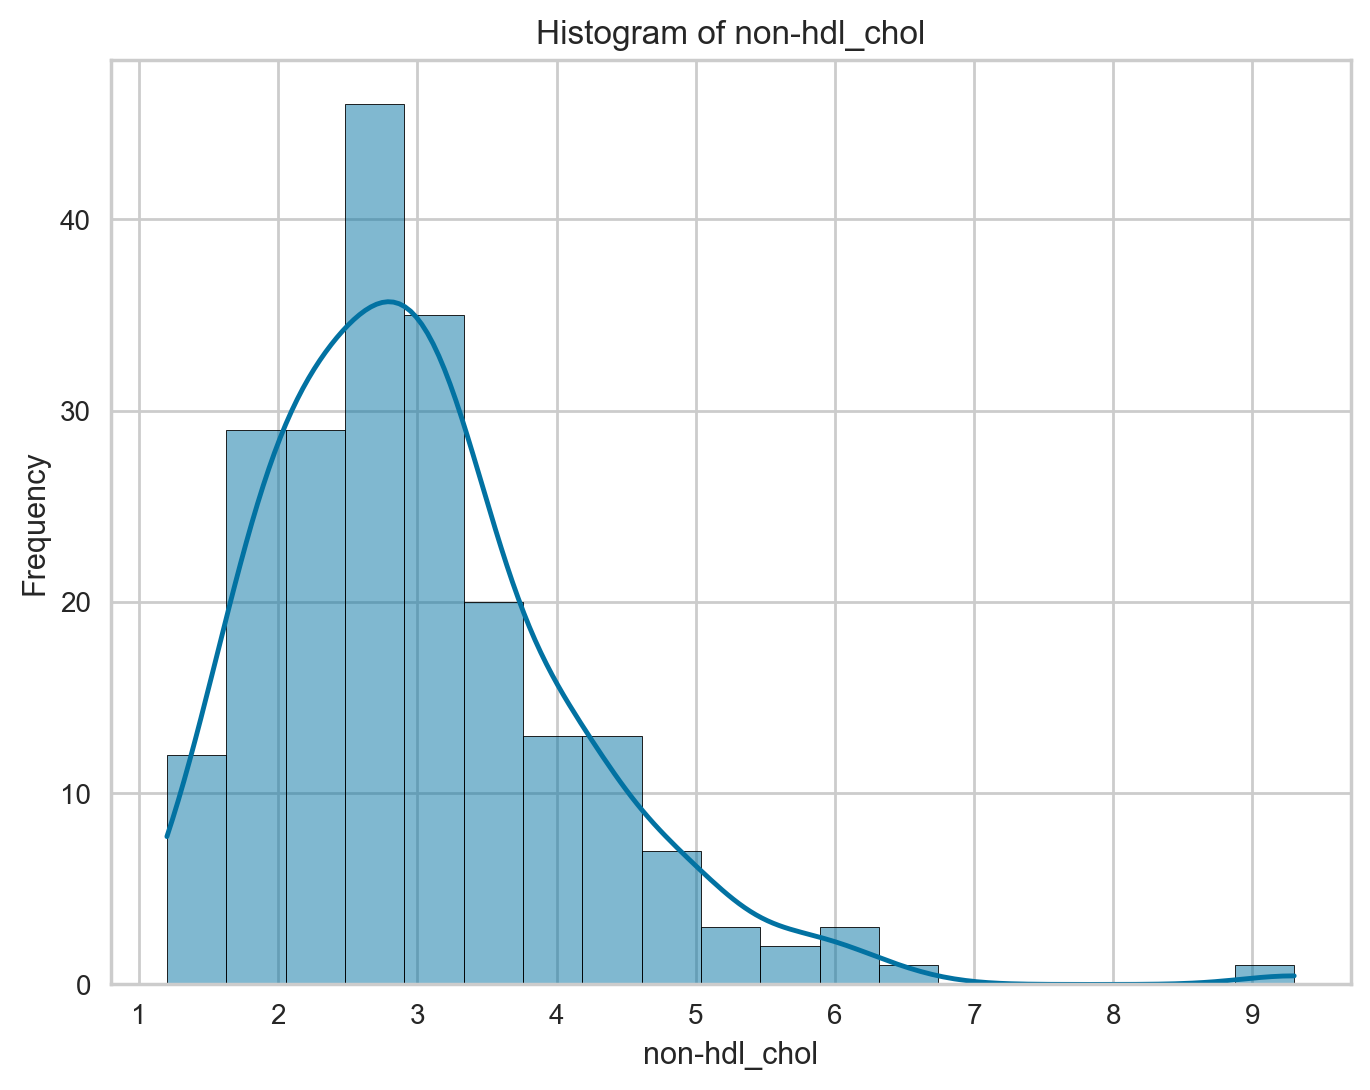

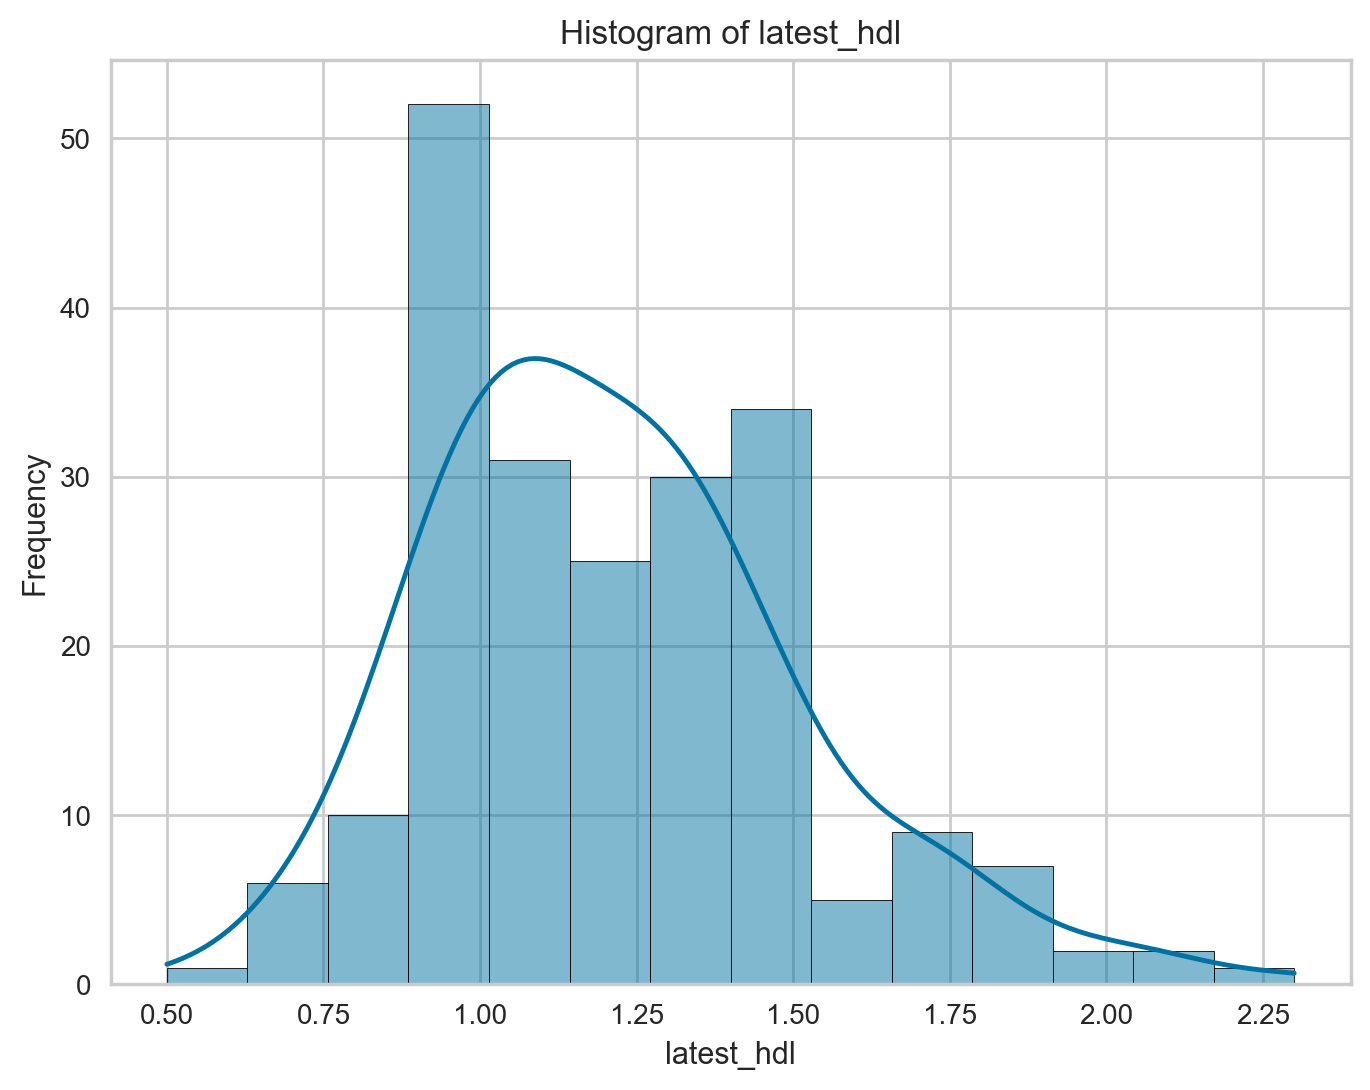

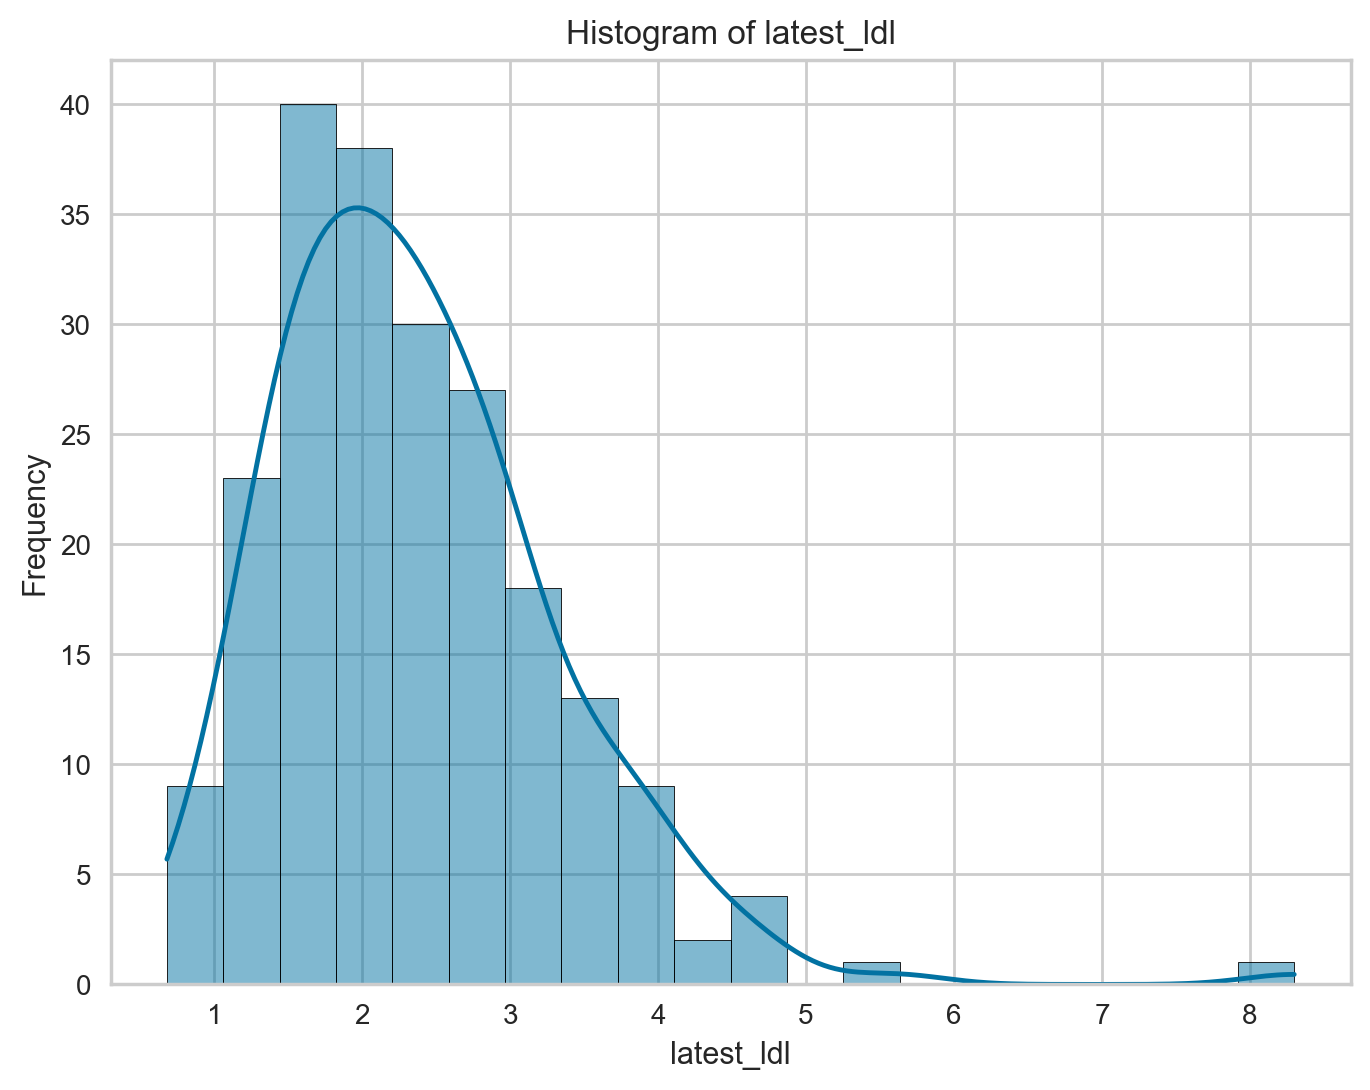

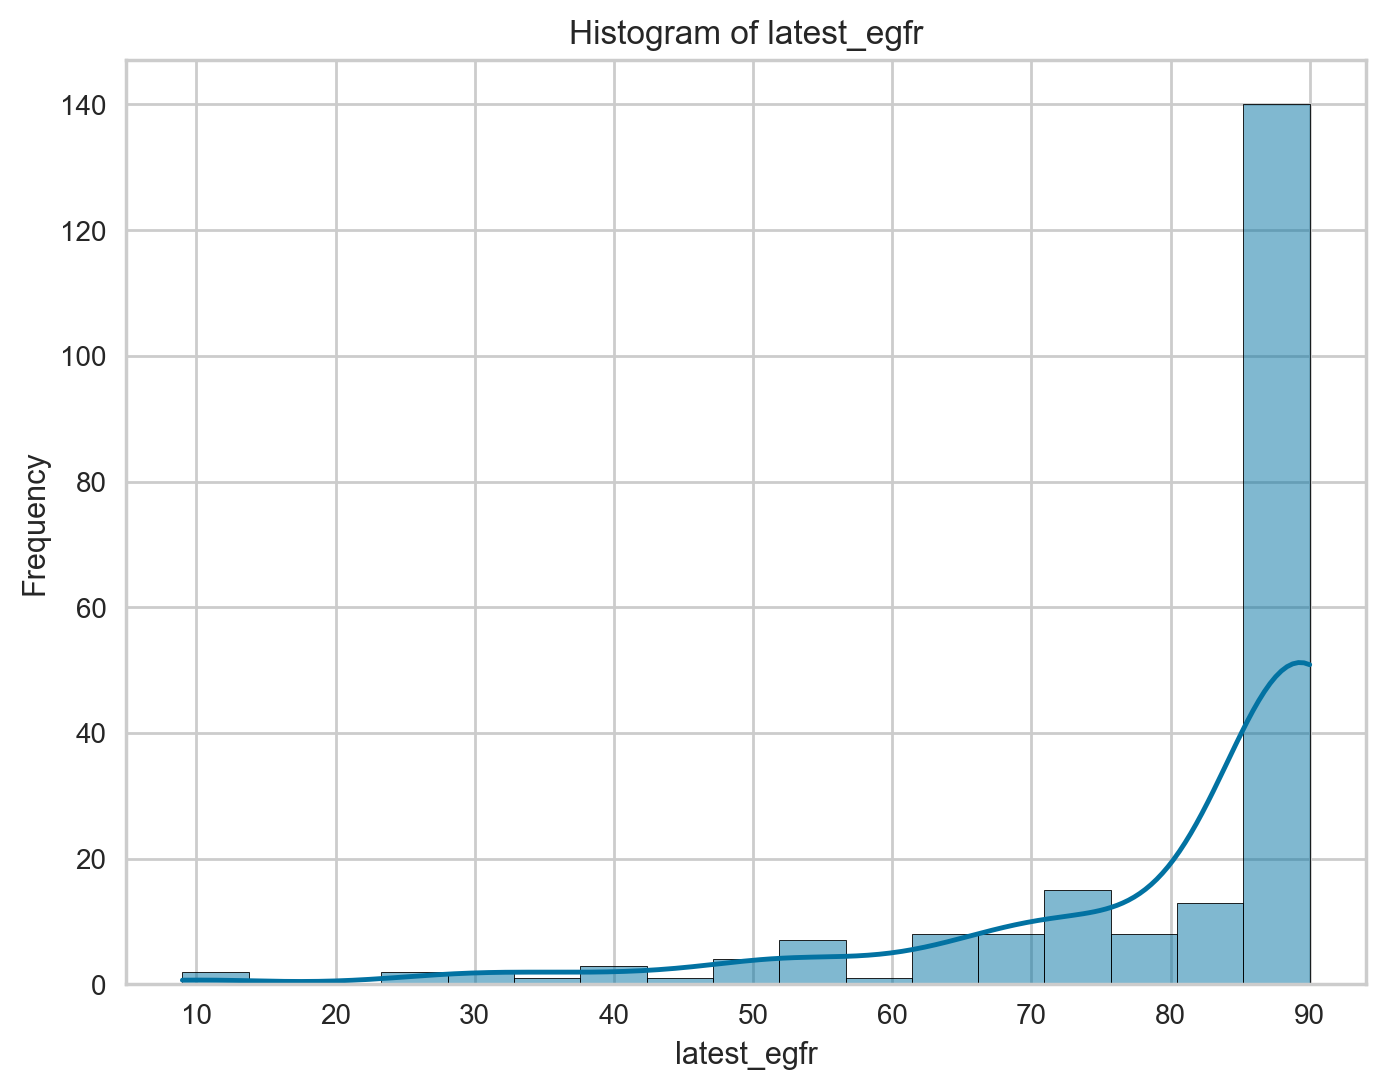

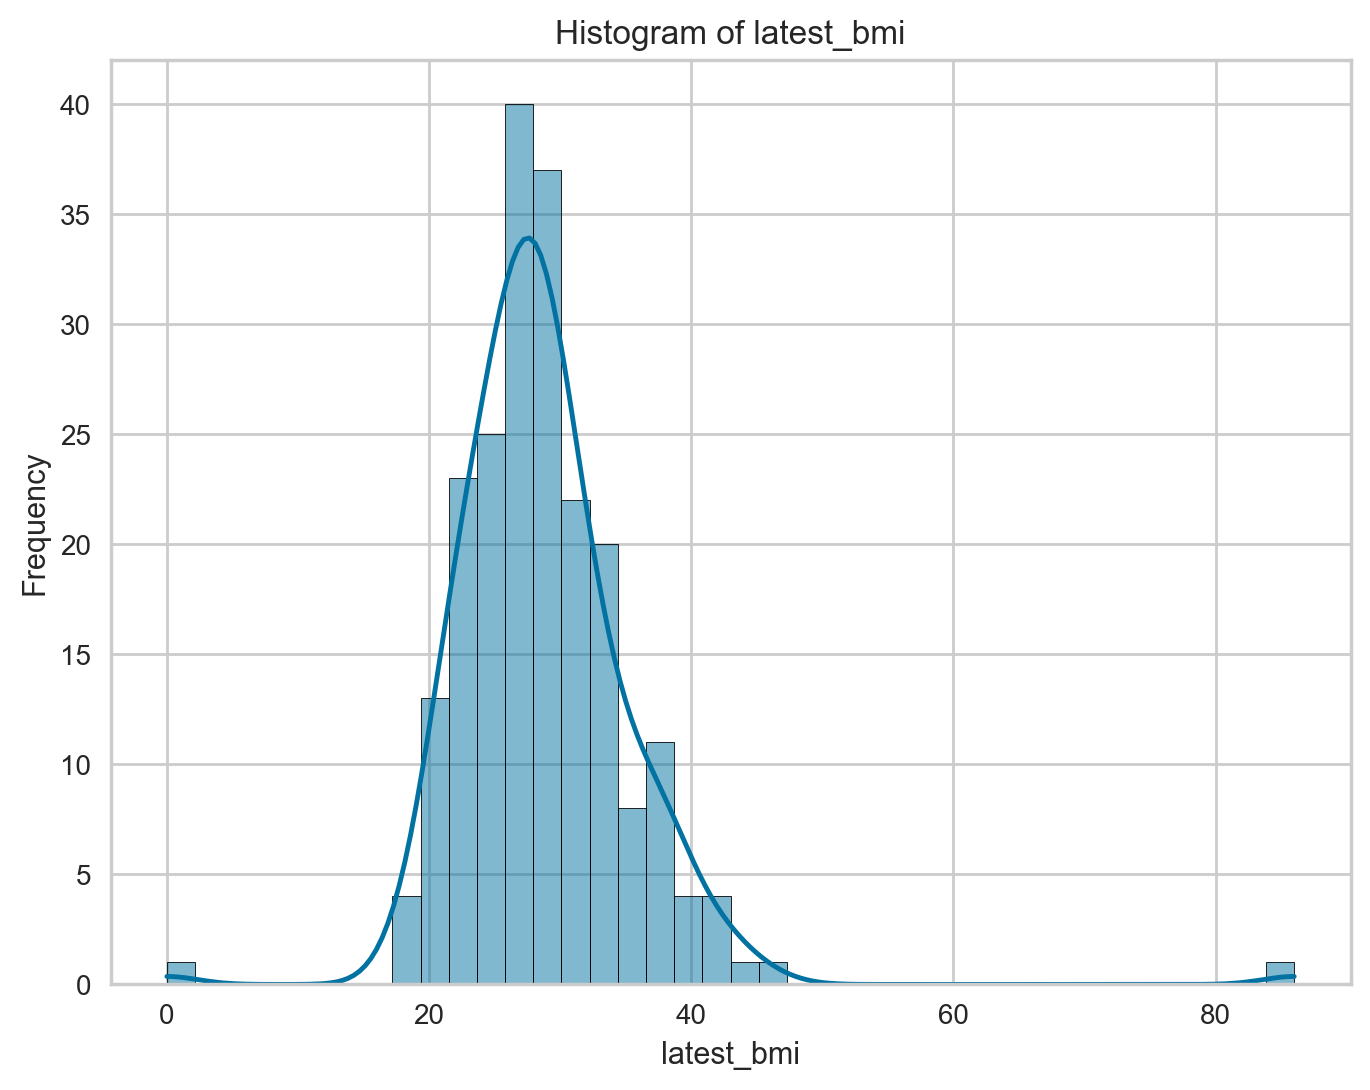

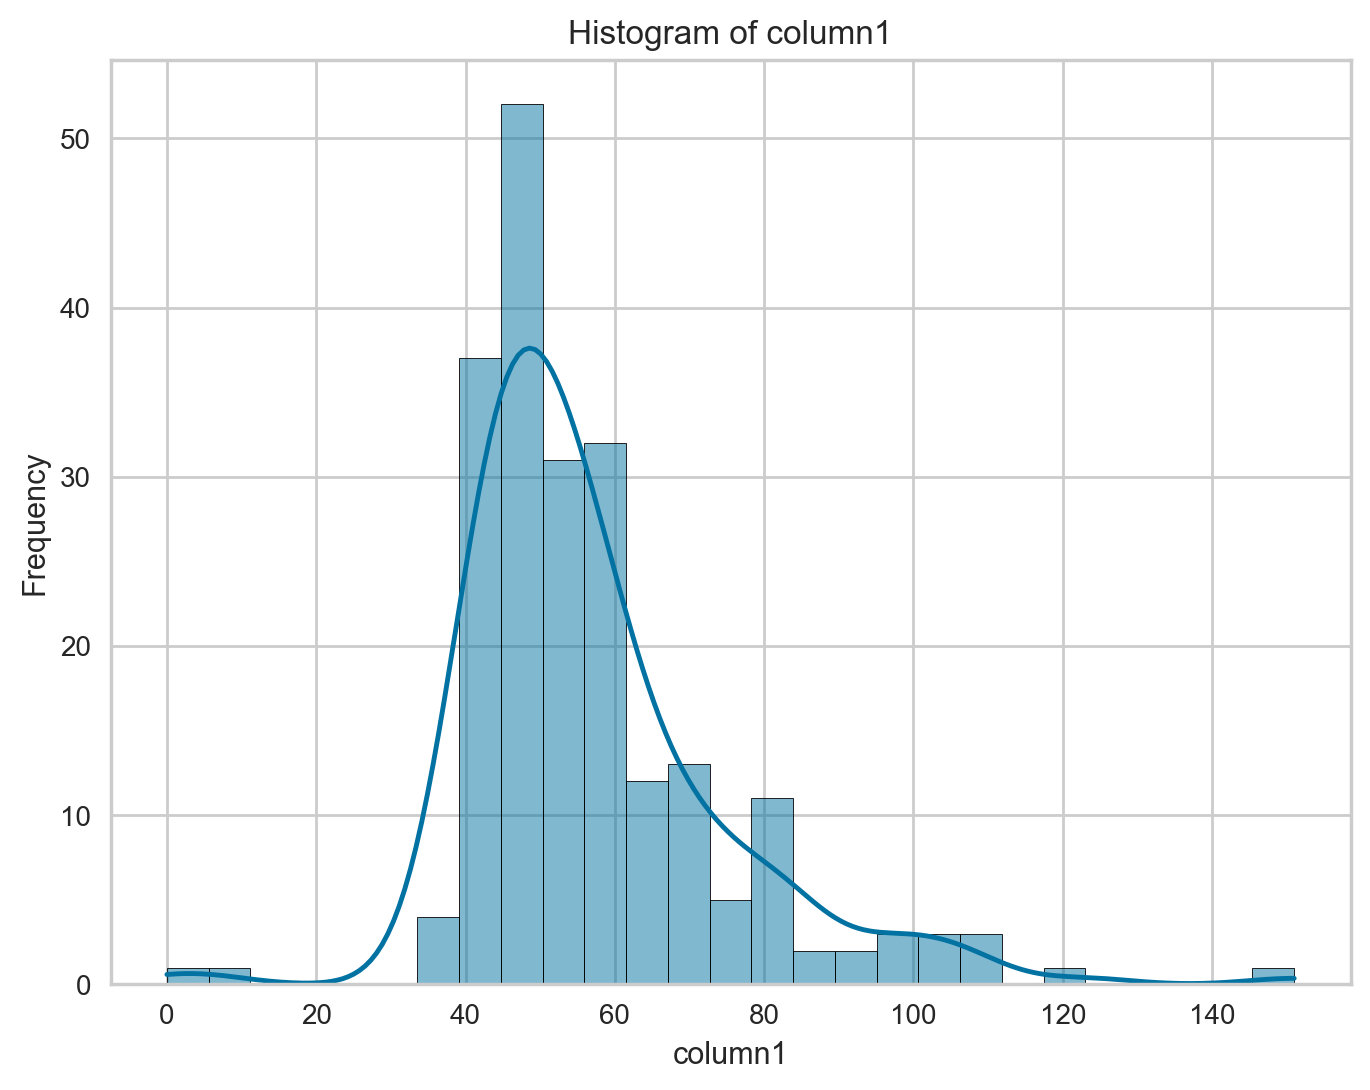

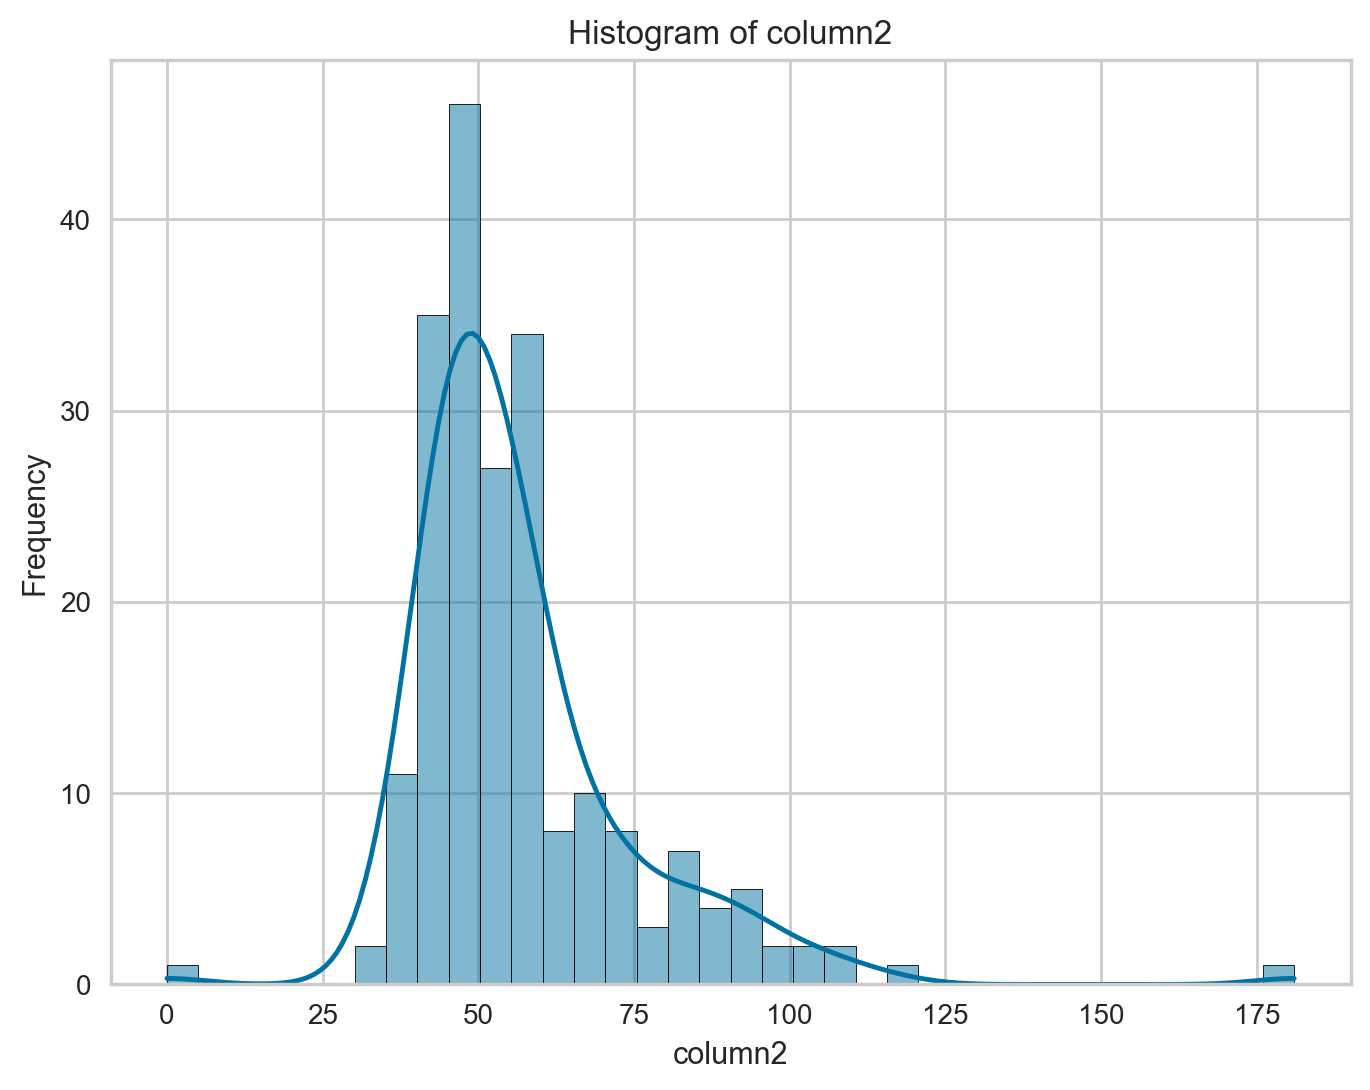

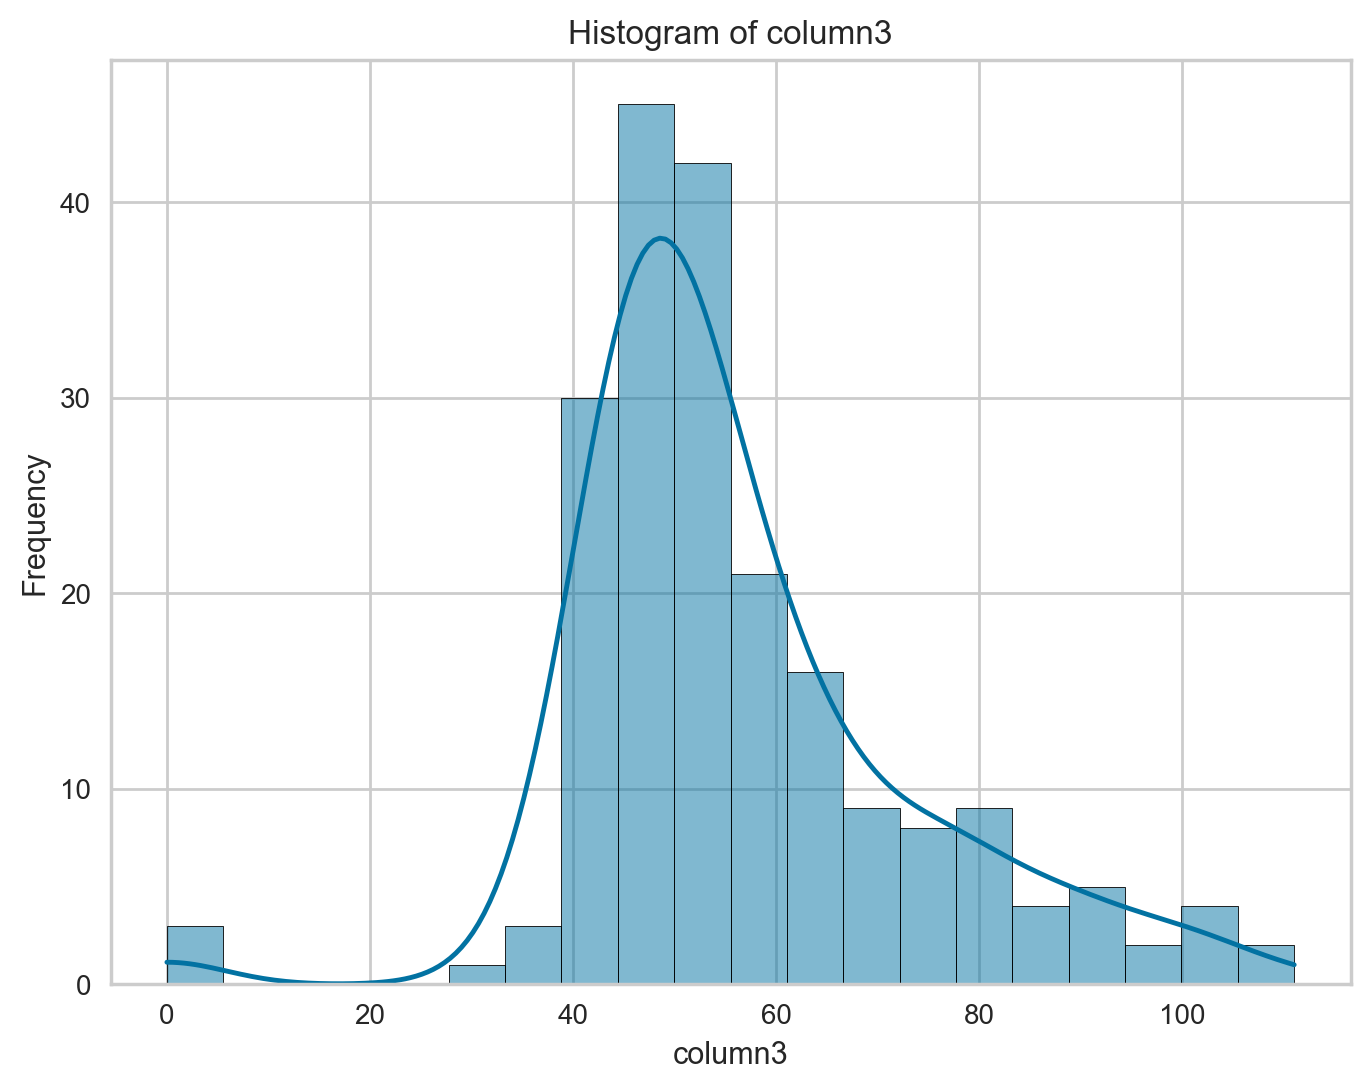

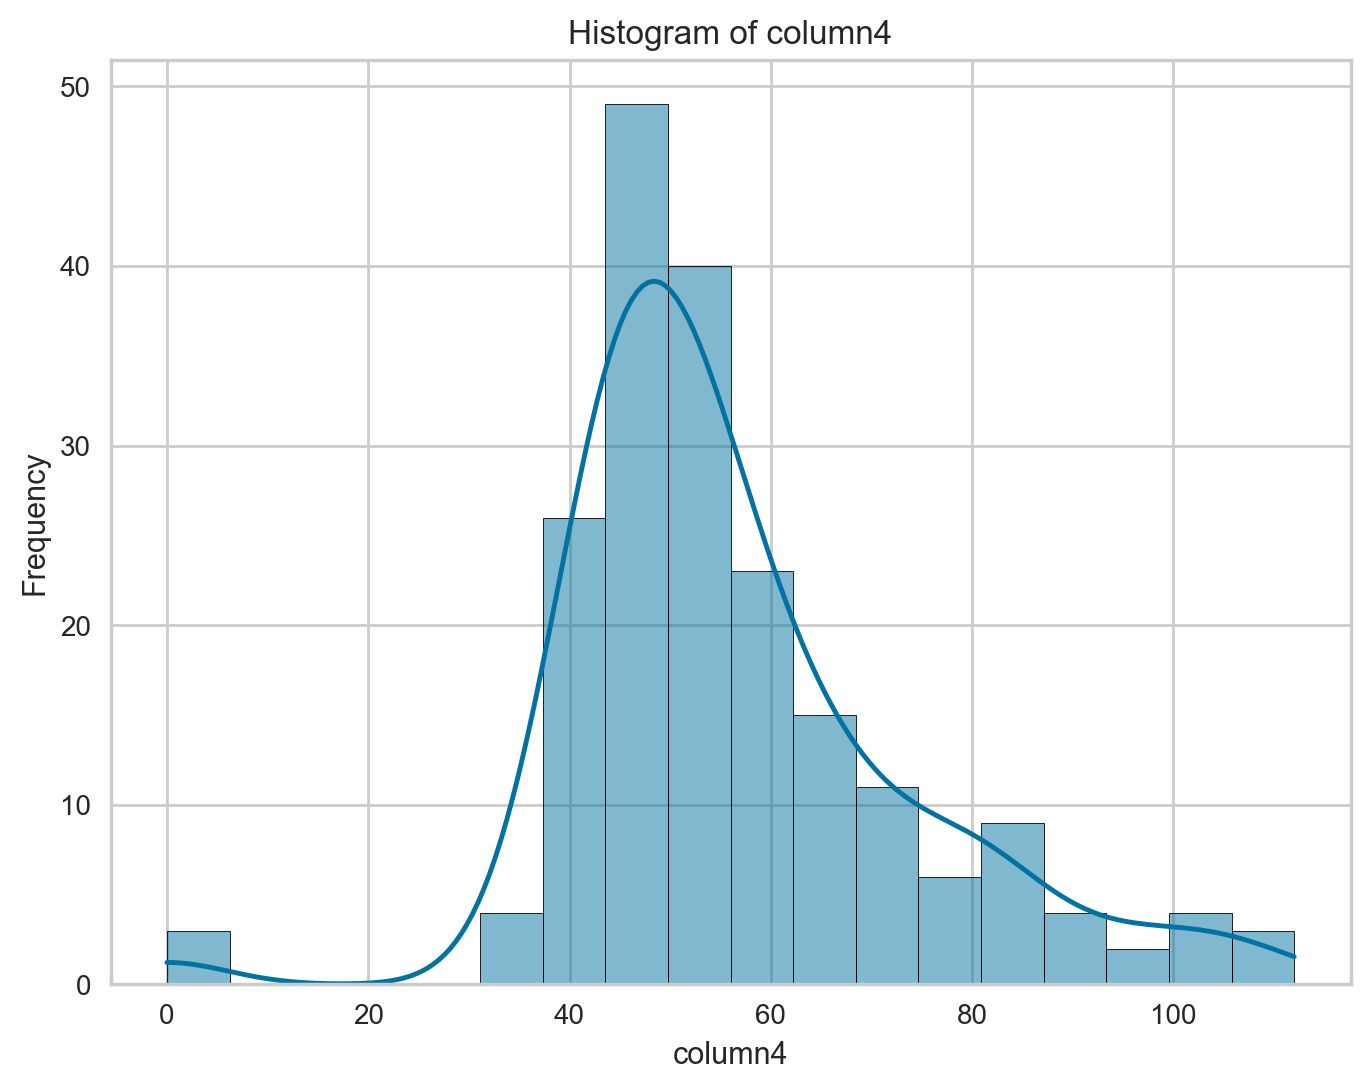

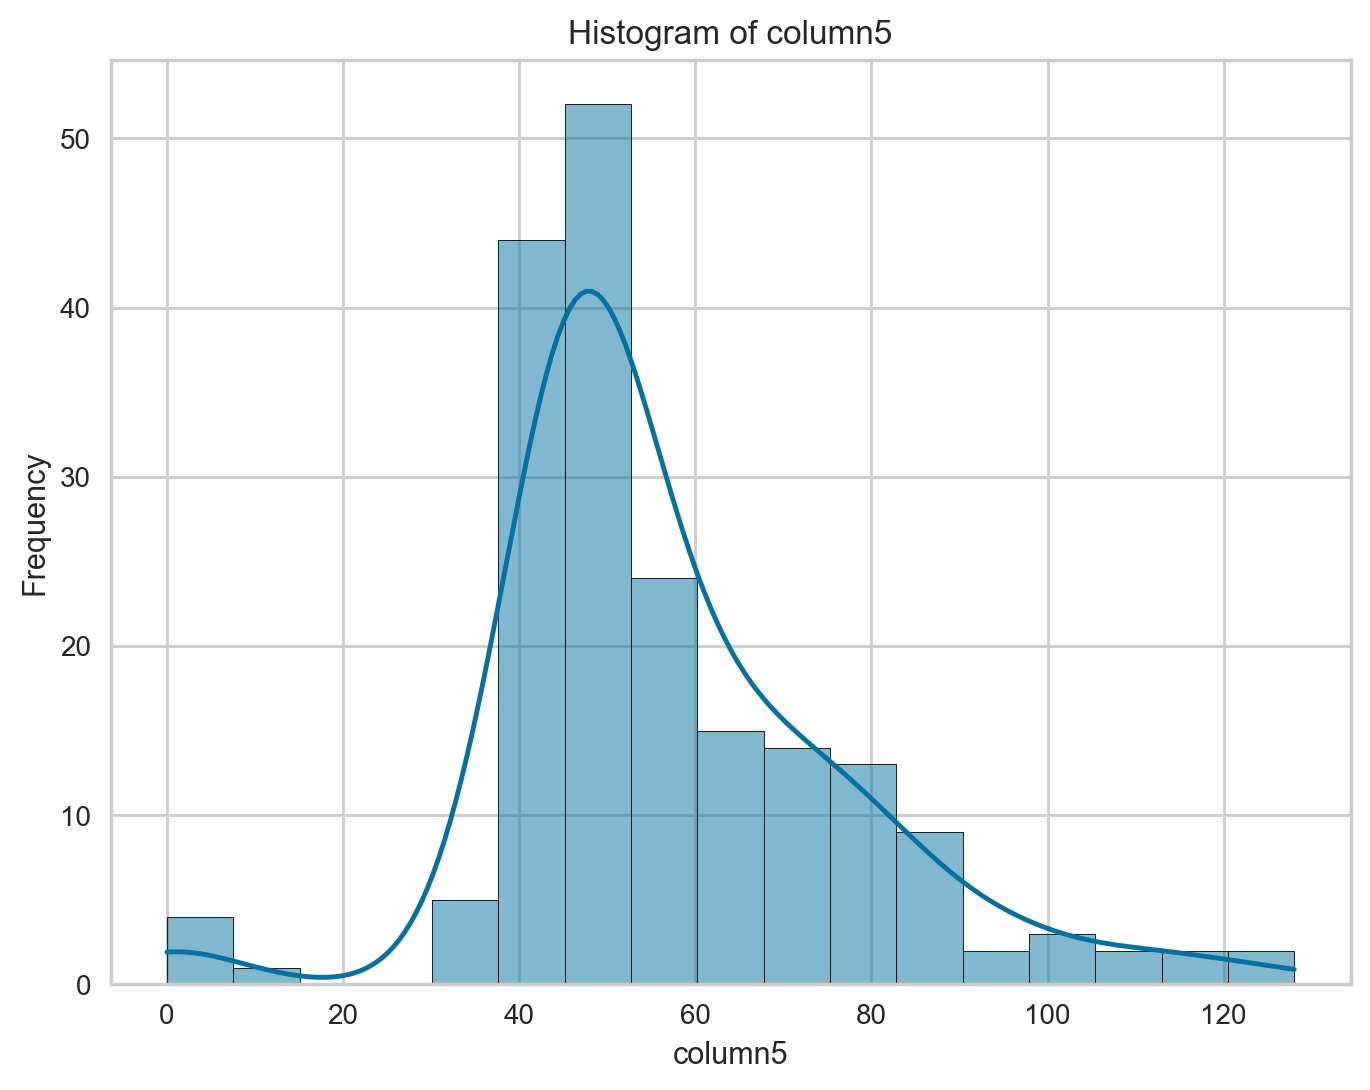

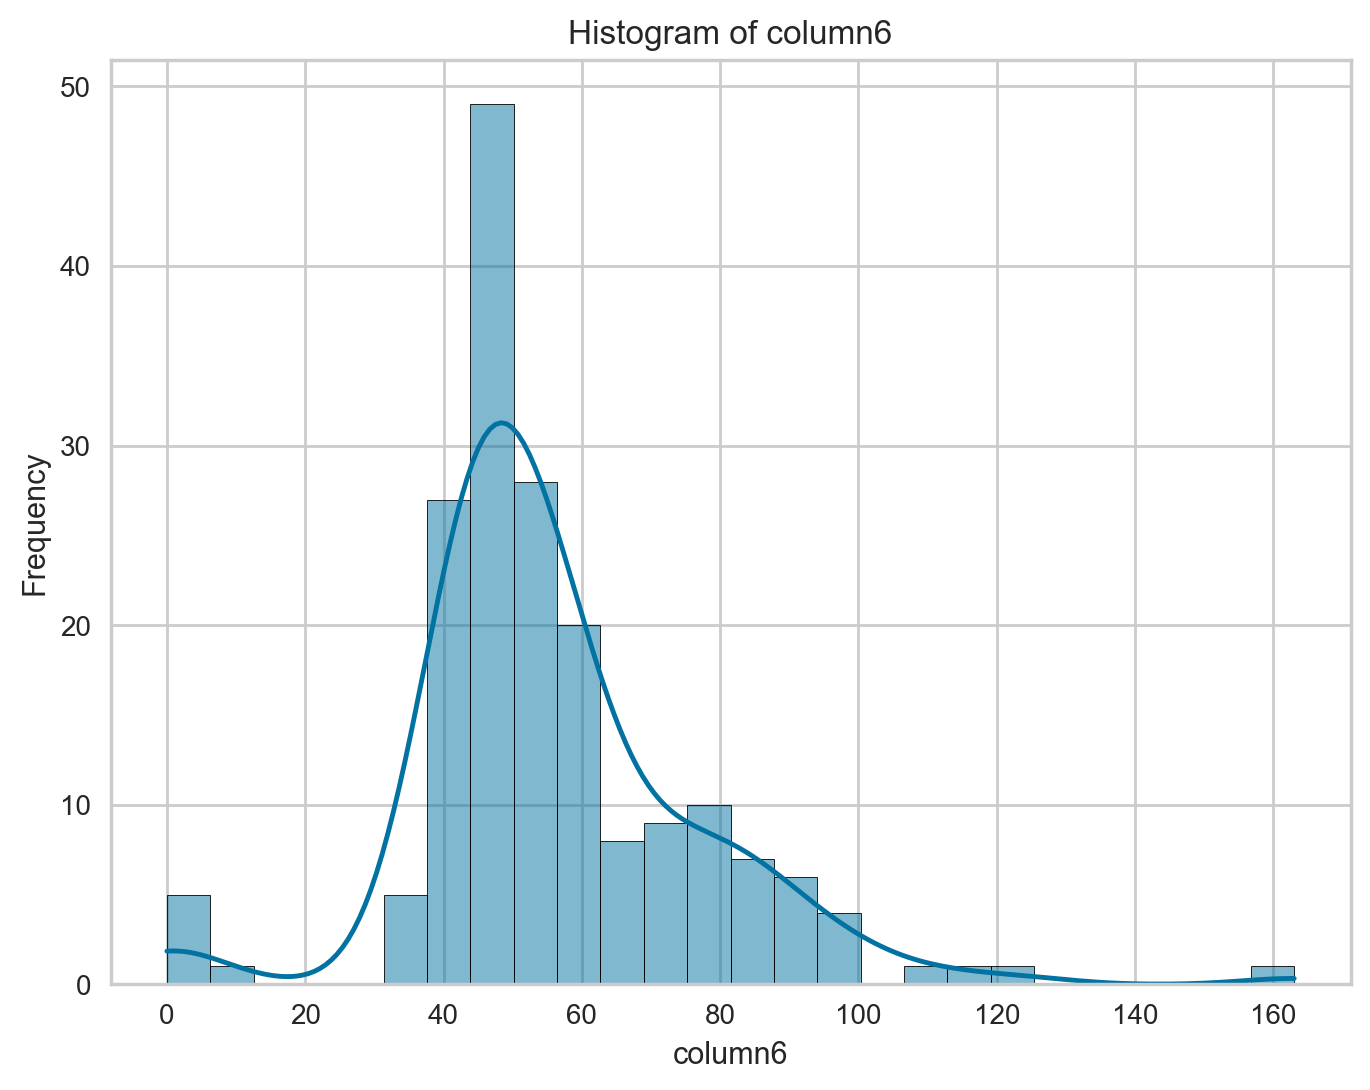

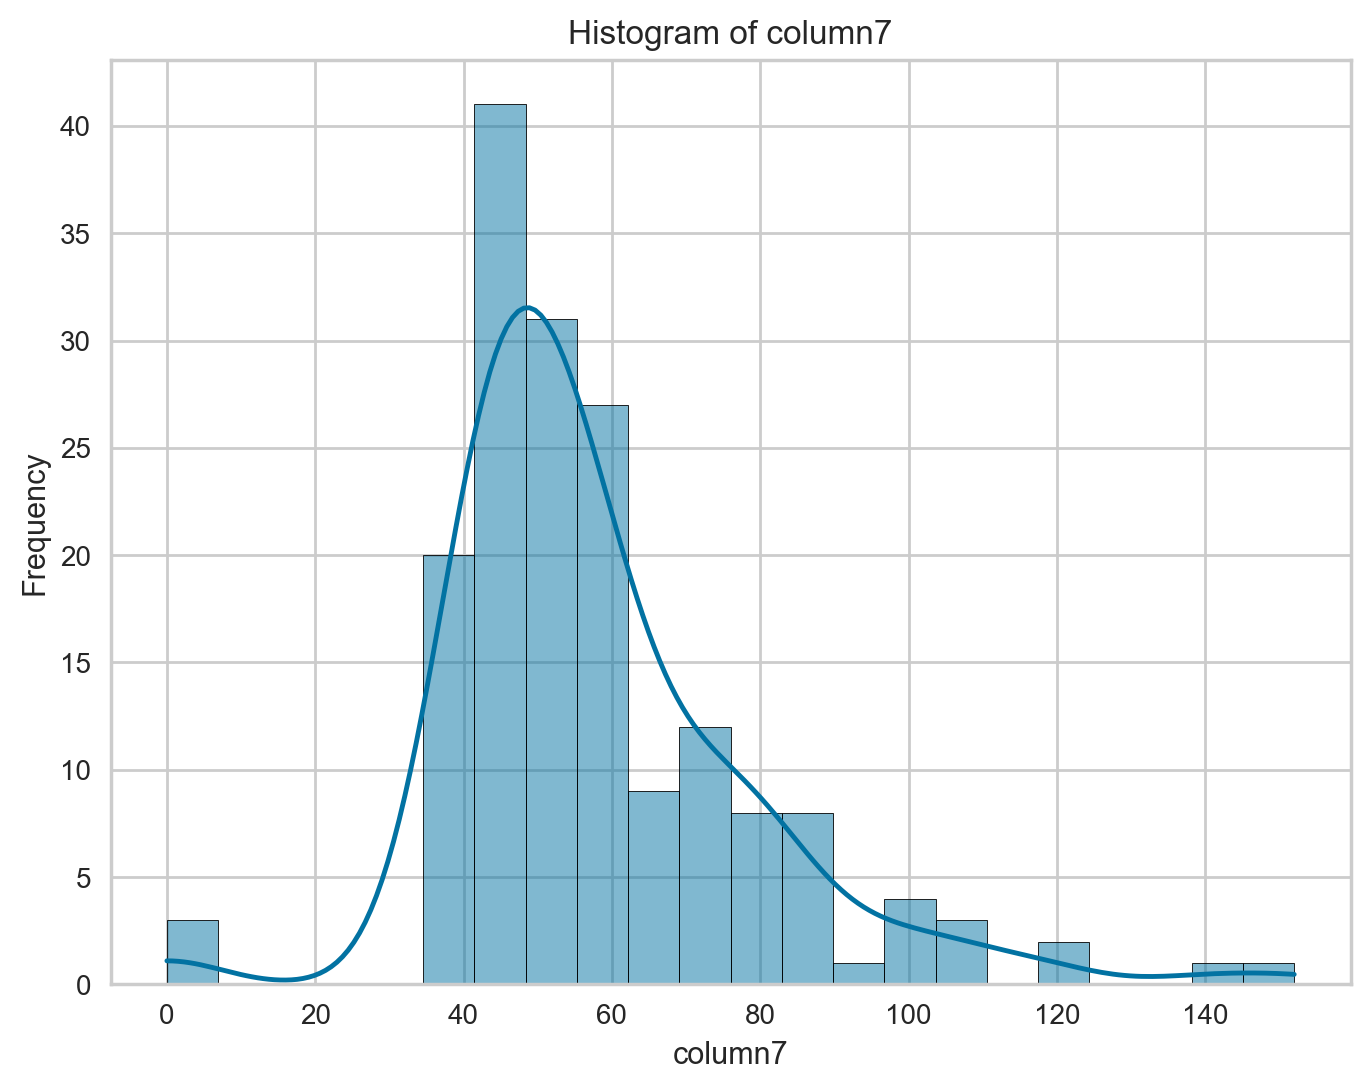

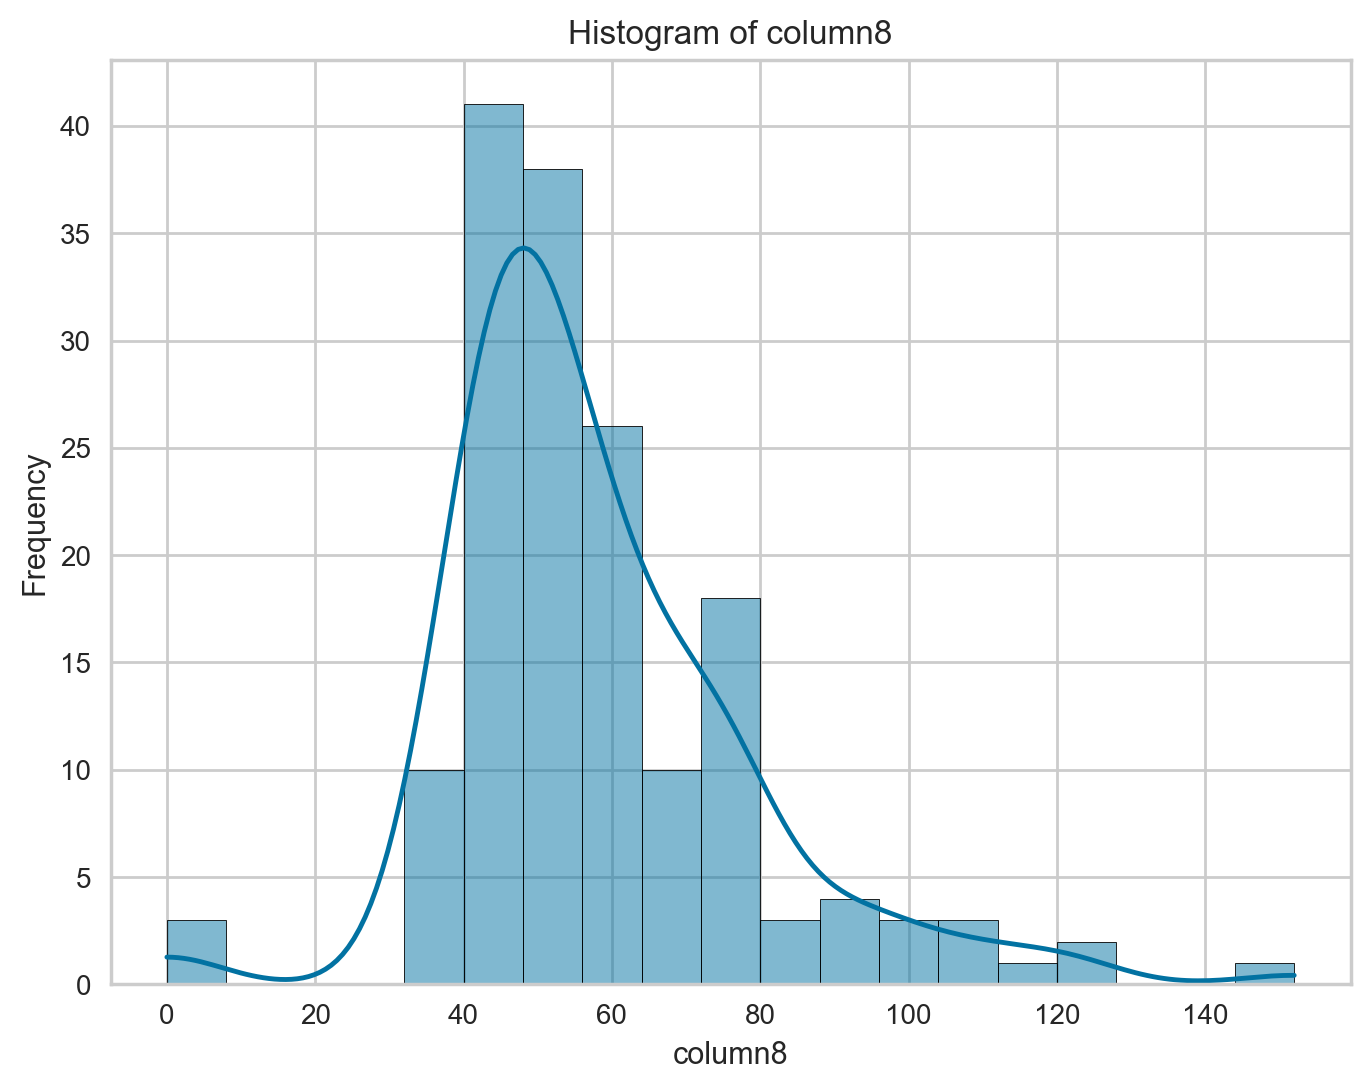

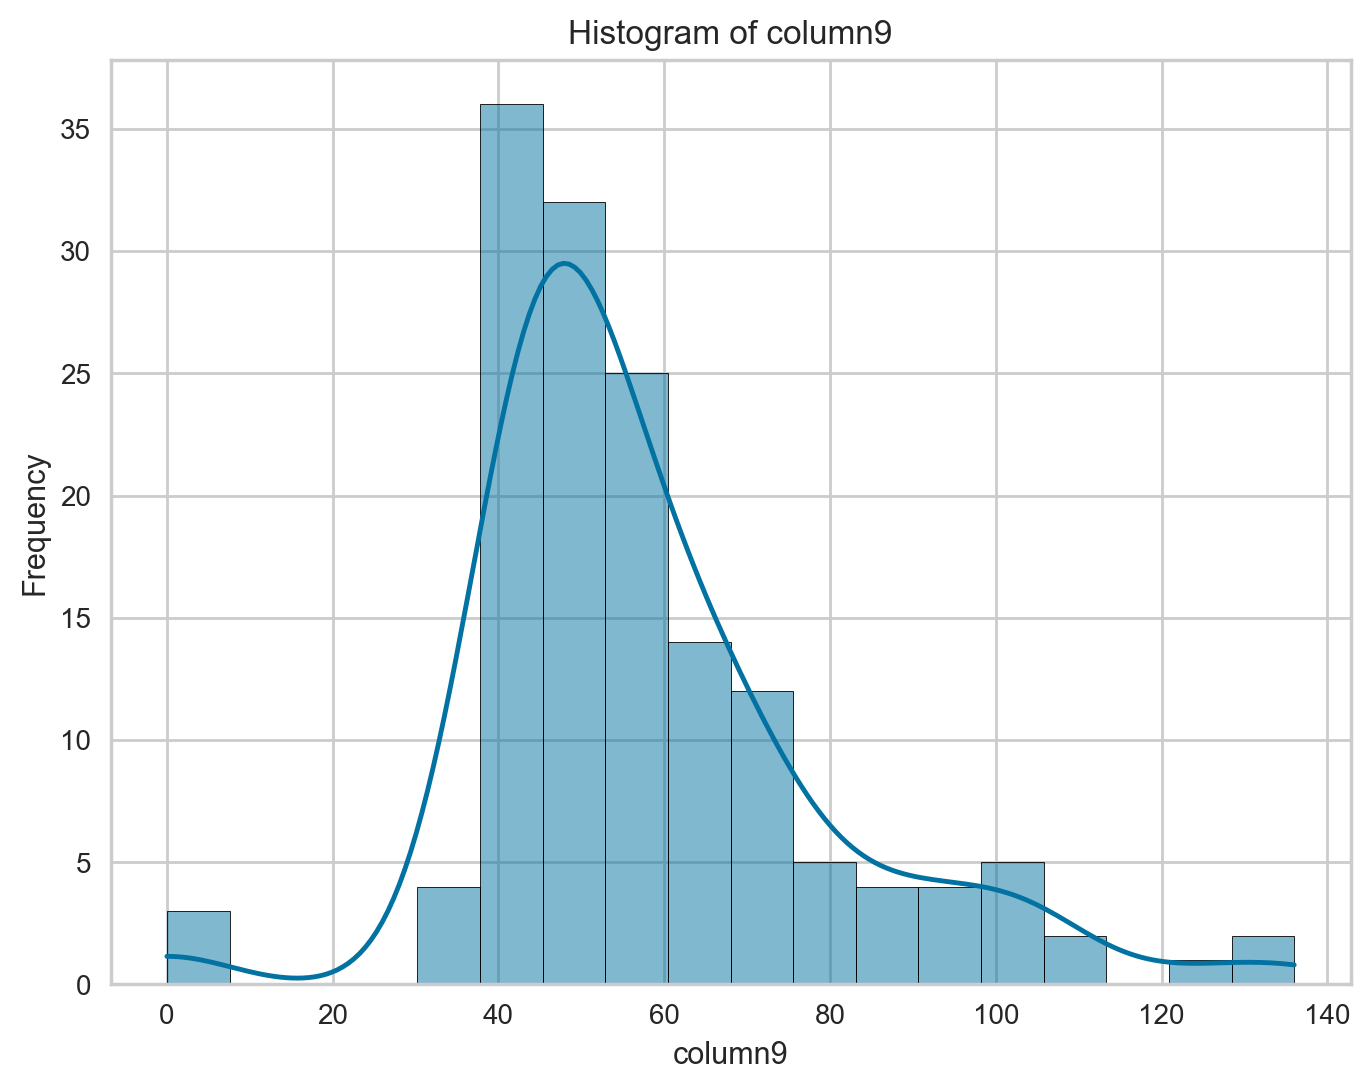

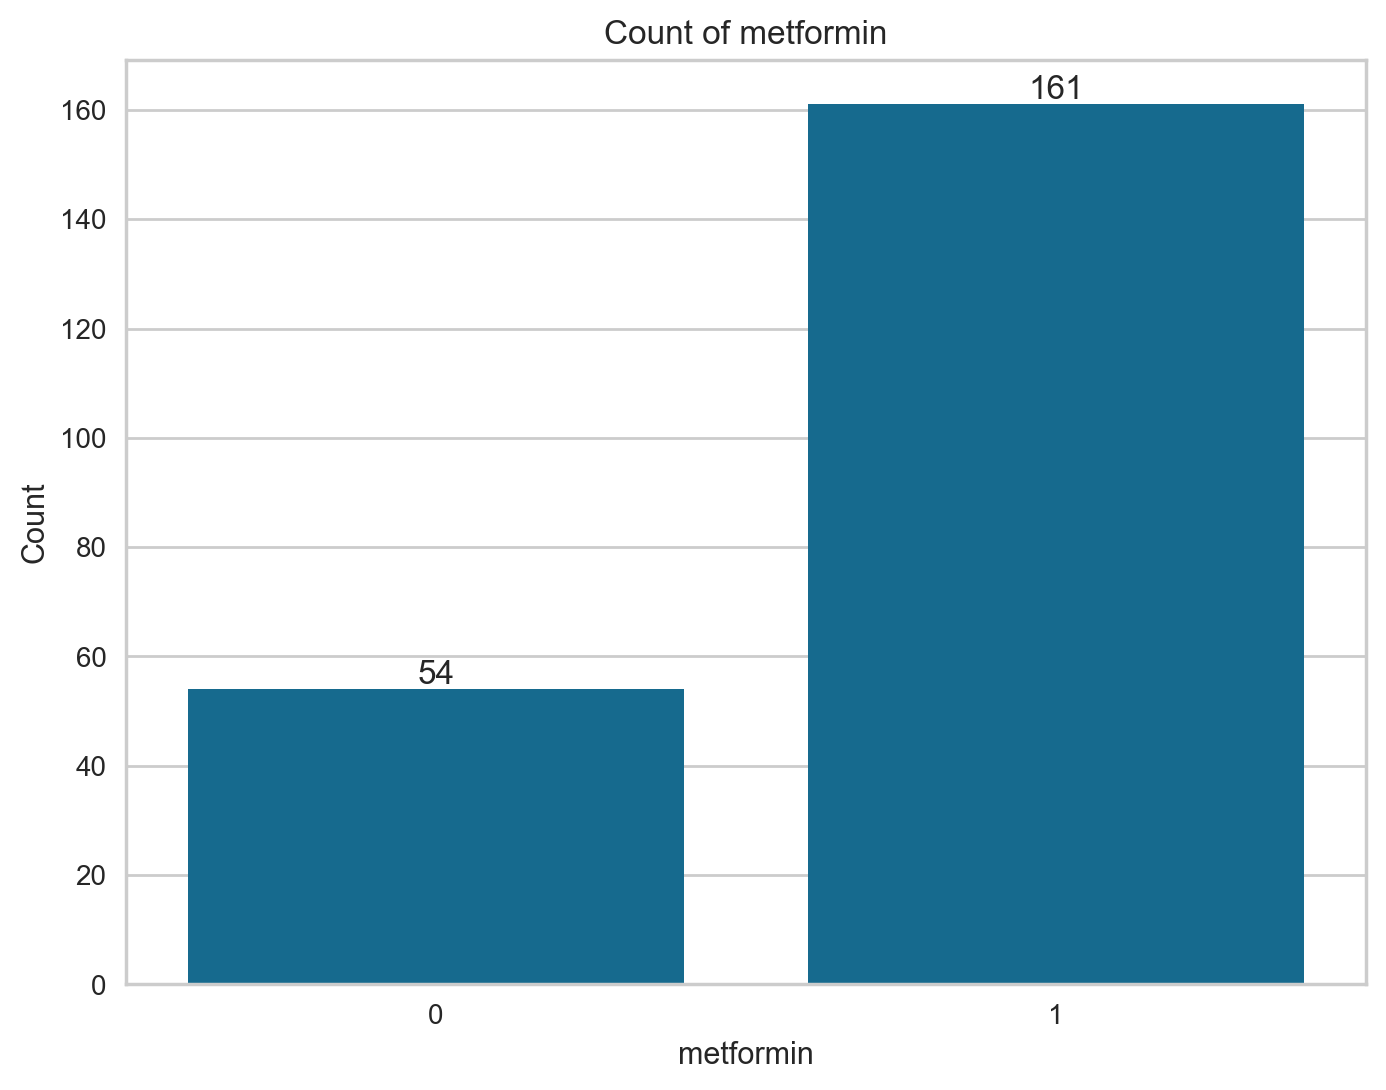

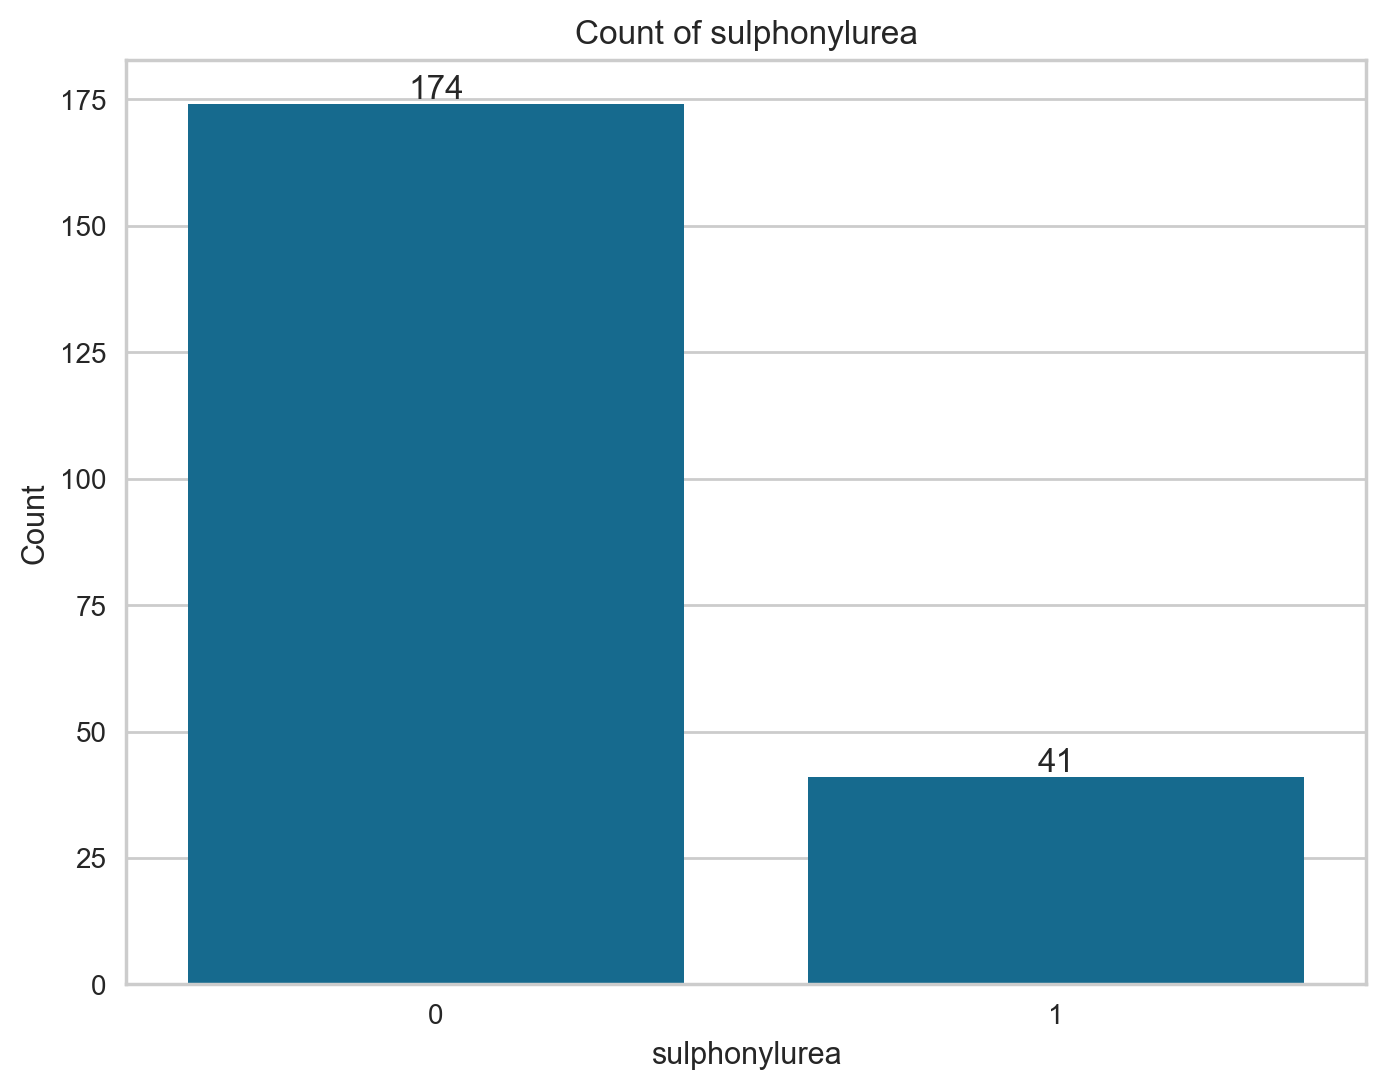

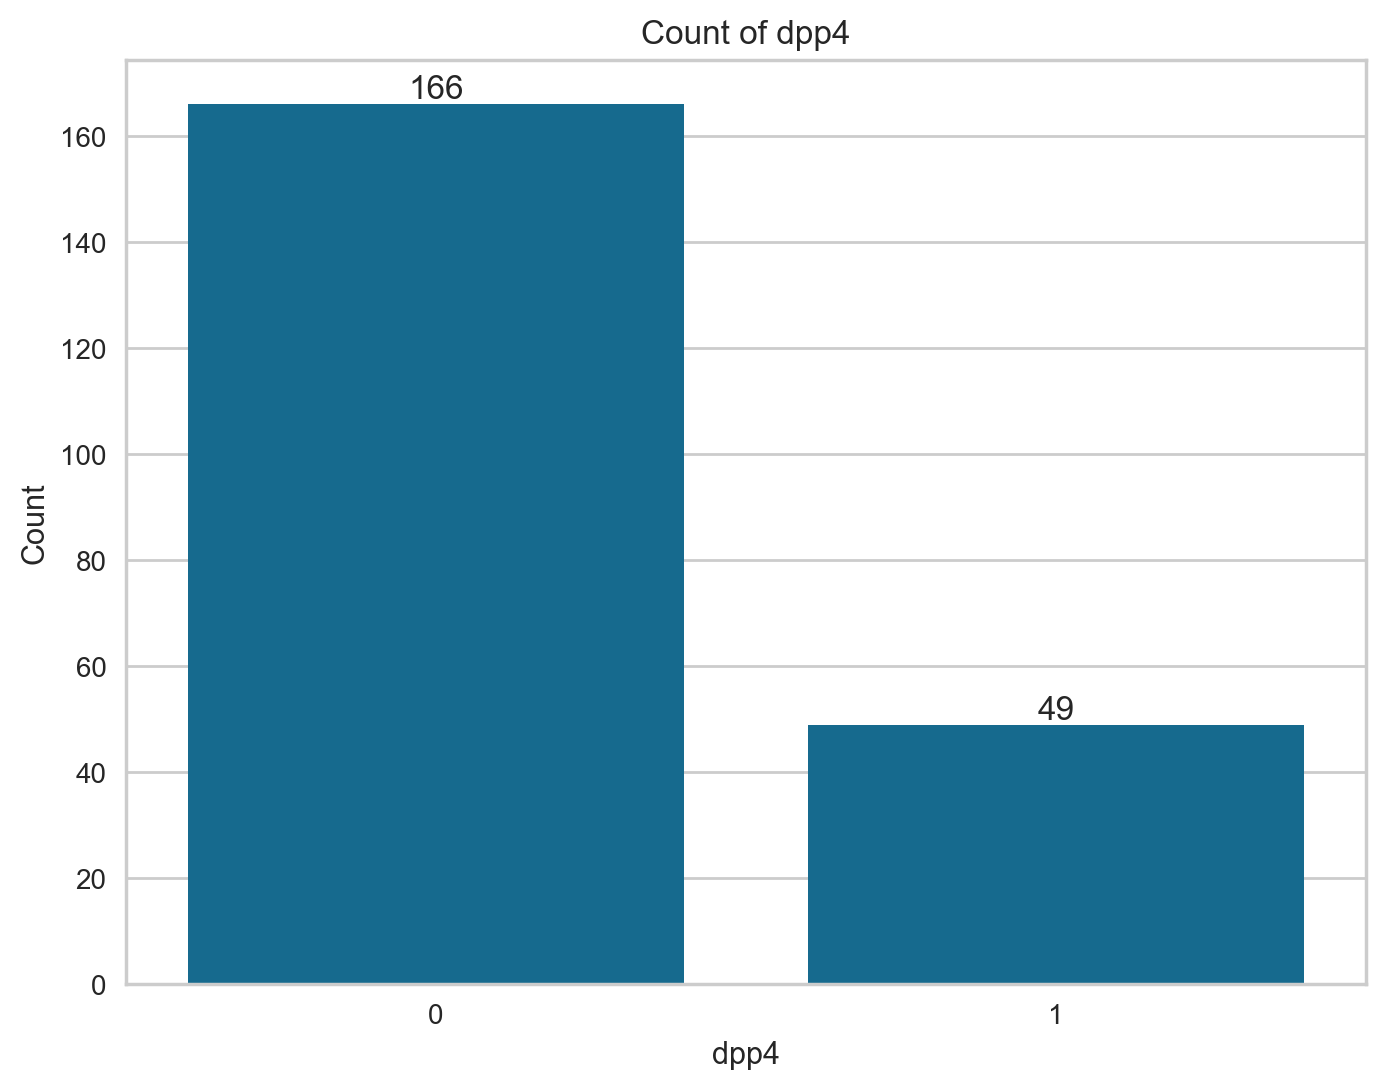

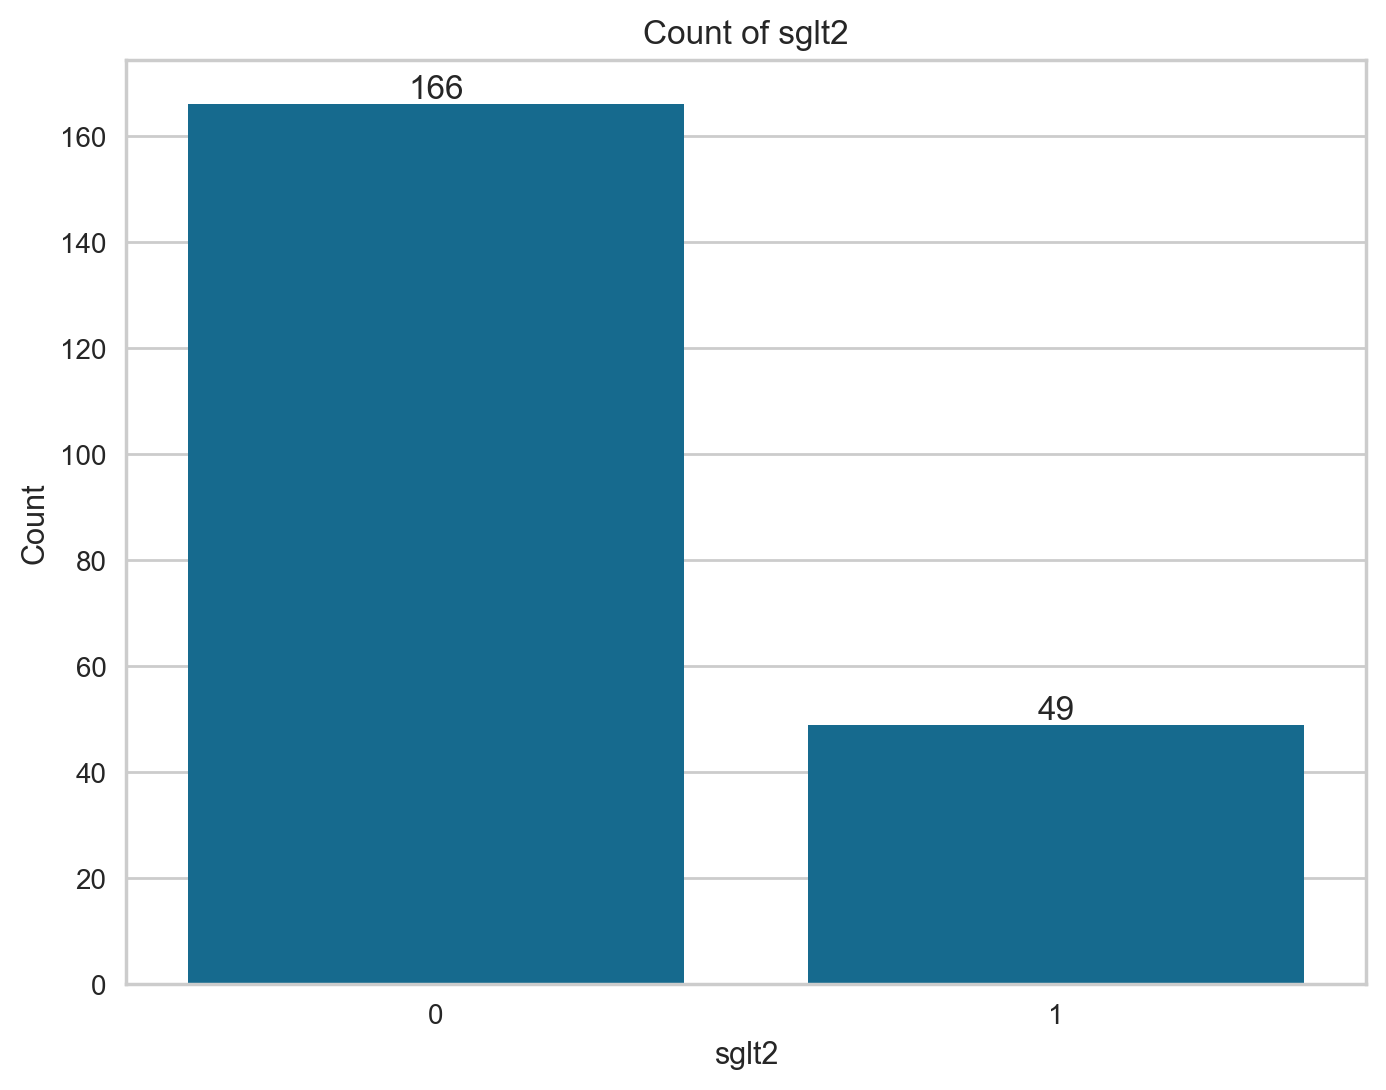

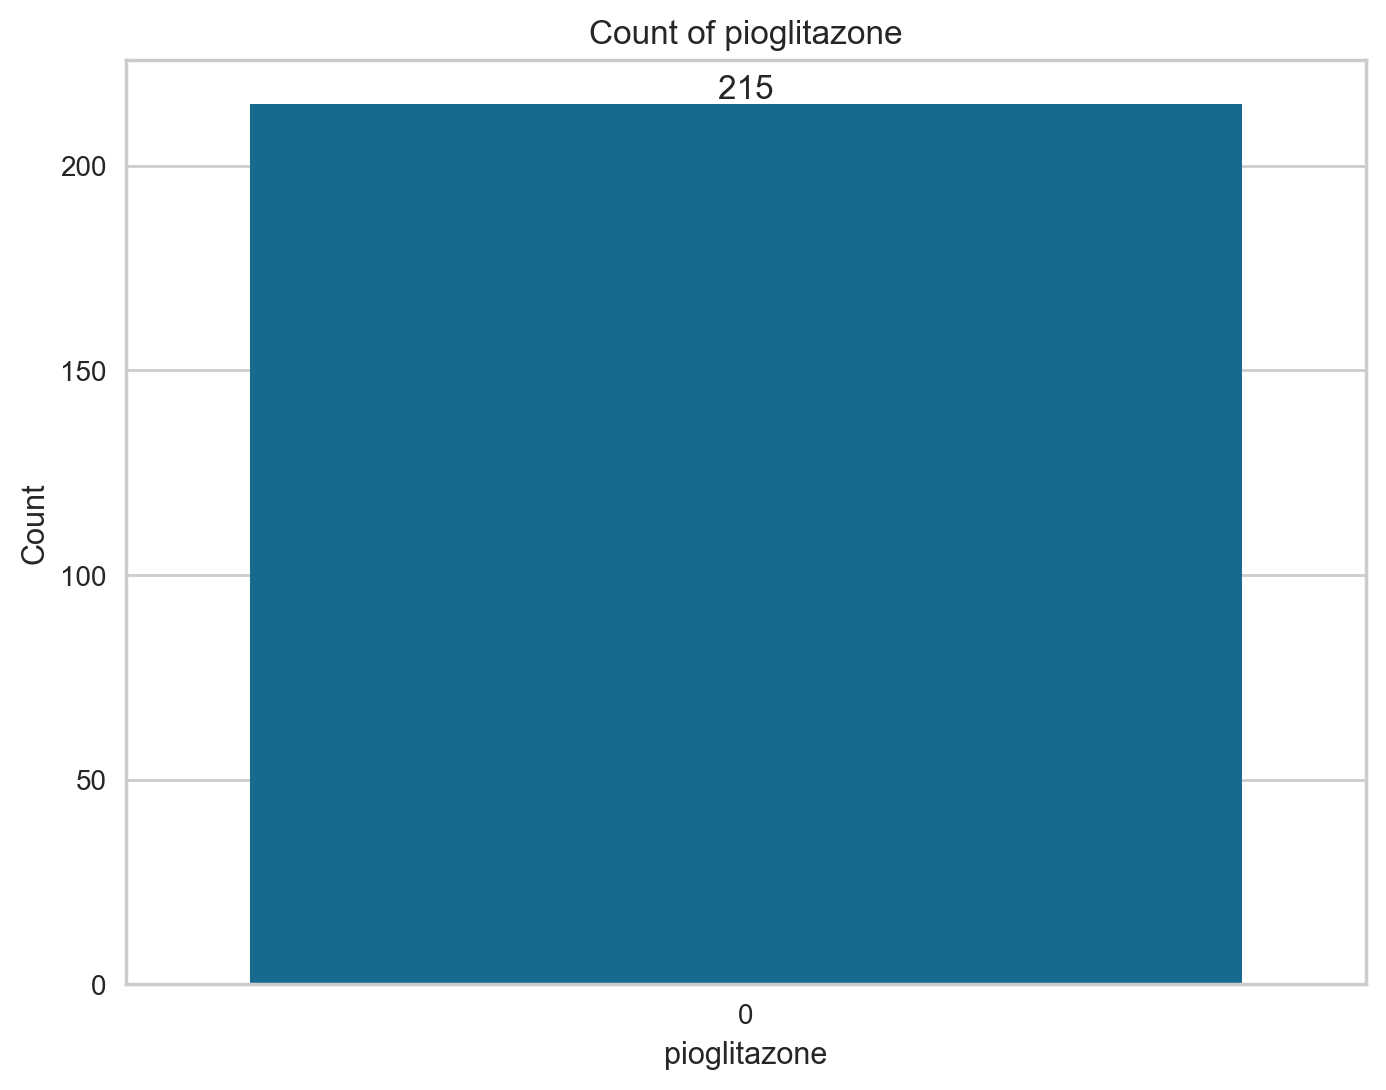

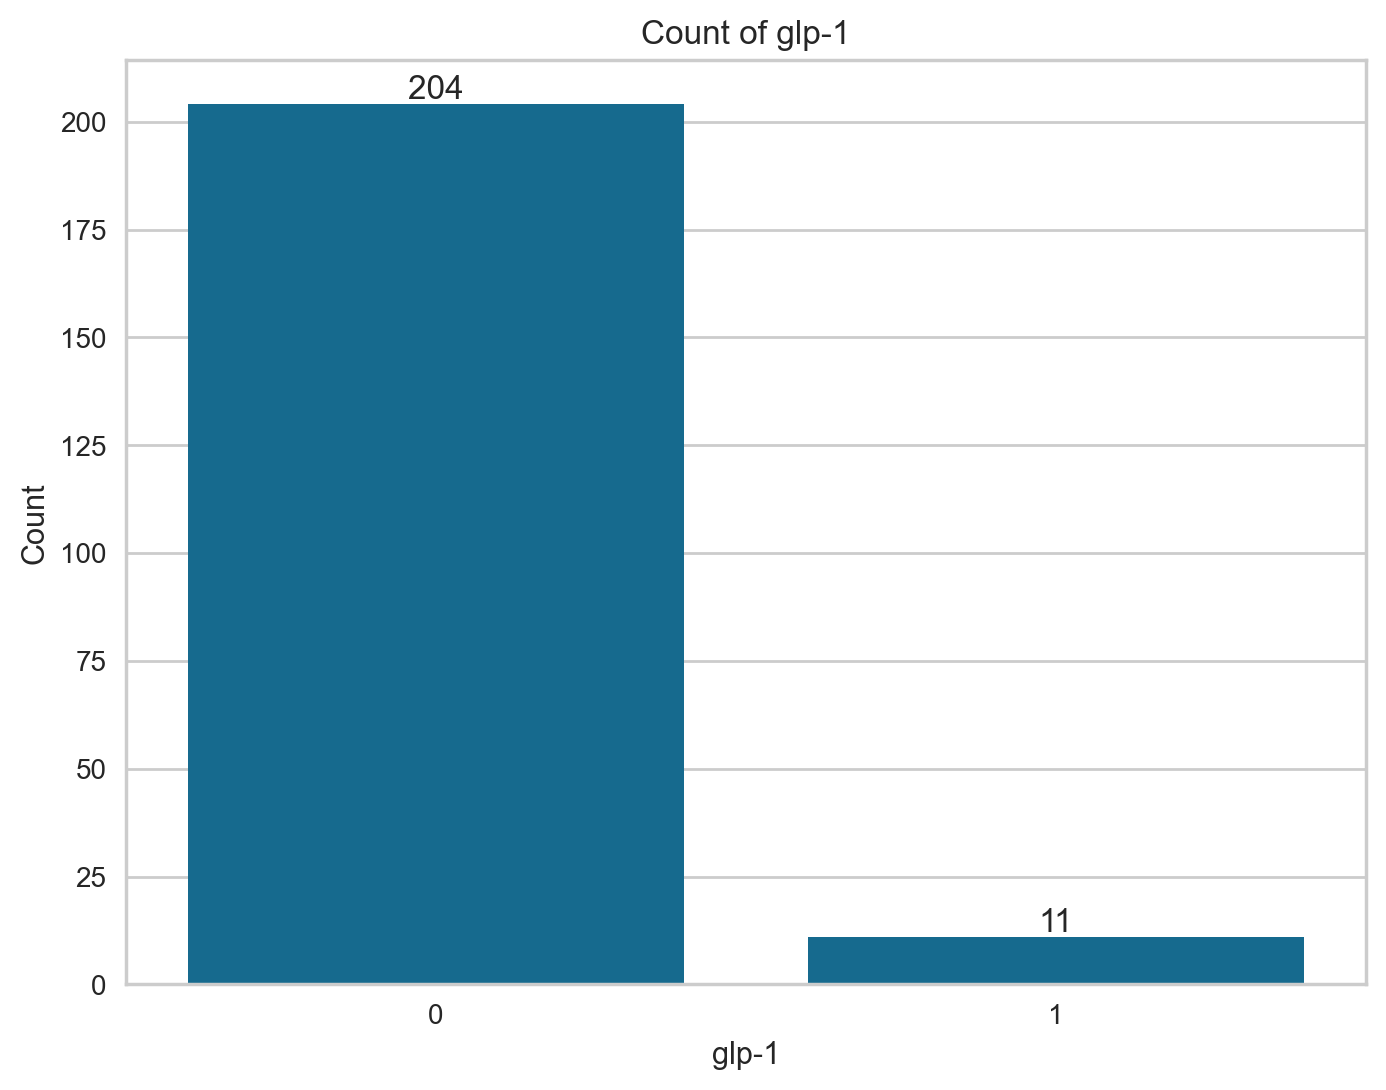

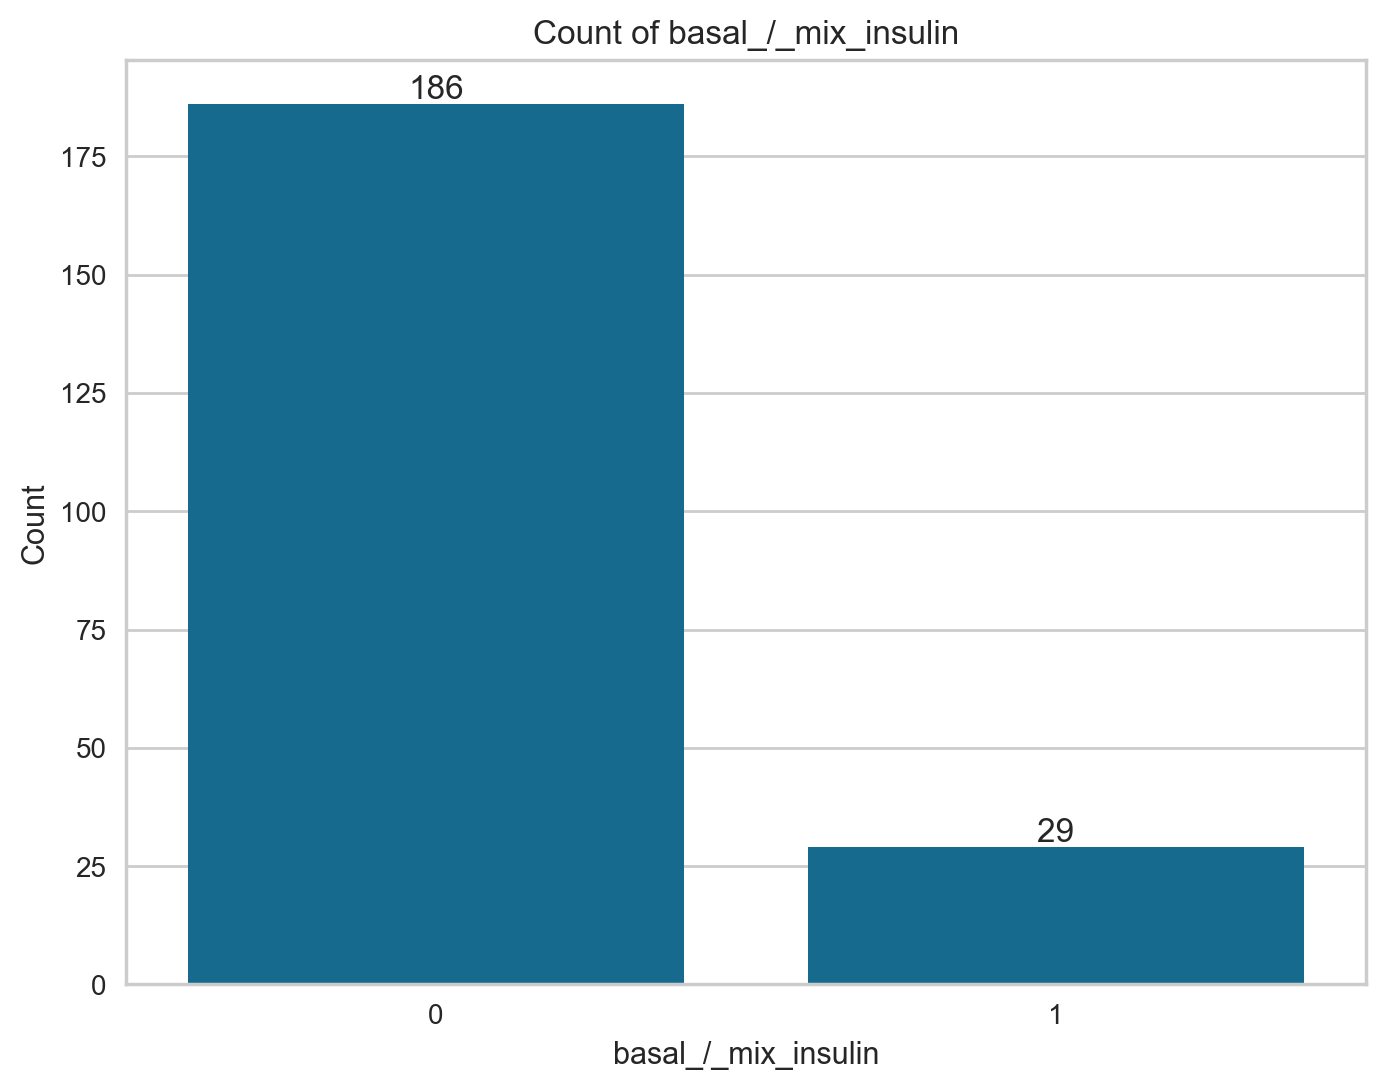

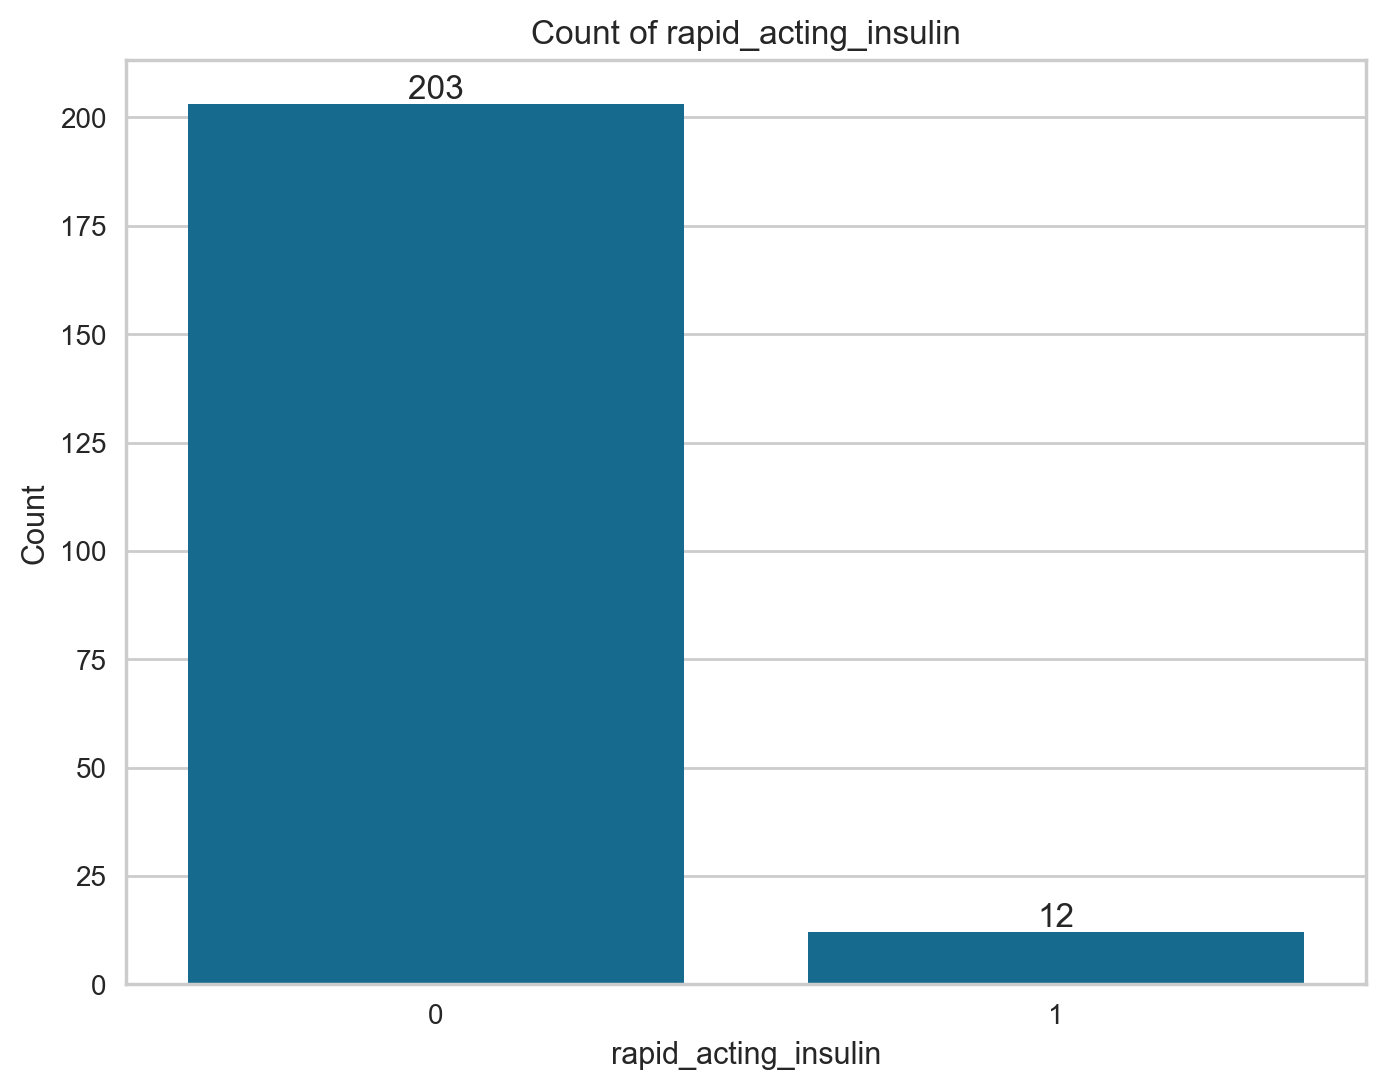

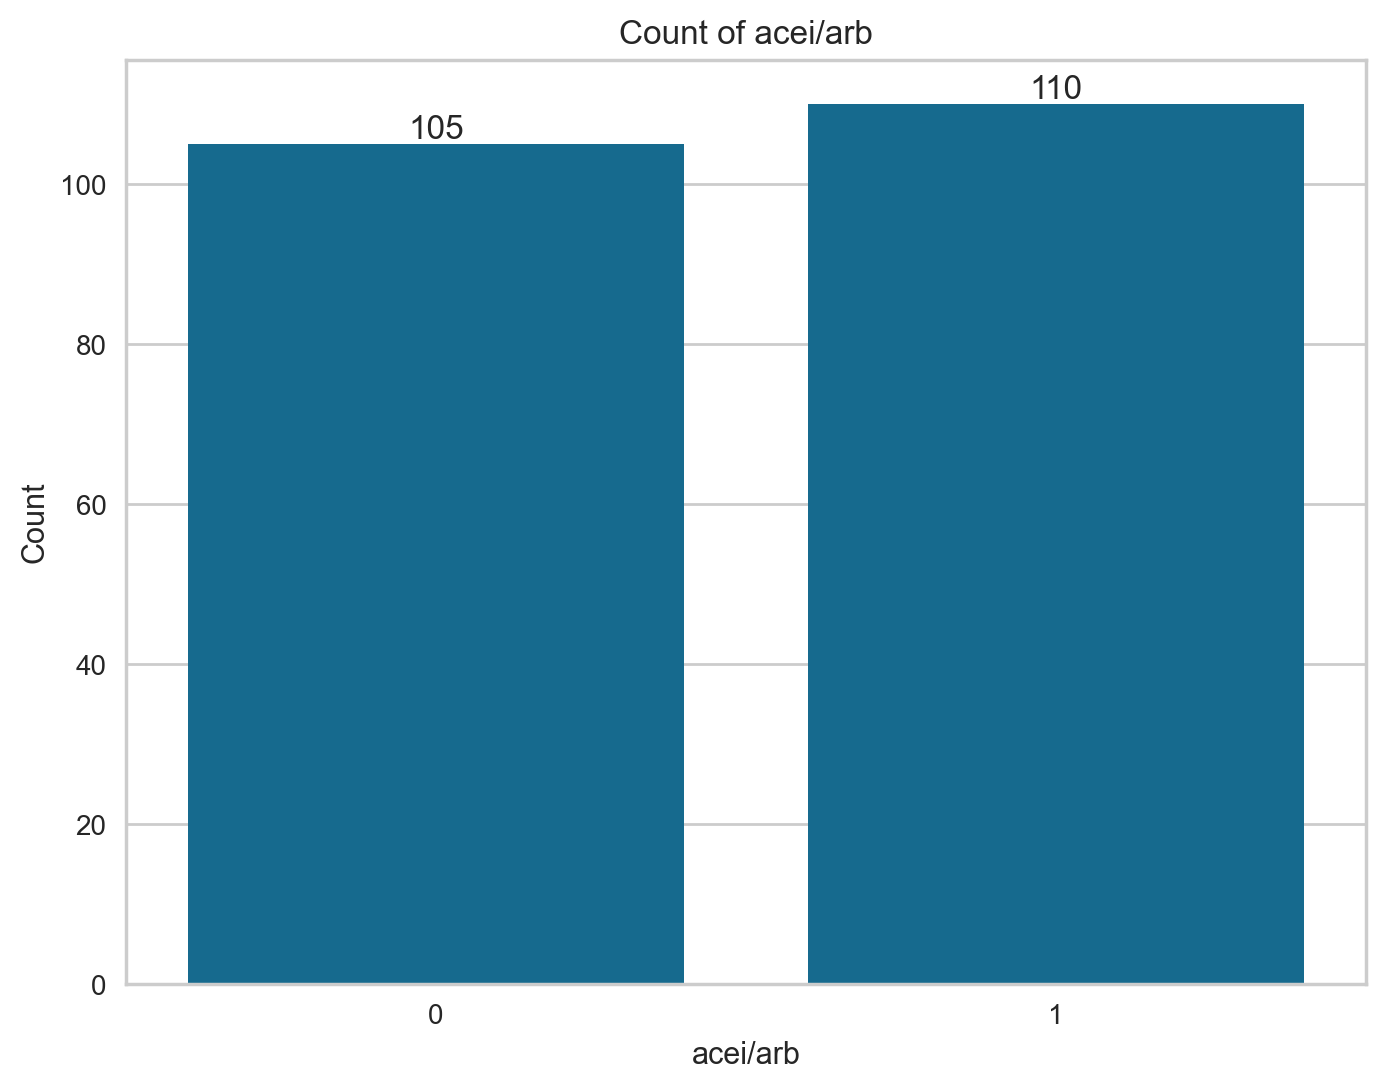

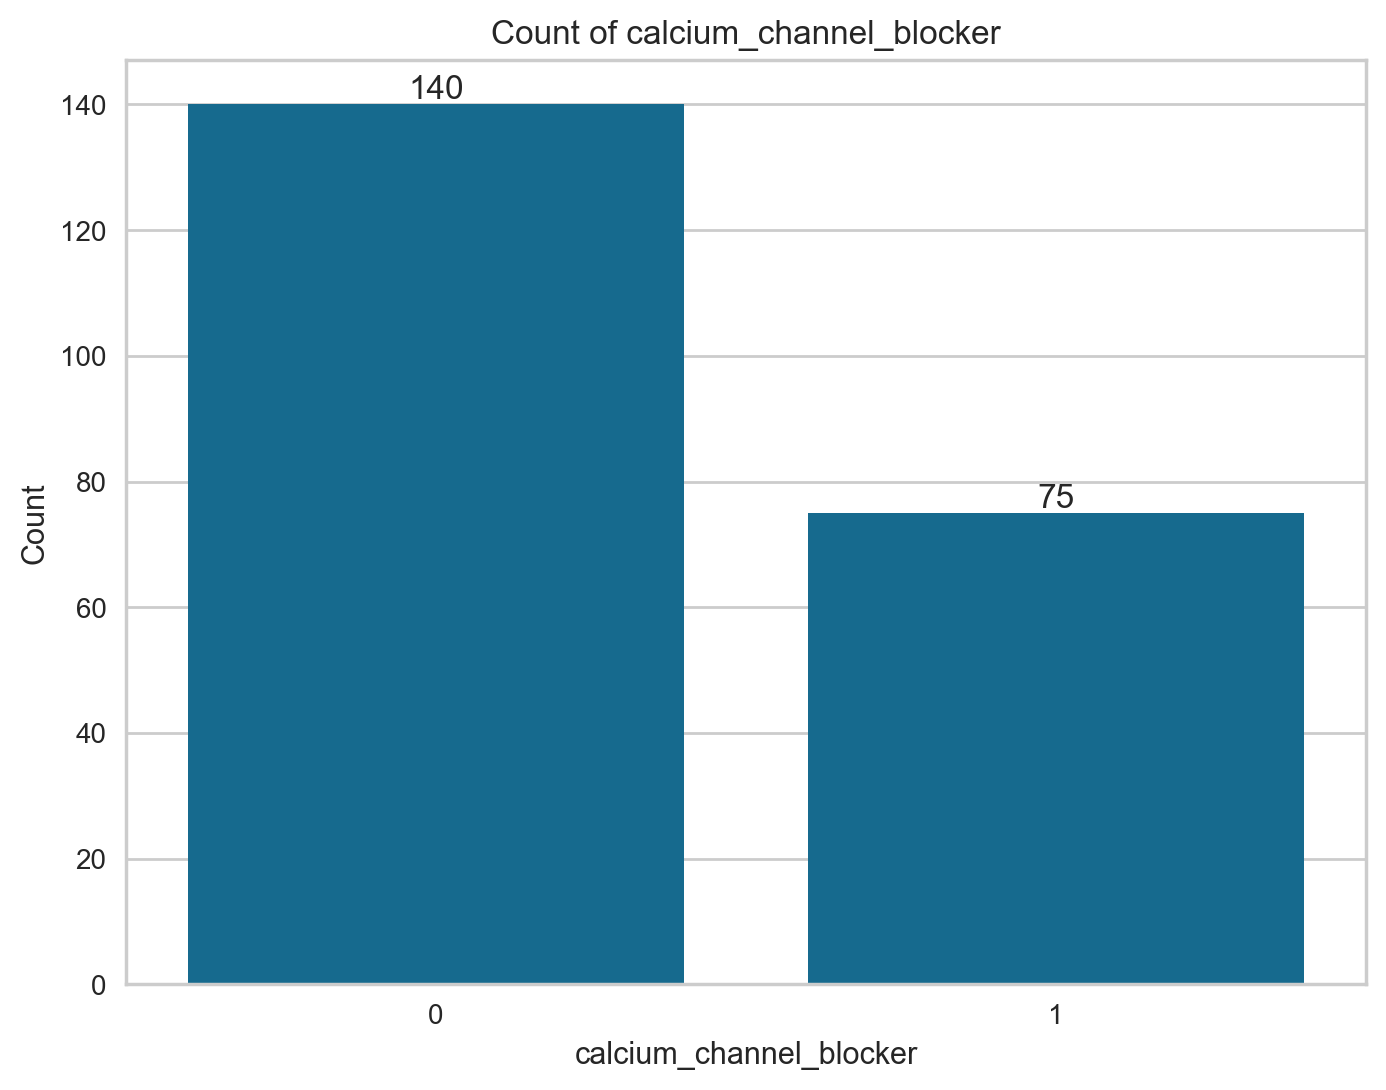

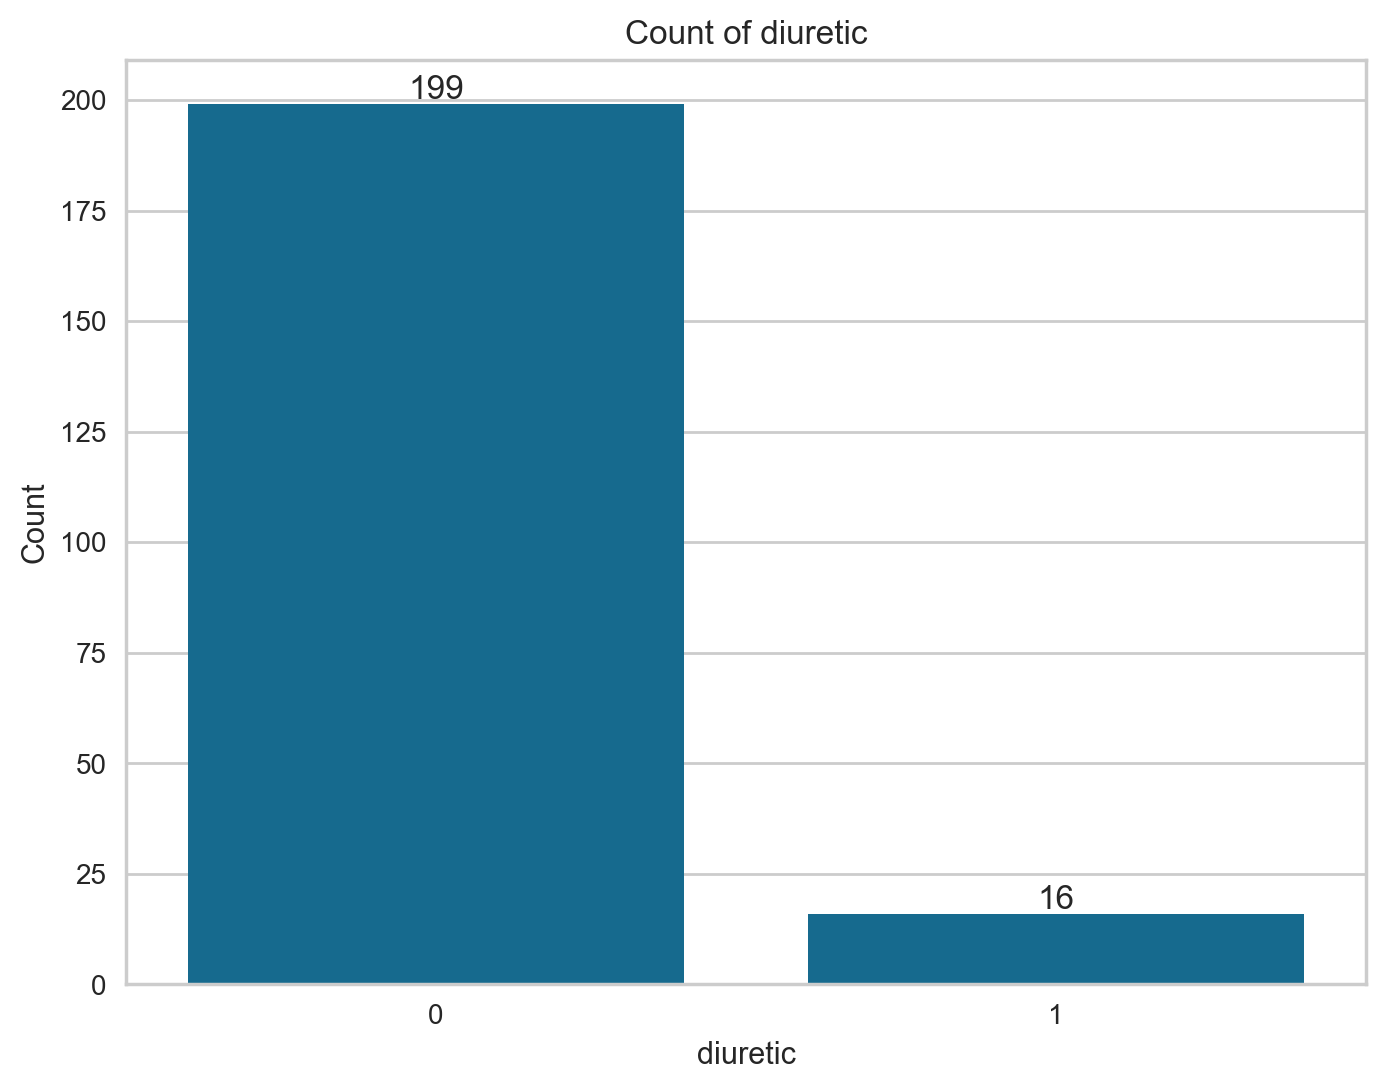

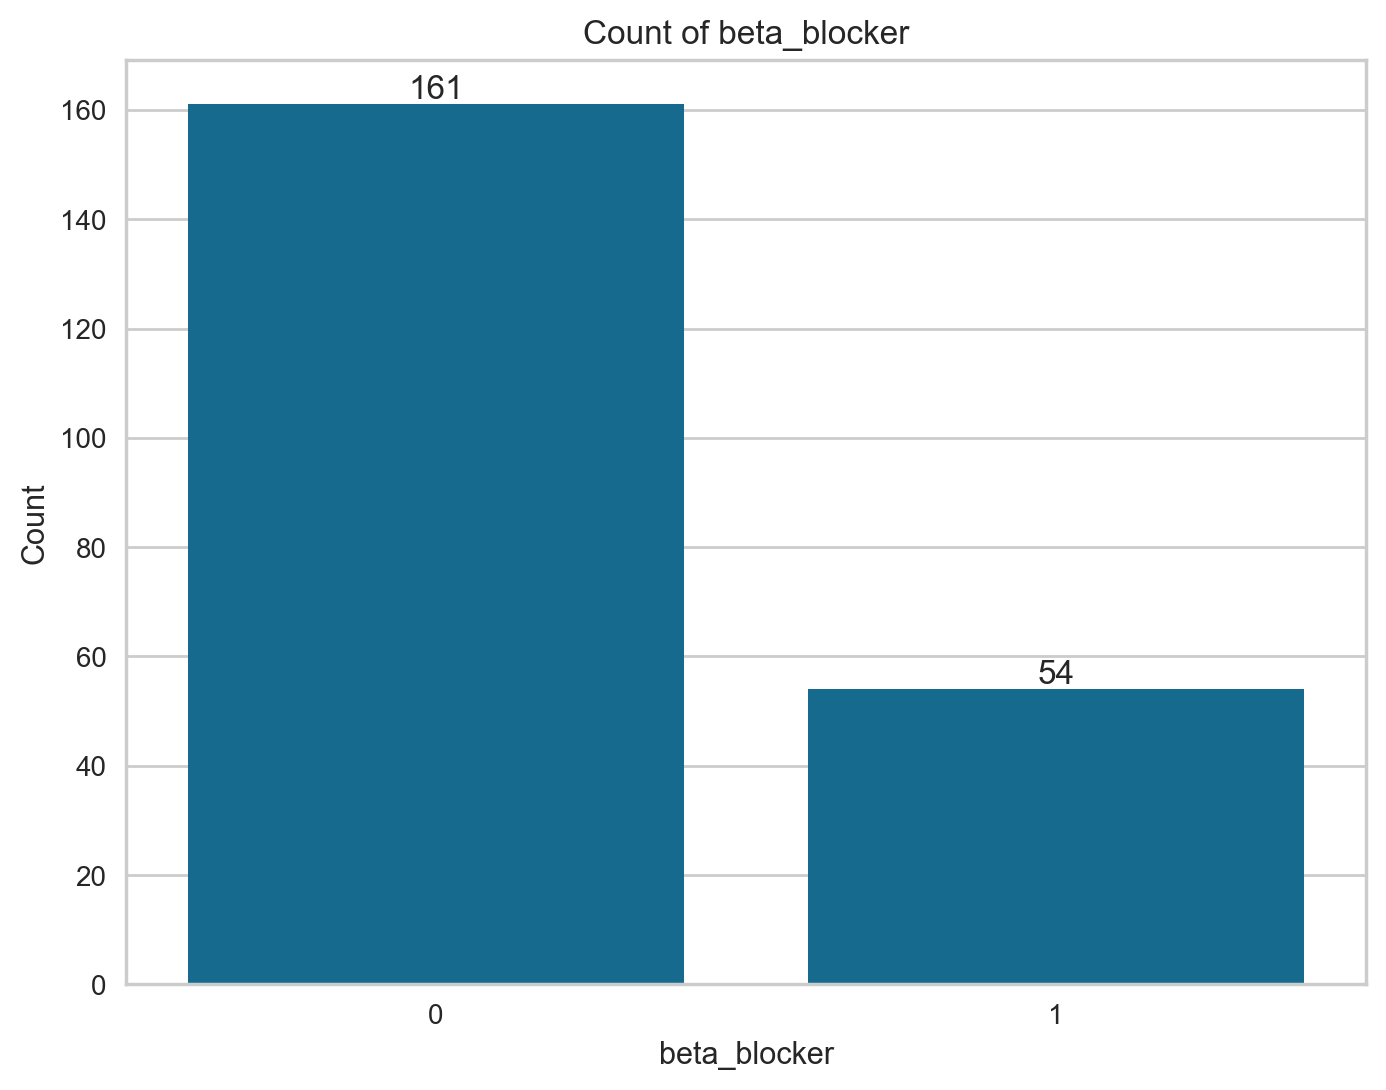

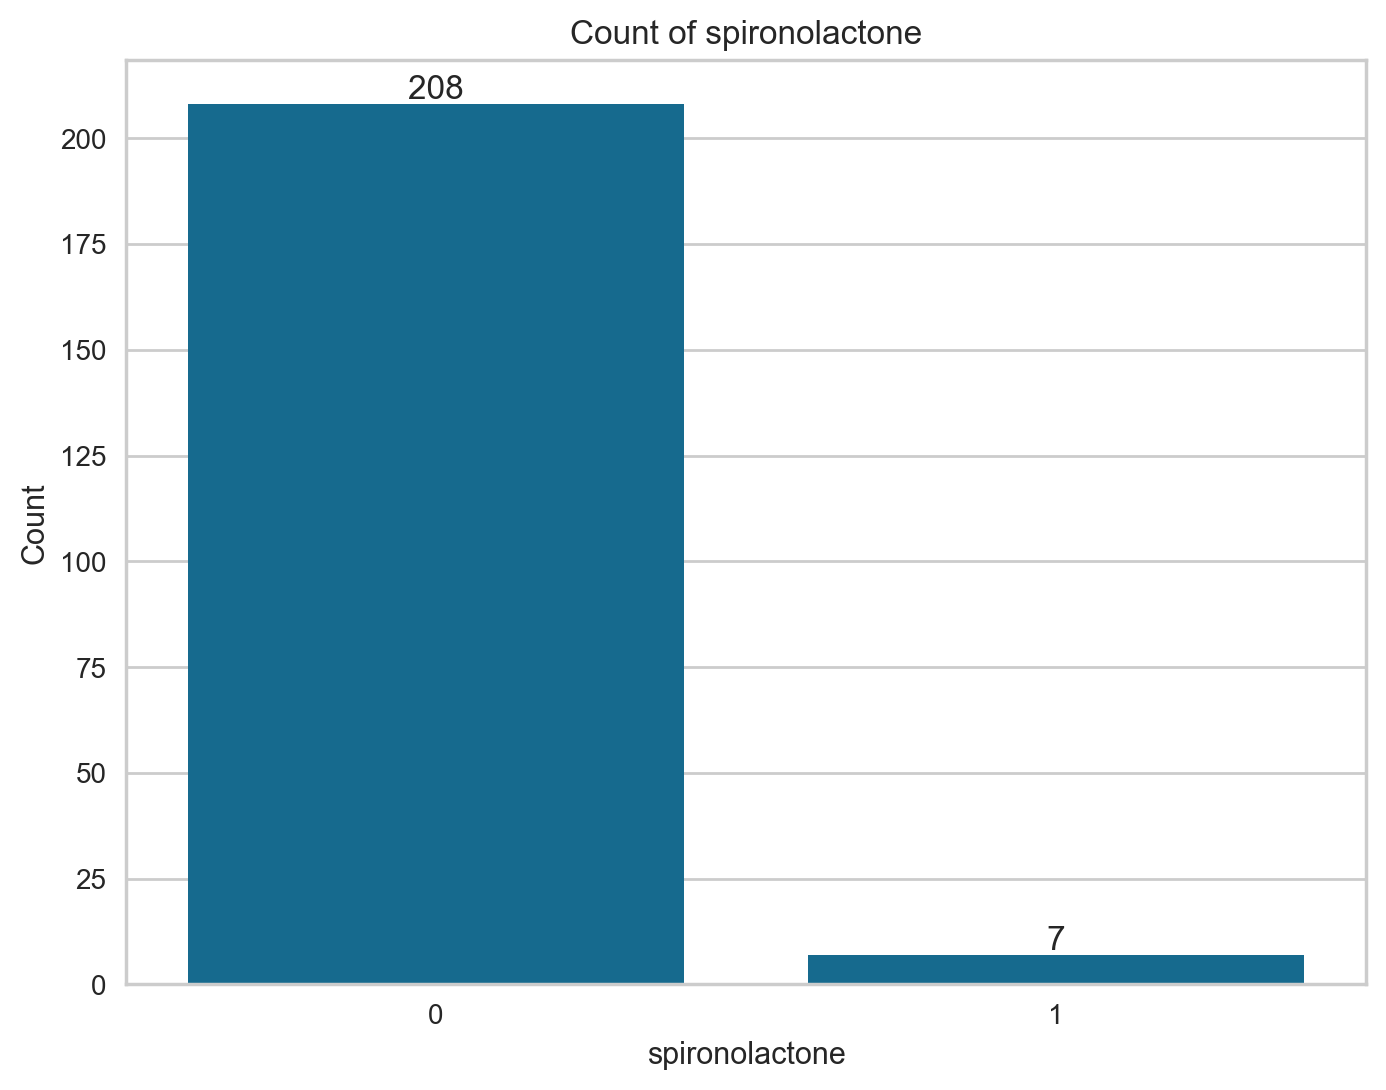

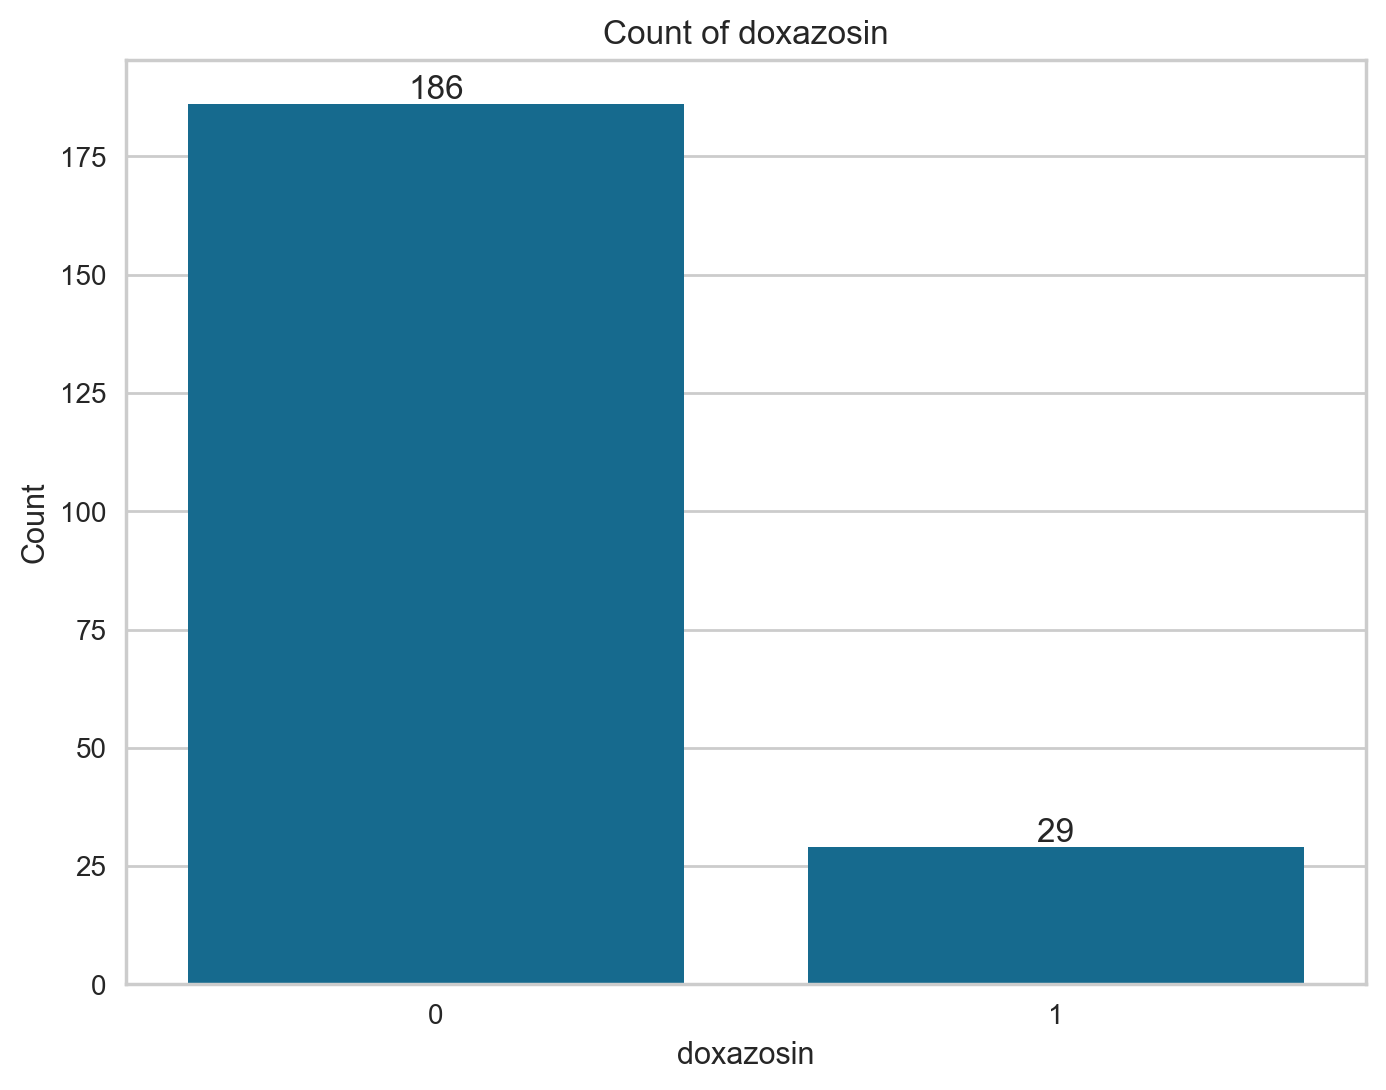

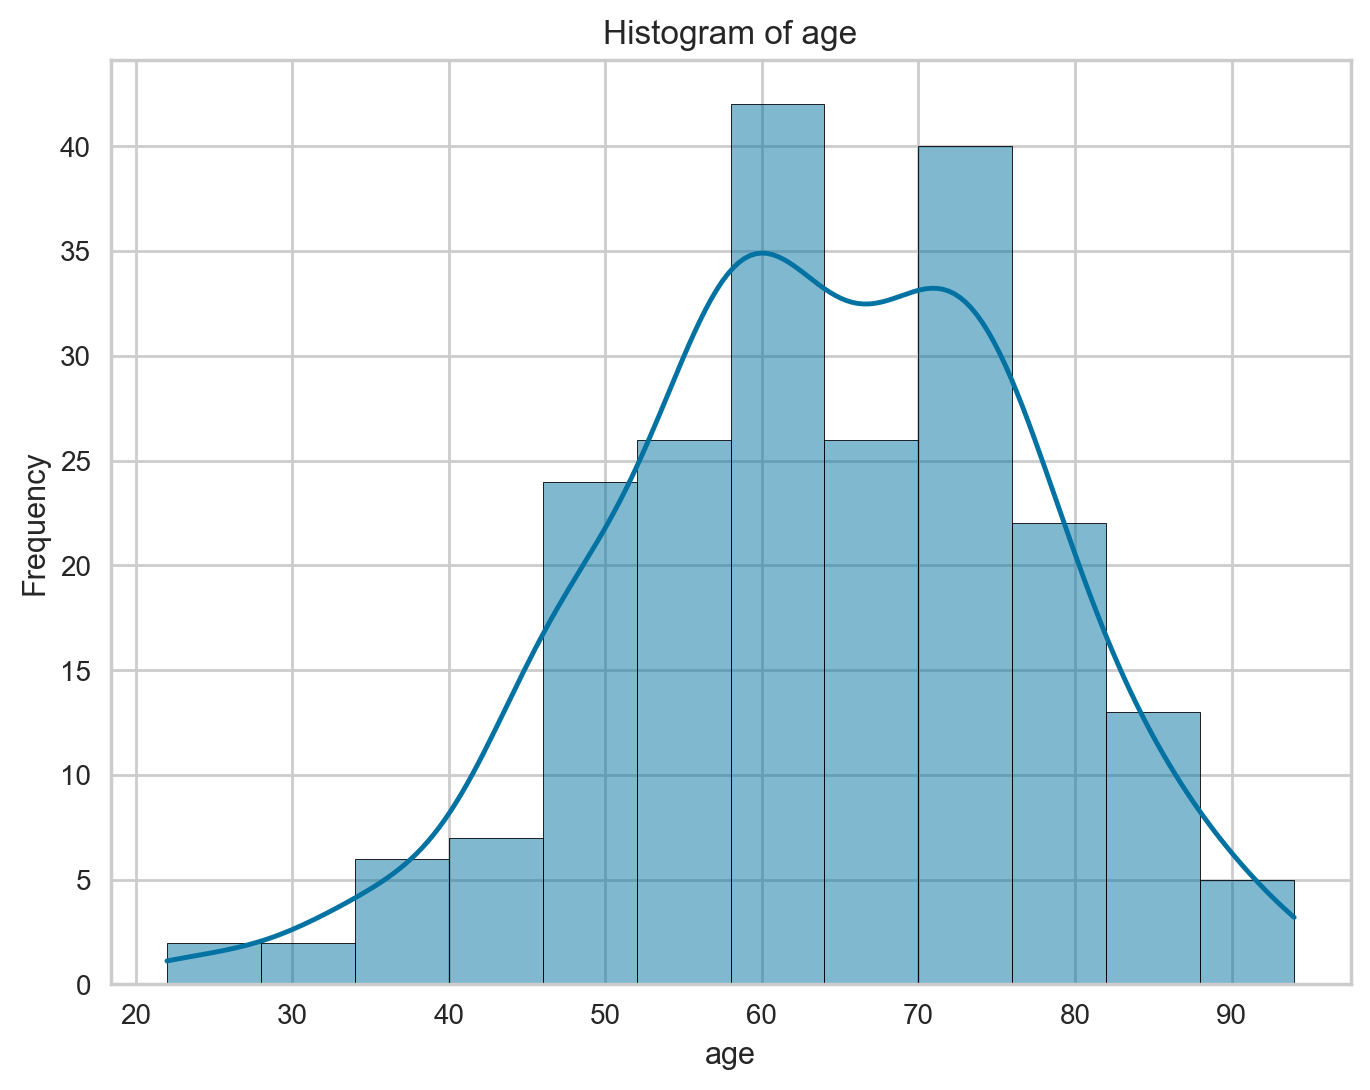

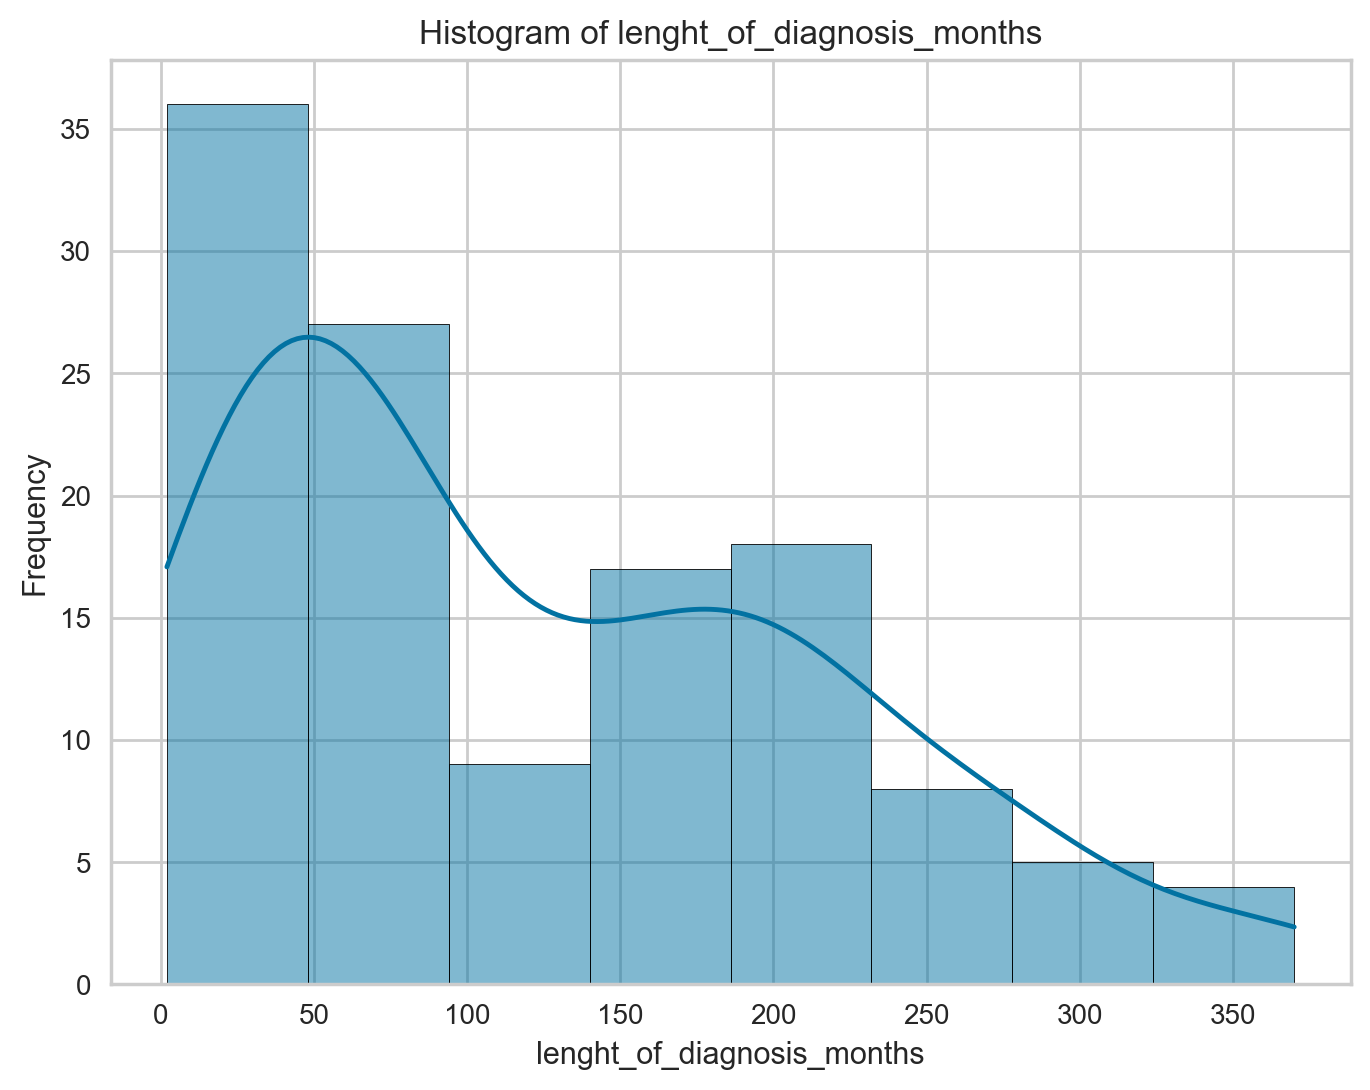

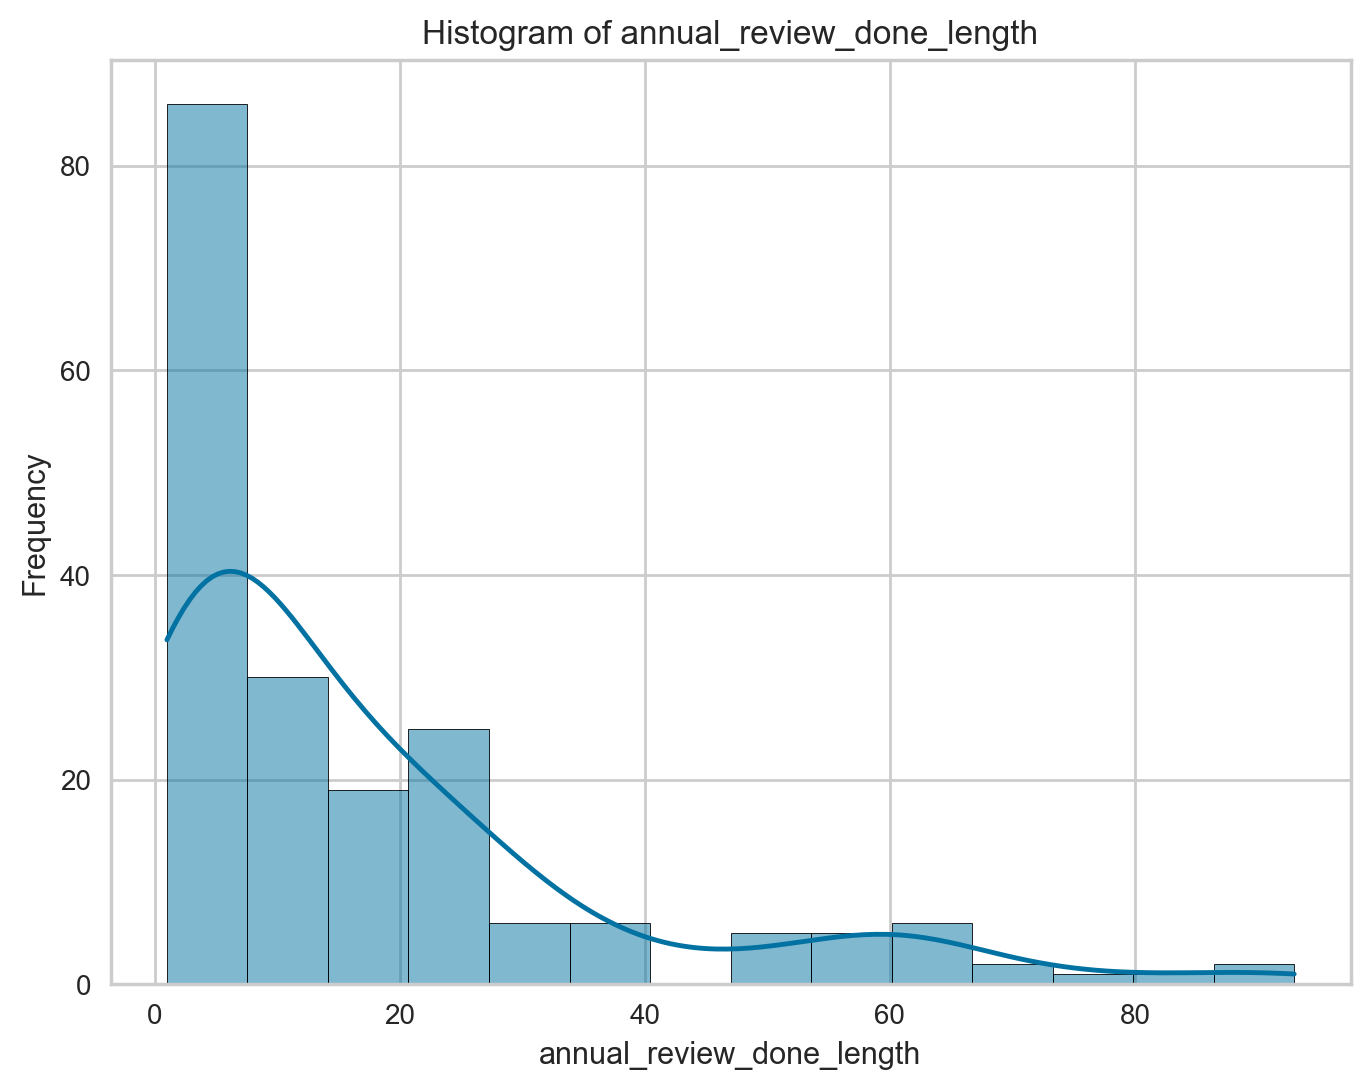

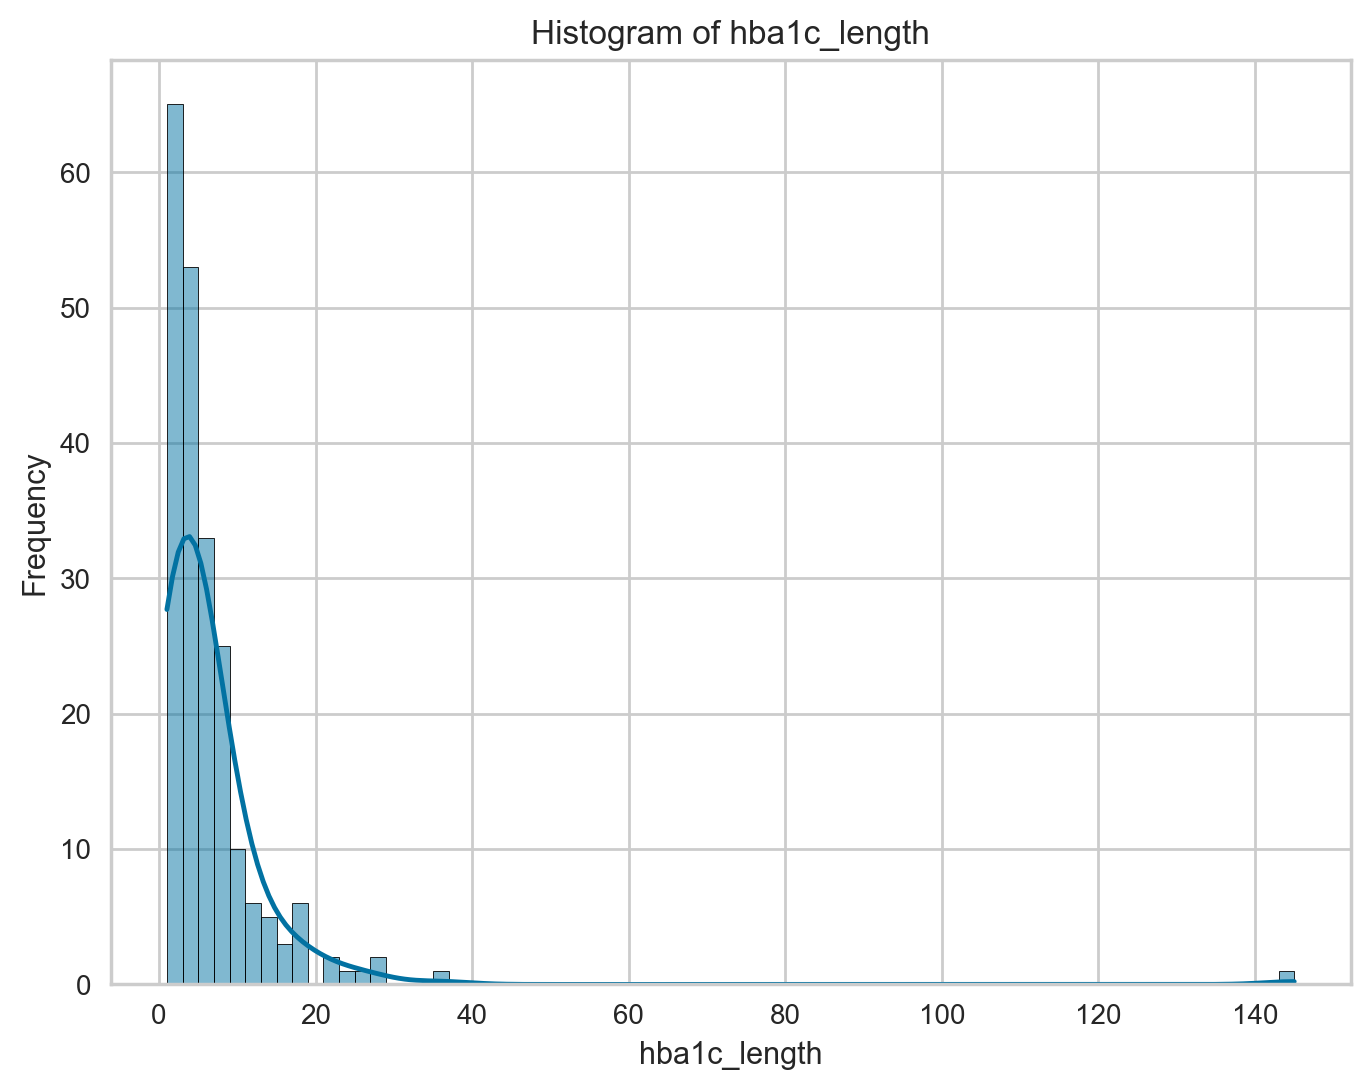

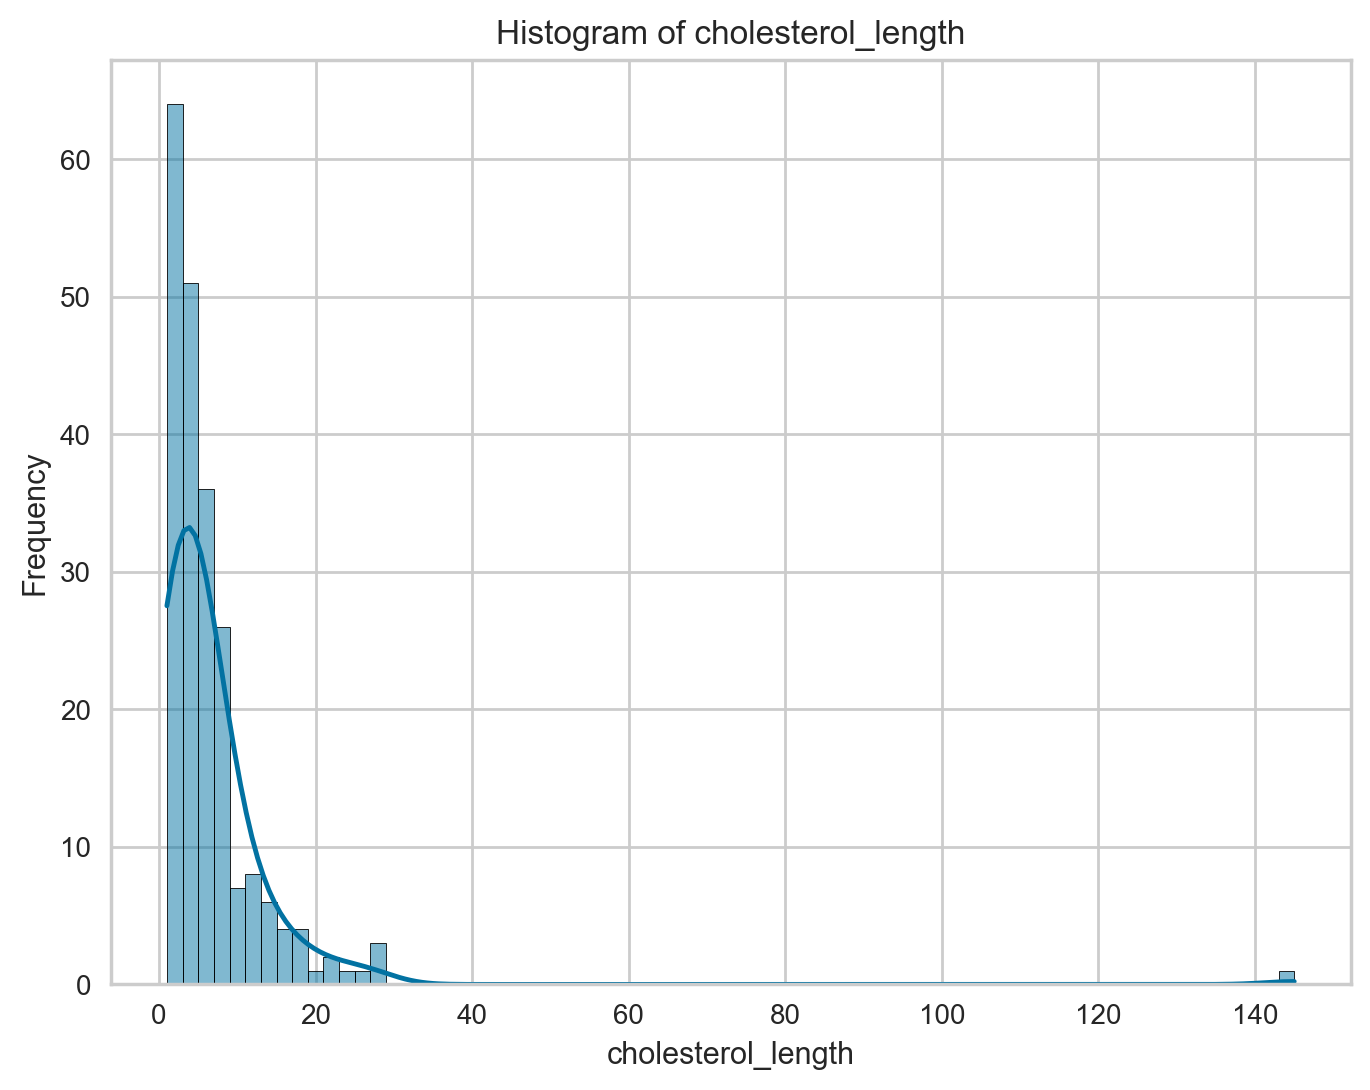

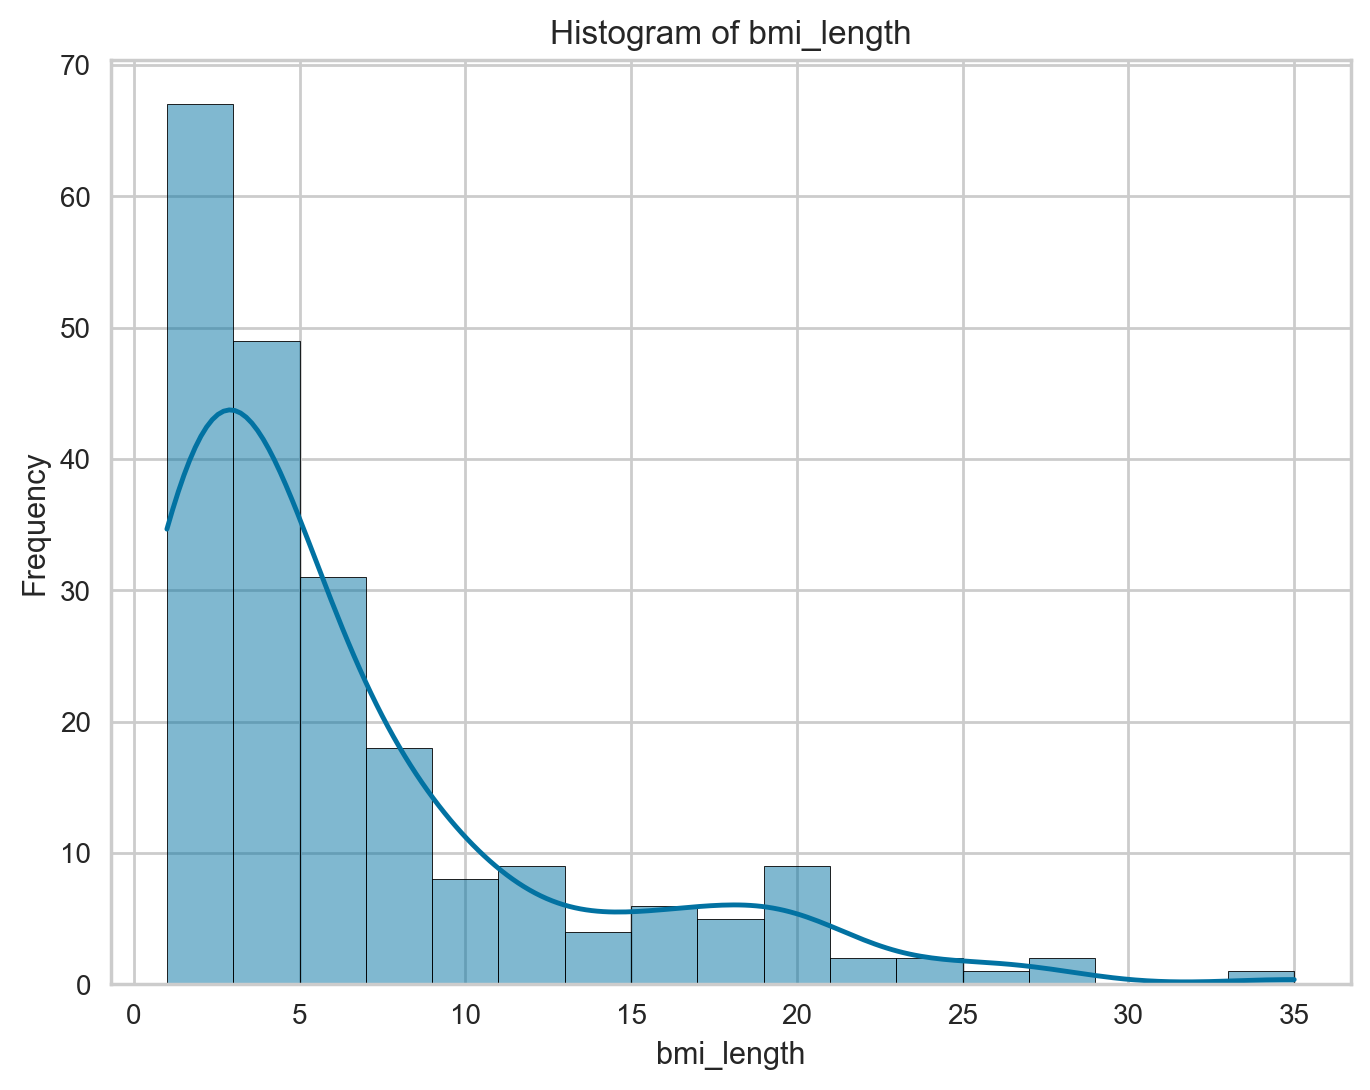

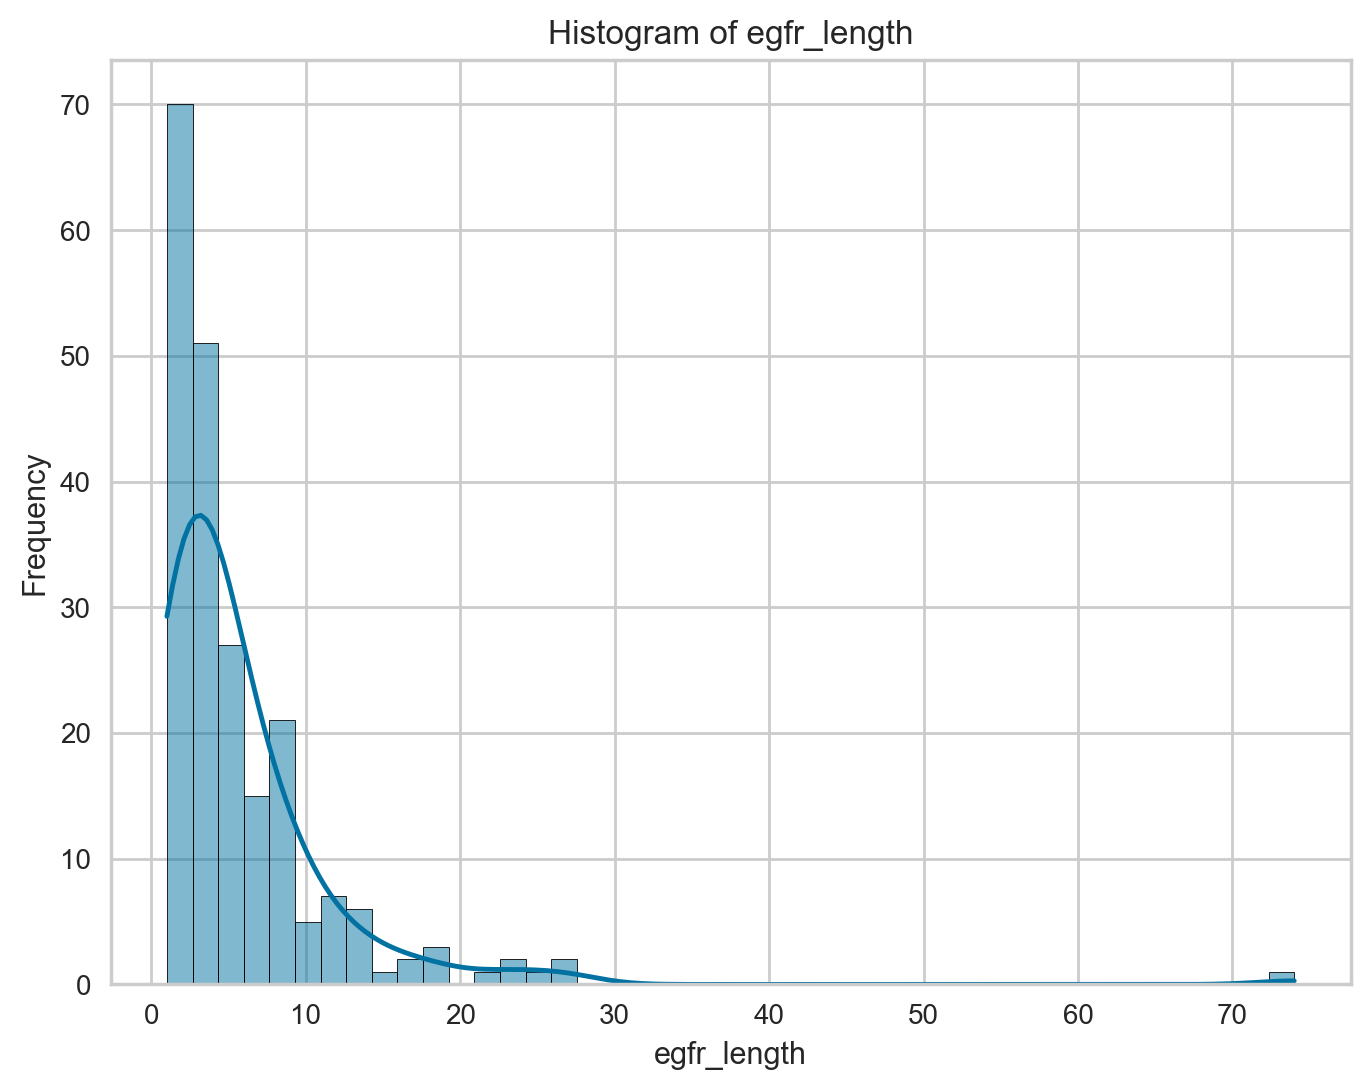

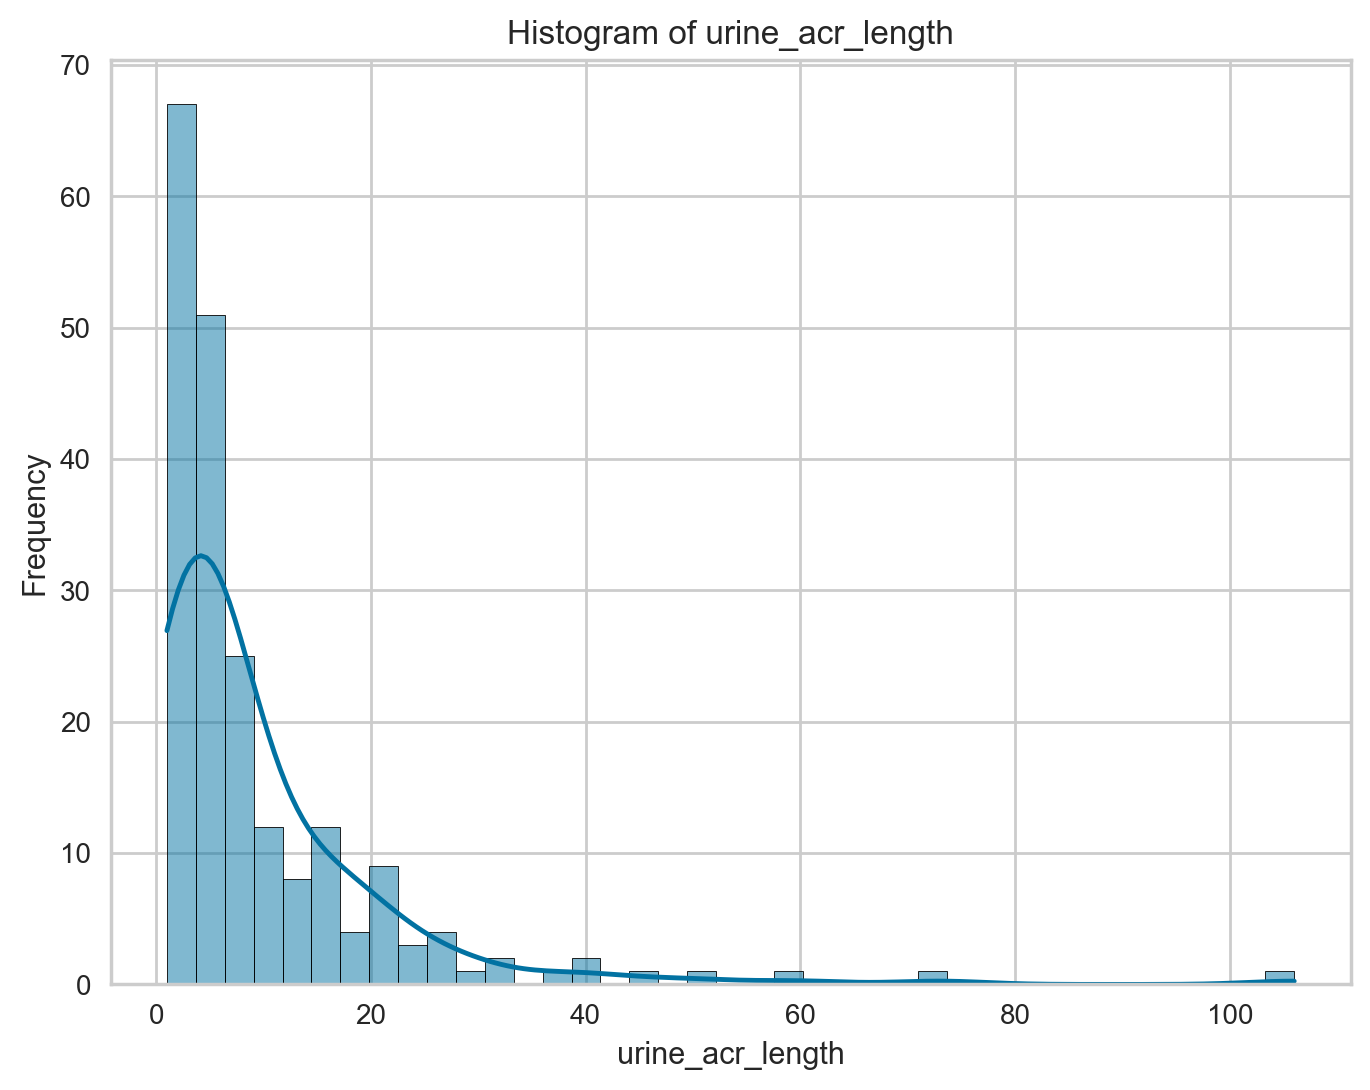

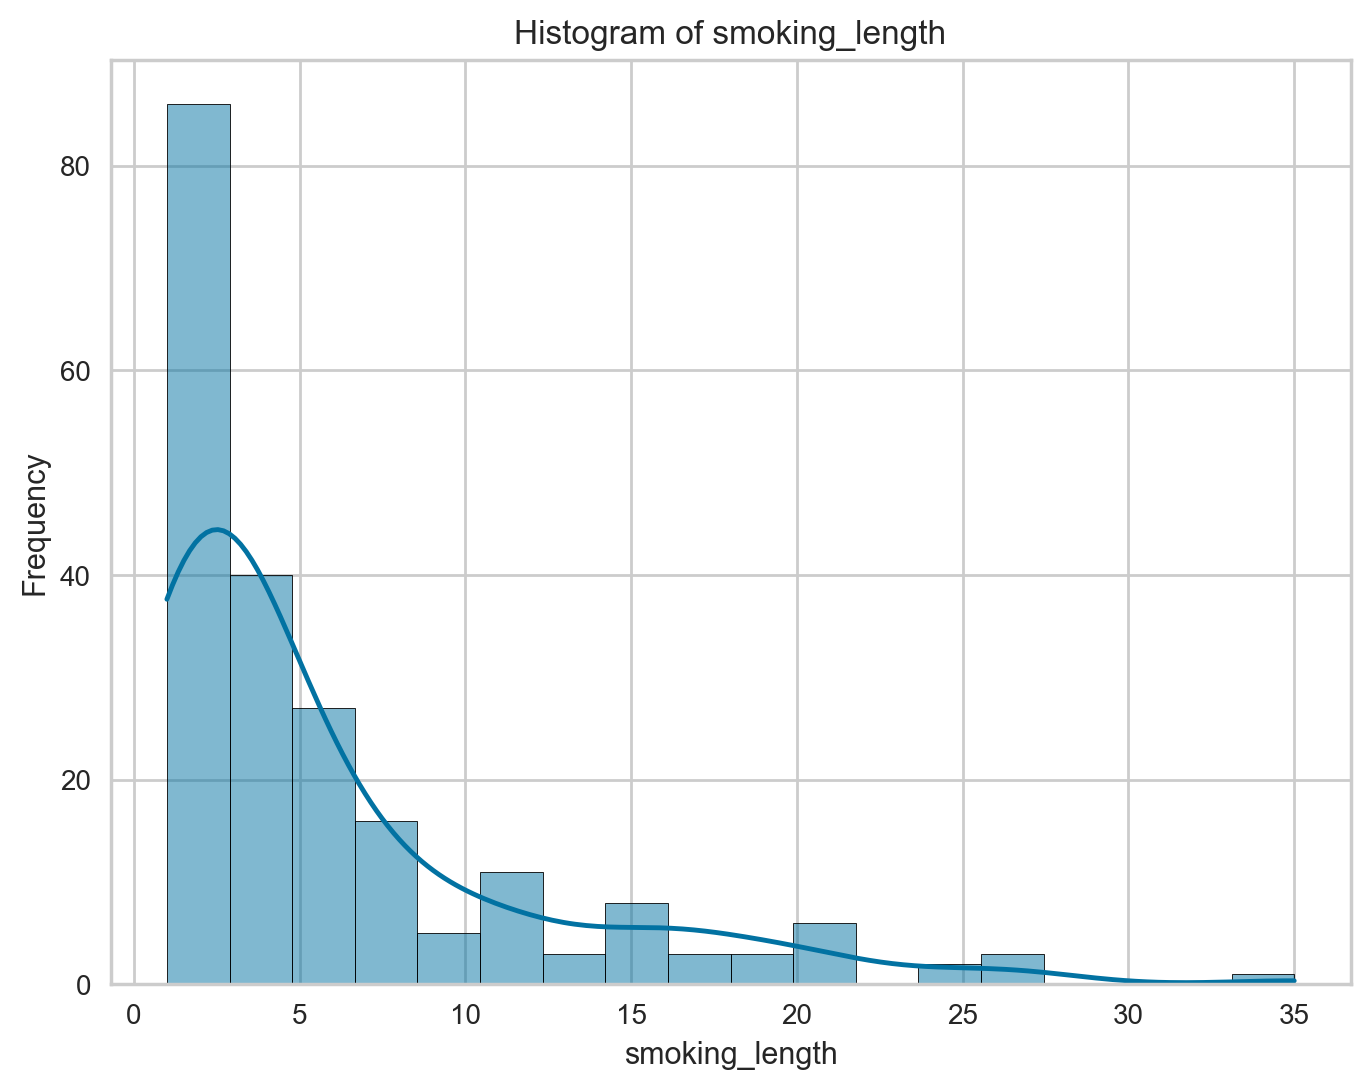

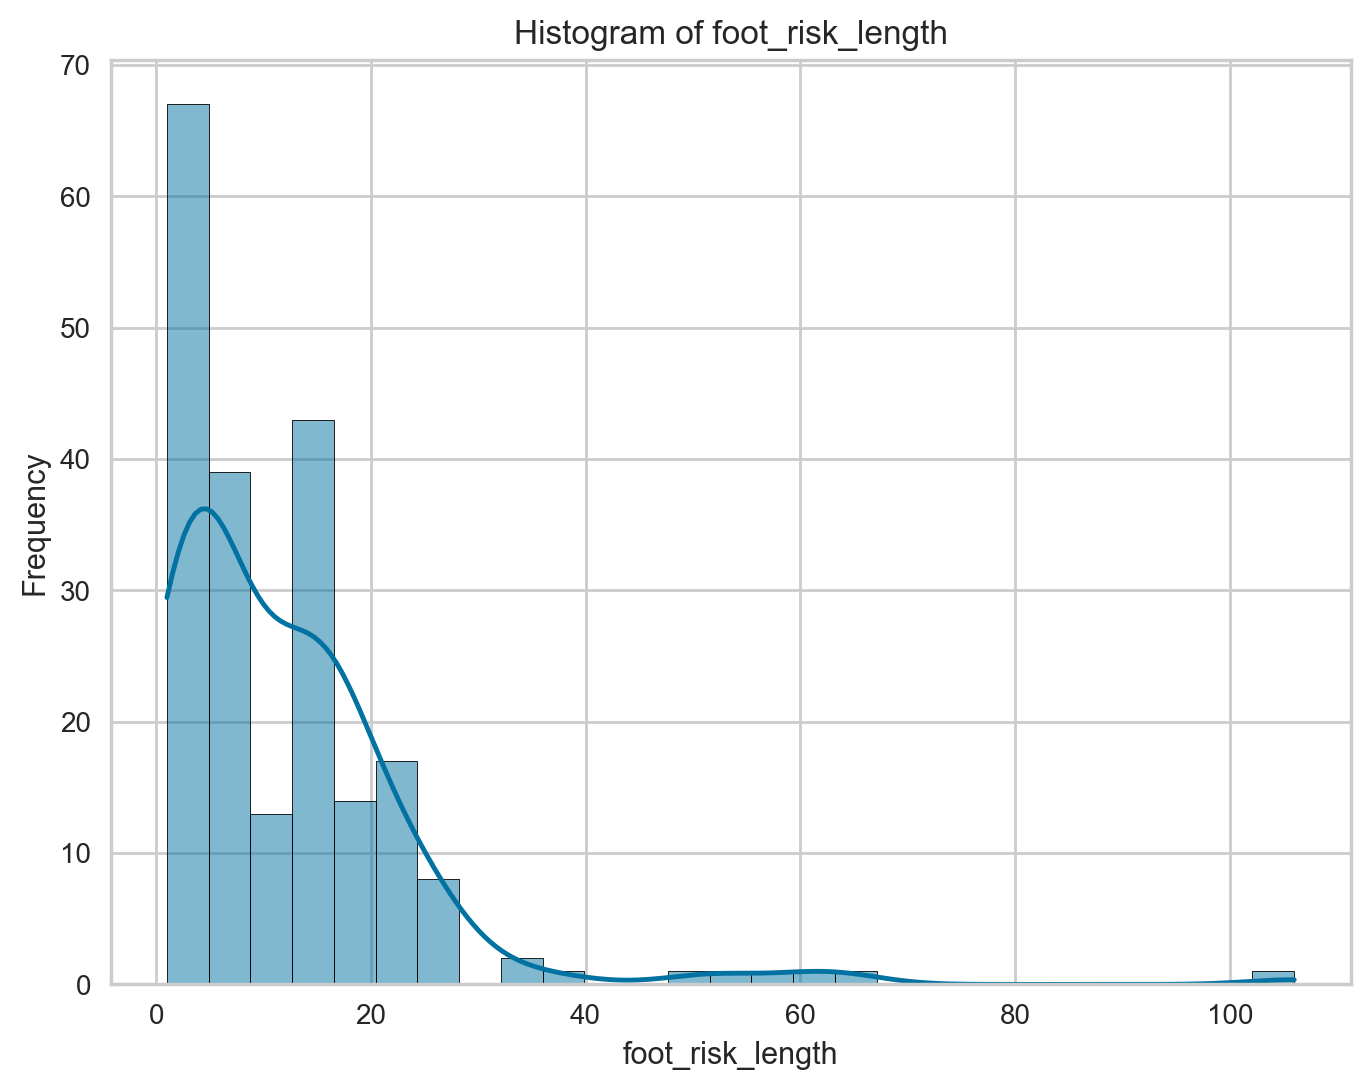

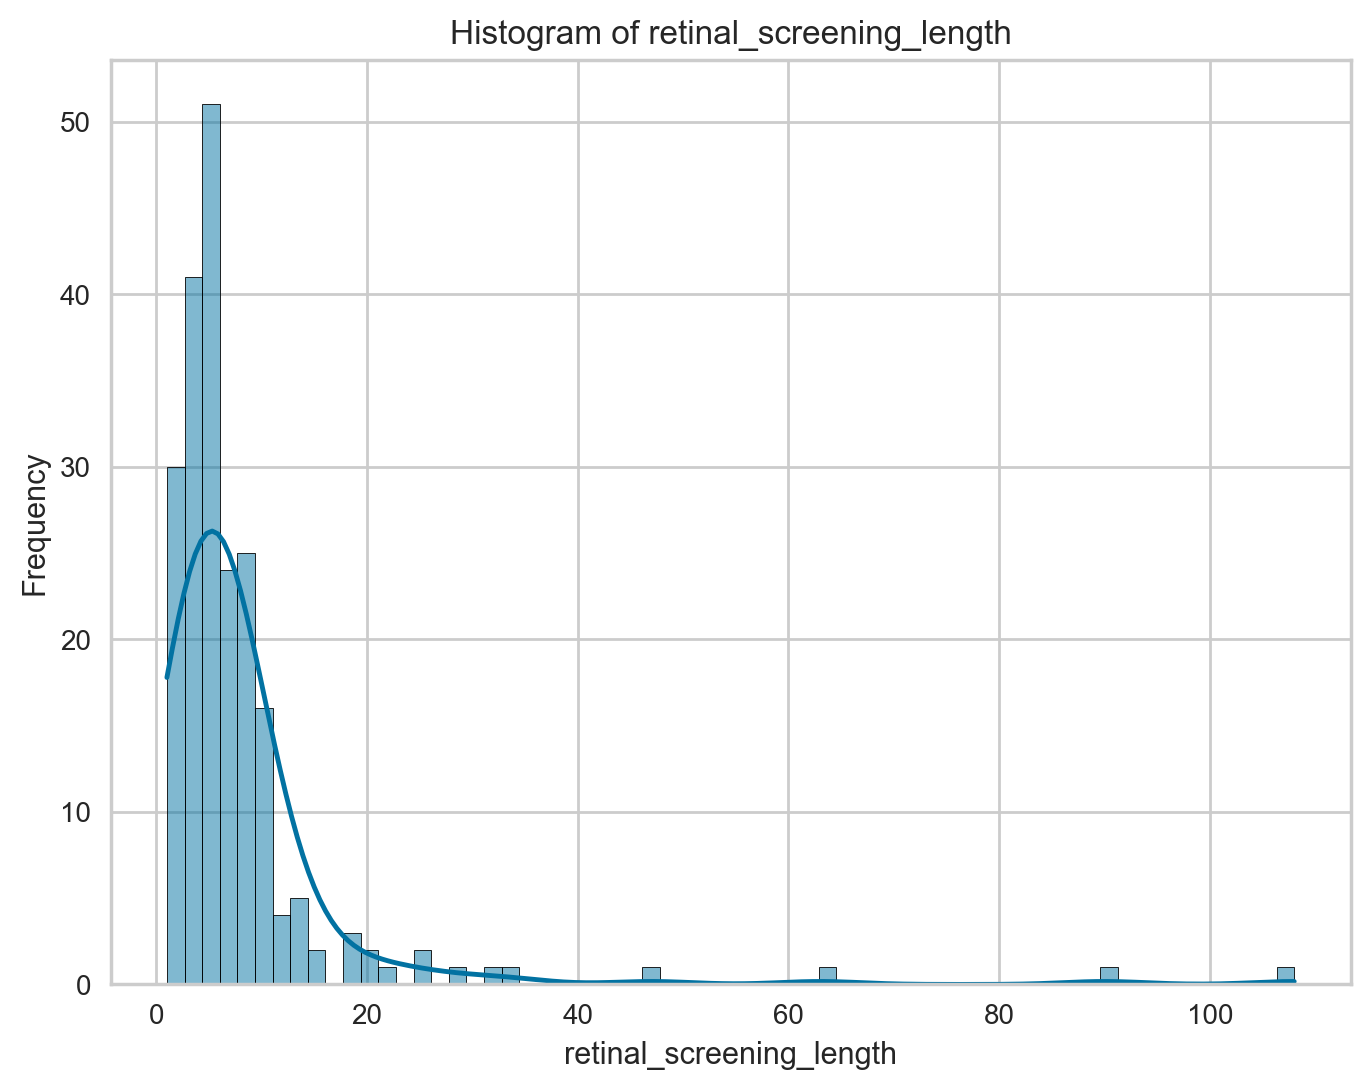

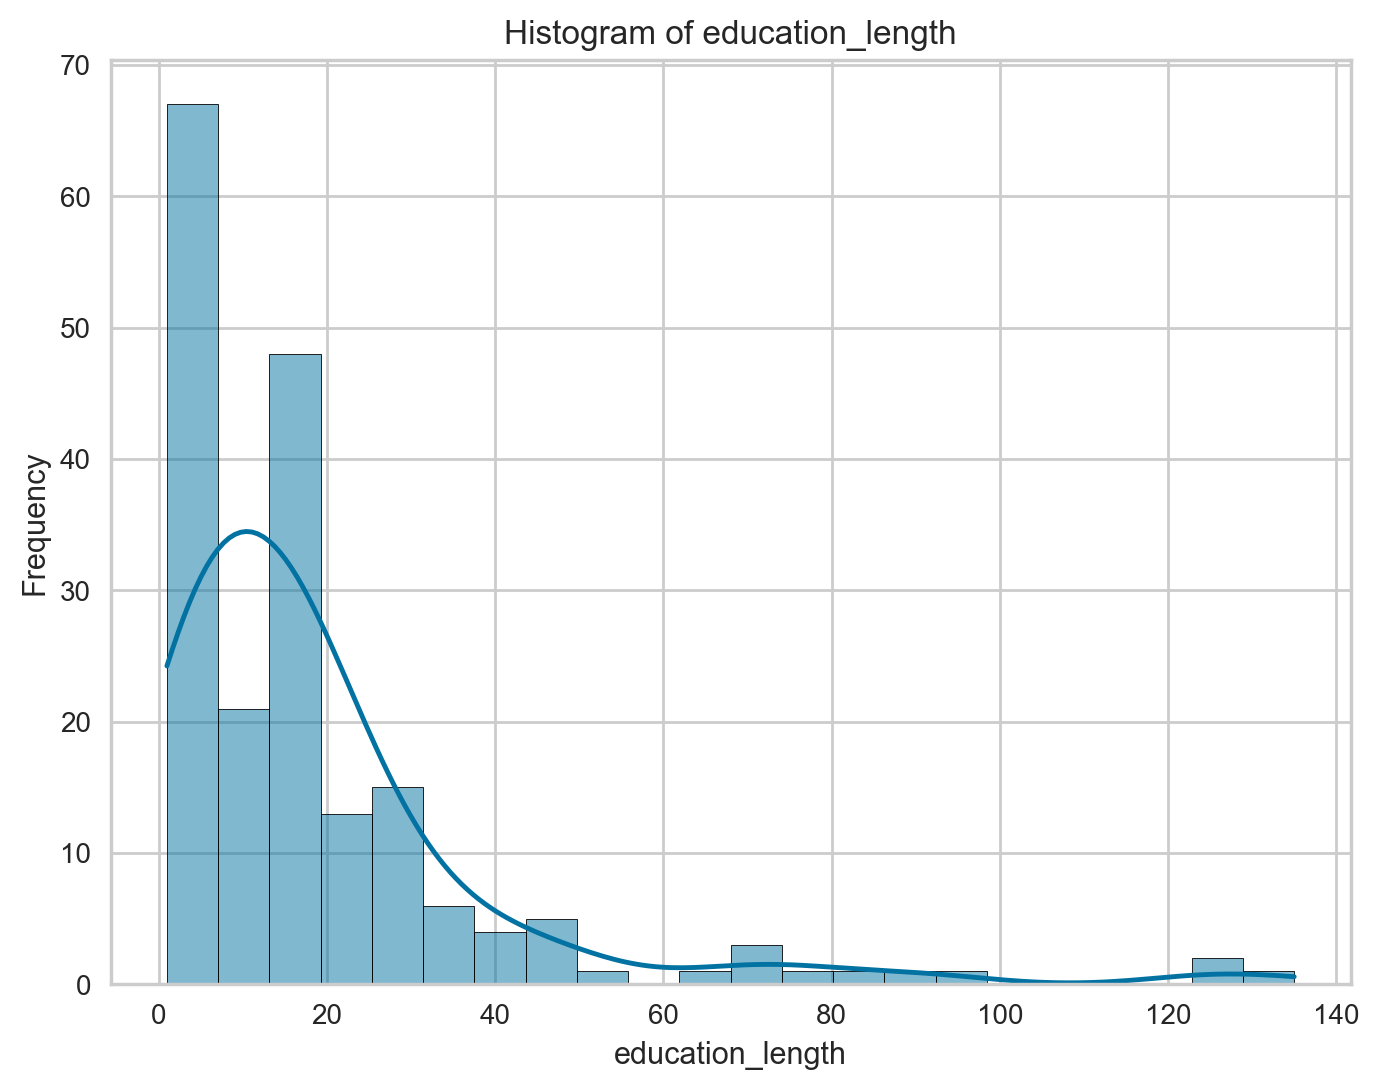

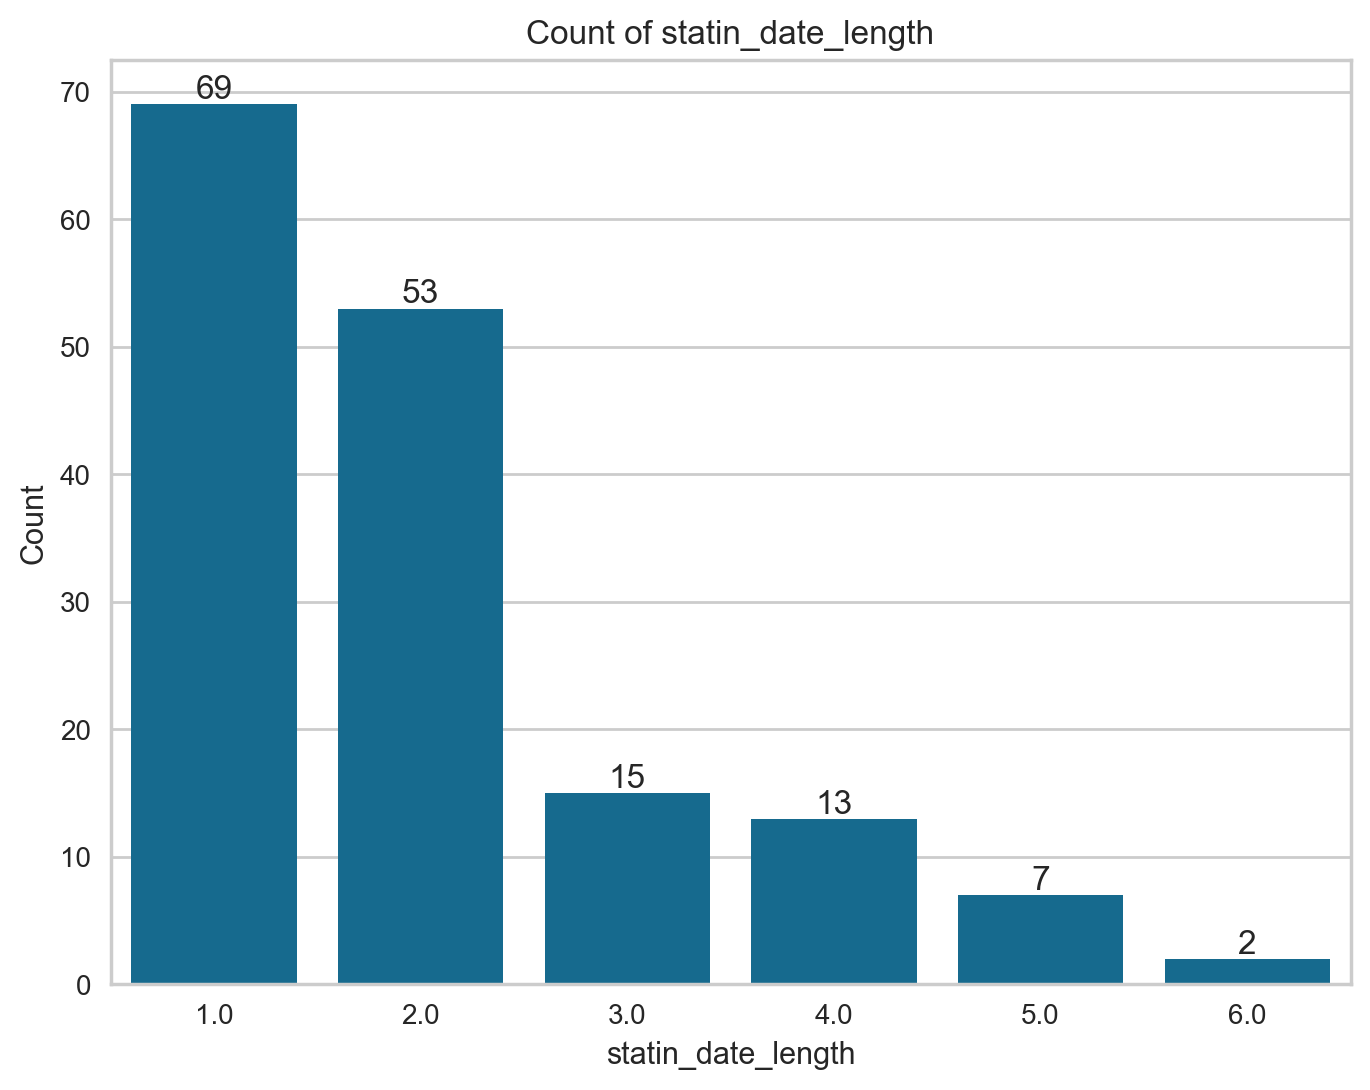

In [77]:
univariate_analysis(data)

In [78]:
eda2()

In [80]:
data.columns

Index(['nhs_number', 'imd_decile', 'bame', 'diabetes_diagnosis', 'hba1c_value',
       'sbp', 'dbp', 'total_chol', 'non-hdl_chol', 'latest_hdl', 'latest_ldl',
       'latest_egfr', 'latest_bmi', 'latest_qrisk2', 'statin', 'column1',
       'column2', 'column3', 'column4', 'column5', 'column6', 'column7',
       'column8', 'column9', 'metformin', 'sulphonylurea', 'dpp4', 'sglt2',
       'pioglitazone', 'glp-1', 'basal_/_mix_insulin', 'rapid_acting_insulin',
       'acei/arb', 'calcium_channel_blocker', 'diuretic', 'beta_blocker',
       'spironolactone', 'doxazosin', 'age', 'lenght_of_diagnosis_months',
       'annual_review_done_length', 'hba1c_length', 'cholesterol_length',
       'bmi_length', 'egfr_length', 'urine_acr_length', 'smoking_length',
       'foot_risk_length', 'retinal_screening_length', 'education_length',
       'statin_date_length'],
      dtype='object')

In [81]:
data.dropna()

nhs_number  imd_decile bame          diabetes_diagnosis  hba1c_value  \
9    7194443260           6  Yes                      Type 2           59   
11   6345351261           2  Yes                      Type 2           49   
12   6354633657           3  Yes                      Type 2           46   
22   6291208172           2  Yes                      Type 2           70   
29   6285025568           4  Yes                      Type 2          108   
33   6261314608           3  Yes                      Type 2           54   
38   7034267782           1   No                      Type 2           42   
45   6341061862           3  Yes                      Type 2           53   
50   6307240857           2  Yes  Both Types - Latest Type 2           75   
69   6301298756           4  Yes                      Type 2           51   
75   6282128056           5  Yes                      Type 2           54   
76   6355019162           1  Yes                      Type 2           63   
77   6288567361           2  Yes                      Type 2           70   
79   6303668313           2  Yes                      Type 2           45   
81   4201812219           3   No                      Type 2           41   
87   6282331307           4  Yes                      Type 2           43   
88   6269413931           1  Yes                      Type 2           58   
128  7105637447           2  Yes                      Type 2           40   
132  7225876910           6  Yes                      Type 2           56   
137  6398436369           5   No                      Type 2           50   
139  6487753076           2  Yes  Both Types - Latest Type 1           54   
143  6310659421           6   No                      Type 2           83   
148  6393843063           4   No                      Type 2           46   
149  6344982403           6  Yes                      Type 2           44   
155  6282482518           2  Yes                      Type 2           81   
163  6281721209           2  Yes                      Type 2           97   
164  6301634691           3  Yes                      Type 2           43   
175  6304486855           4   No  Both Types - Latest Type 2           73   
183  7133900041           3   No                      Type 2           44   
188  6307401079           3  Yes                      Type 2           52   
209  6269148707           4  Yes                      Type 2            0   

     sbp  dbp  total_chol  non-hdl_chol  latest_hdl  latest_ldl  latest_egfr  \
9    130   76         4.3           3.0         1.3         2.5           90   
11   111   81         4.4           2.7         0.8         1.8           90   
12   126   87         2.9           2.0         0.9         1.7           85   
22   119   70         4.1           4.1         1.4         3.4           73   
29   145   76         4.1           2.6         1.5         1.7           31   
33   140   82         3.8           3.1         1.1         2.5           79   
38   130   83         6.7           5.6         1.1         4.8           90   
45   113   66         4.0           3.2         0.8         1.9           90   
50   110   62         4.1           2.8         1.3         2.1           89   
69   122   89         4.6           2.8         1.8         2.1           90   
75   100   60         2.9           1.8         1.1         1.5           52   
76   126   76         3.4           2.4         1.0         1.9           90   
77   115   56         3.4           3.1         1.3         2.4           62   
79   123   83         7.6           6.4         1.2         5.6           66   
81   130   70         4.0           2.7         1.3         1.9           44   
87   137   84         6.5           5.2         1.3         3.9           90   
88   126   74         4.5           2.7         1.8         2.3           88   
128  111   70         6.0           4.3         1.7         3.9           90   
132  135   71       

In [82]:
data.shape

(215, 51)

In [83]:
data.isna().sum()

nhs_number                      0
imd_decile                      0
bame                            0
diabetes_diagnosis              0
hba1c_value                     0
sbp                             0
dbp                             0
total_chol                      0
non-hdl_chol                    1
latest_hdl                      0
latest_ldl                      0
latest_egfr                     0
latest_bmi                      0
latest_qrisk2                 116
statin                         56
column1                         1
column2                         6
column3                        11
column4                        16
column5                        23
column6                        32
column7                        44
column8                        52
column9                        66
metformin                       0
sulphonylurea                   0
dpp4                            0
sglt2                           0
pioglitazone                    0
glp-1         

In [84]:
def statin_strength_map():
    """
    Returns a dictionary mapping statins to an integer scale, where 1 is the strongest.
    """
    return {
        "rosuvastatin_40mg": 1,
        "rosuvastatin_20mg": 2,
        "rosuvastatin_10mg": 3,
        "rosuvastatin_5mg": 4,
        "atorvastatin_80mg": 5,
        "atorvastatin_40mg": 6,
        "atorvastatin_20mg": 7,
        "atorvastatin_10mg": 8,
        "simvastatin_80mg": 9,
        "simvastatin_40mg": 10,
        "simvastatin_20mg": 11,
        "pravastatin_40mg": 12,
        "pravastatin_20mg": 13,
        "pravastatin_10mg": 14,
    }

# Example usage
data['statin_strenght'] = data['statin'].map(statin_strength_map())

In [85]:
data.head()

nhs_number  imd_decile bame diabetes_diagnosis  hba1c_value  sbp  dbp  \
0  6264571857           6  Yes             Type 2           54  110   74   
1  6379538607           3  Yes             Type 1           96  120   67   
2  7076549352           6   NK             Type 2           48  135   82   
3  6270913543           1  Yes             Type 2           44  124   76   
4  6379661395           5  Yes             Type 2           65  130   75   

   total_chol  non-hdl_chol  latest_hdl  latest_ldl  latest_egfr  latest_bmi  \
0         2.5           1.8         0.7         1.2           85        22.2   
1         5.2           4.0         1.2         3.5           90        28.7   
2         5.4           4.2         1.2         3.4           82        32.4   
3         5.9           4.8         1.1         3.4           90        27.1   
4         2.7           1.7         1.0         1.3           90        27.7   

  latest_qrisk2                     statin  column1  column2  column3  \
0           NaN  Atorvastatin 20mg tablets     54.0     49.0     50.0   
1           NaN  Atorvastatin 20mg tablets     96.0     97.0     67.0   
2           NaN  Atorvastatin 80mg tablets     48.0     46.0     50.0   
3         17.8%  Atorvastatin 40mg tablets     44.0     47.0     44.0   
4           NaN  Atorvastatin 40mg tablets     65.0     60.0     62.0   

   column4  column5  column6  column7  column8  column9  metformin  \
0     48.0     45.0     43.0     56.0     59.0     55.0          1   
1     71.0     57.0     99.0     99.0     79.0    105.0          1   
2     68.0    116.0    108.0    108.0     53.0     55.0          1   
3     44.0     39.0     42.0     71.0     55.0     71.0          1   
4     59.0     64.0     80.0     77.0     68.0      0.0          1   

   sulphonylurea  dpp4  sglt2  pioglitazone  glp-1  basal_/_mix_insulin  \
0              0     0      1             0      0                    1   
1              0     0      0             0      0                    1   
2              0     1      0             0      0                    0   
3              0     0      0             0      0                    0   
4              1     0      1             0      0                    0   

   rapid_acting_insulin  acei/arb  calcium_channel_blocker  diuretic  \
0                     0         1                        0         0   
1                     1         0                        0         0   
2                     0         1                        1         1   
3                     0         1                        1         0   
4                     0         0                        0         0   

   beta_blocker  spironolactone  doxazosin  age  lenght_of_diagnosis_months  \
0             1               1          1   74                       192.0   
1             0               0          0   38                         NaN   
2             1               0          0   84                         NaN   
3             0               0          1   58                         NaN   
4             0               0          0   56                       136.0   

   annual_review_done_length  hba1c_length  cholesterol_length  bmi_length  \
0                        7.0           2.0                   2         1.0   
1                        7.0           1.0                   1         1.0   
2                        6.0           8.0                   8         6.0   
3                        6.0           6.0                   6         6.0   
4                        5.0           7.0                   7         5.0   

   egfr_length  urine_acr_length  smoking_length  foot_risk_length  \
0            2               2.0             1.0               7.0   
1            1               1.0             1.0               8.0   
2            8               8.0             6.0               6.0   
3            6               6.0             6.0               6.0   
4            7             

In [86]:
data = label_encode_column(data, 'bame')

In [87]:
data = label_encode_column(data, 'diabetes_diagnosis')

In [96]:
data['latest_qrisk2'] = data['latest_qrisk2'].str.replace("%", "").astype(float)

In [89]:
data.drop(columns=["statin", "bame"], inplace=True)

In [90]:
data.head()

nhs_number  imd_decile  hba1c_value  sbp  dbp  total_chol  non-hdl_chol  \
0  6264571857           6           54  110   74         2.5           1.8   
1  6379538607           3           96  120   67         5.2           4.0   
2  7076549352           6           48  135   82         5.4           4.2   
3  6270913543           1           44  124   76         5.9           4.8   
4  6379661395           5           65  130   75         2.7           1.7   

   latest_hdl  latest_ldl  latest_egfr  latest_bmi latest_qrisk2  column1  \
0         0.7         1.2           85        22.2           NaN     54.0   
1         1.2         3.5           90        28.7           NaN     96.0   
2         1.2         3.4           82        32.4           NaN     48.0   
3         1.1         3.4           90        27.1          17.8     44.0   
4         1.0         1.3           90        27.7           NaN     65.0   

   column2  column3  column4  column5  column6  column7  column8  column9  \
0     49.0     50.0     48.0     45.0     43.0     56.0     59.0     55.0   
1     97.0     67.0     71.0     57.0     99.0     99.0     79.0    105.0   
2     46.0     50.0     68.0    116.0    108.0    108.0     53.0     55.0   
3     47.0     44.0     44.0     39.0     42.0     71.0     55.0     71.0   
4     60.0     62.0     59.0     64.0     80.0     77.0     68.0      0.0   

   metformin  sulphonylurea  dpp4  sglt2  pioglitazone  glp-1  \
0          1              0     0      1             0      0   
1          1              0     0      0             0      0   
2          1              0     1      0             0      0   
3          1              0     0      0             0      0   
4          1              1     0      1             0      0   

   basal_/_mix_insulin  rapid_acting_insulin  acei/arb  \
0                    1                     0         1   
1                    1                     1         0   
2                    0                     0         1   
3                    0                     0         1   
4                    0                     0         0   

   calcium_channel_blocker  diuretic  beta_blocker  spironolactone  doxazosin  \
0                        0         0             1               1          1   
1                        0         0             0               0          0   
2                        1         1             1               0          0   
3                        1         0             0               0          1   
4                        0         0             0               0          0   

   age  lenght_of_diagnosis_months  annual_review_done_length  hba1c_length  \
0   74                       192.0                        7.0           2.0   
1   38                         NaN                        7.0           1.0   
2   84                         NaN                        6.0           8.0   
3   58                         NaN                        6.0           6.0   
4   56                       136.0                        5.0           7.0   

   cholesterol_length  bmi_length  egfr_length  urine_acr_length  \
0                   2         1.0            2               2.0   
1                   1         1.0            1               1.0   
2                   8         6.0            8               8.0   
3                   6         6.0            6               6.0   
4                   7         5.0            7               7.0   

   smoking_length  foot_risk_length  retinal_screening_length  \
0             1.0               7.0                       2.0   
1             1.0               8.0                       8.0   
2             6.0               6.0                      21.0   
3             6.0               6.0                      10.0   
4             5.0               5.0                       7.0   

   education_length  statin_date_length  statin_strenght  diabetes_diagnosis  
0               7.0        

IndexError: index 0 is out of bounds for axis 0 with size 0

IndexError: index 0 is out of bounds for axis 0 with size 0

In [99]:
df_imputed

IndexError: index 0 is out of bounds for axis 0 with size 0

IndexError: index 0 is out of bounds for axis 0 with size 0

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   nhs_number                  215 non-null    Int64  
 1   imd_decile                  215 non-null    int64  
 2   hba1c_value                 215 non-null    int64  
 3   sbp                         215 non-null    int64  
 4   dbp                         215 non-null    int64  
 5   total_chol                  215 non-null    float64
 6   non-hdl_chol                214 non-null    float64
 7   latest_hdl                  215 non-null    float64
 8   latest_ldl                  215 non-null    float64
 9   latest_egfr                 215 non-null    int64  
 10  latest_bmi                  215 non-null    float64
 11  latest_qrisk2               99 non-null     float64
 12  column1                     214 non-null    float64
 13  column2                     209 non

In [101]:
data.isna().sum()

nhs_number                      0
imd_decile                      0
hba1c_value                     0
sbp                             0
dbp                             0
total_chol                      0
non-hdl_chol                    1
latest_hdl                      0
latest_ldl                      0
latest_egfr                     0
latest_bmi                      0
latest_qrisk2                 116
column1                         1
column2                         6
column3                        11
column4                        16
column5                        23
column6                        32
column7                        44
column8                        52
column9                        66
metformin                       0
sulphonylurea                   0
dpp4                            0
sglt2                           0
pioglitazone                    0
glp-1                           0
basal_/_mix_insulin             0
rapid_acting_insulin            0
acei/arb      

In [105]:
impute_cols = ['non-hdl_chol', 'latest_qrisk2', 'column1', 'column2', 'column3', 'column4', 'column5', 'column6', 'column7', 'column8', 'column9']

In [110]:
data = impute_values(data, missing_values=0, copy=False, strategy='mean', columns=impute_cols)

In [115]:
non_zero_columns = [
    "annual_review_done_length",
    "hba1c_length",
    "bmi_length",
    "urine_acr_length",
    "smoking_length",
    "foot_risk_length",
    "retinal_screening_length",
    "education_length",
    "statin_date_length",
    "statin_strenght"
]

In [113]:
data = impute_values(data, missing_values=0, copy=False, strategy='mean', columns=non_zero_columns)

ValueError: Columns must be same length as key

In [112]:
missing_cols = [col for col in non_zero_columns if col not in data.columns]
if missing_cols:
    print("Missing columns:", missing_cols)

In [114]:
data.isna().sum()

nhs_number                      0
imd_decile                      0
hba1c_value                     0
sbp                             0
dbp                             0
total_chol                      0
non-hdl_chol                    0
latest_hdl                      0
latest_ldl                      0
latest_egfr                     0
latest_bmi                      0
latest_qrisk2                   0
column1                         0
column2                         0
column3                         0
column4                         0
column5                         0
column6                         0
column7                         0
column8                         0
column9                         0
metformin                       0
sulphonylurea                   0
dpp4                            0
sglt2                           0
pioglitazone                    0
glp-1                           0
basal_/_mix_insulin             0
rapid_acting_insulin            0
acei/arb      

In [116]:
data.drop(columns=non_zero_columns, inplace=True)

In [117]:
data.isna().sum()

nhs_number                     0
imd_decile                     0
hba1c_value                    0
sbp                            0
dbp                            0
total_chol                     0
non-hdl_chol                   0
latest_hdl                     0
latest_ldl                     0
latest_egfr                    0
latest_bmi                     0
latest_qrisk2                  0
column1                        0
column2                        0
column3                        0
column4                        0
column5                        0
column6                        0
column7                        0
column8                        0
column9                        0
metformin                      0
sulphonylurea                  0
dpp4                           0
sglt2                          0
pioglitazone                   0
glp-1                          0
basal_/_mix_insulin            0
rapid_acting_insulin           0
acei/arb                       0
calcium_ch

In [118]:
data = impute_values(data, missing_values=0, copy=False, strategy='mean', columns=["lenght_of_diagnosis_months"])

In [119]:
data.head()

nhs_number  imd_decile  hba1c_value  sbp  dbp  total_chol  non-hdl_chol  \
0  6264571857           6           54  110   74         2.5           1.8   
1  6379538607           3           96  120   67         5.2           4.0   
2  7076549352           6           48  135   82         5.4           4.2   
3  6270913543           1           44  124   76         5.9           4.8   
4  6379661395           5           65  130   75         2.7           1.7   

   latest_hdl  latest_ldl  latest_egfr  latest_bmi  latest_qrisk2  column1  \
0         0.7         1.2           85        22.2      17.790909     54.0   
1         1.2         3.5           90        28.7      17.790909     96.0   
2         1.2         3.4           82        32.4      17.790909     48.0   
3         1.1         3.4           90        27.1      17.800000     44.0   
4         1.0         1.3           90        27.7      17.790909     65.0   

   column2  column3  column4  column5  column6  column7  column8     column9  \
0     49.0     50.0     48.0     45.0     43.0     56.0     59.0   55.000000   
1     97.0     67.0     71.0     57.0     99.0     99.0     79.0  105.000000   
2     46.0     50.0     68.0    116.0    108.0    108.0     53.0   55.000000   
3     47.0     44.0     44.0     39.0     42.0     71.0     55.0   71.000000   
4     60.0     62.0     59.0     64.0     80.0     77.0     68.0   59.013699   

   metformin  sulphonylurea  dpp4  sglt2  pioglitazone  glp-1  \
0          1              0     0      1             0      0   
1          1              0     0      0             0      0   
2          1              0     1      0             0      0   
3          1              0     0      0             0      0   
4          1              1     0      1             0      0   

   basal_/_mix_insulin  rapid_acting_insulin  acei/arb  \
0                    1                     0         1   
1                    1                     1         0   
2                    0                     0         1   
3                    0                     0         1   
4                    0                     0         0   

   calcium_channel_blocker  diuretic  beta_blocker  spironolactone  doxazosin  \
0                        0         0             1               1          1   
1                        0         0             0               0          0   
2                        1         1             1               0          0   
3                        1         0             0               0          1   
4                        0         0             0               0          0   

   age  lenght_of_diagnosis_months  cholesterol_length  egfr_length  \
0   74                  192.000000                   2            2   
1   38                  122.983871                   1            1   
2   84                  122.983871                   8            8   
3   58                  122.983871                   6            6   
4   56                  136.000000                   7            7   

   diabetes_diagnosis  
0                   3  
1                   2  
2                   3  
3                   3  
4                   3

In [122]:
X, y = define_X_y(data, "hba1c_value")

X - independant variables - (215, 39)
y - dependant variable - hba1c_value: (215,)


In [123]:
eda2()

In [124]:
X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.2, random_state=42)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (172, 39), (172,)
 Test Set:  X_test, y_test - (43, 39), (43,)


💾 Scaler saved to: scaler_StandardScaler_2024-11-07_22-50-50.pkl
✅ scaled_X_train: fit_transform StandardScaler - (172, 39)
✅ scaled_X_test: transform StandardScaler - (43, 39)


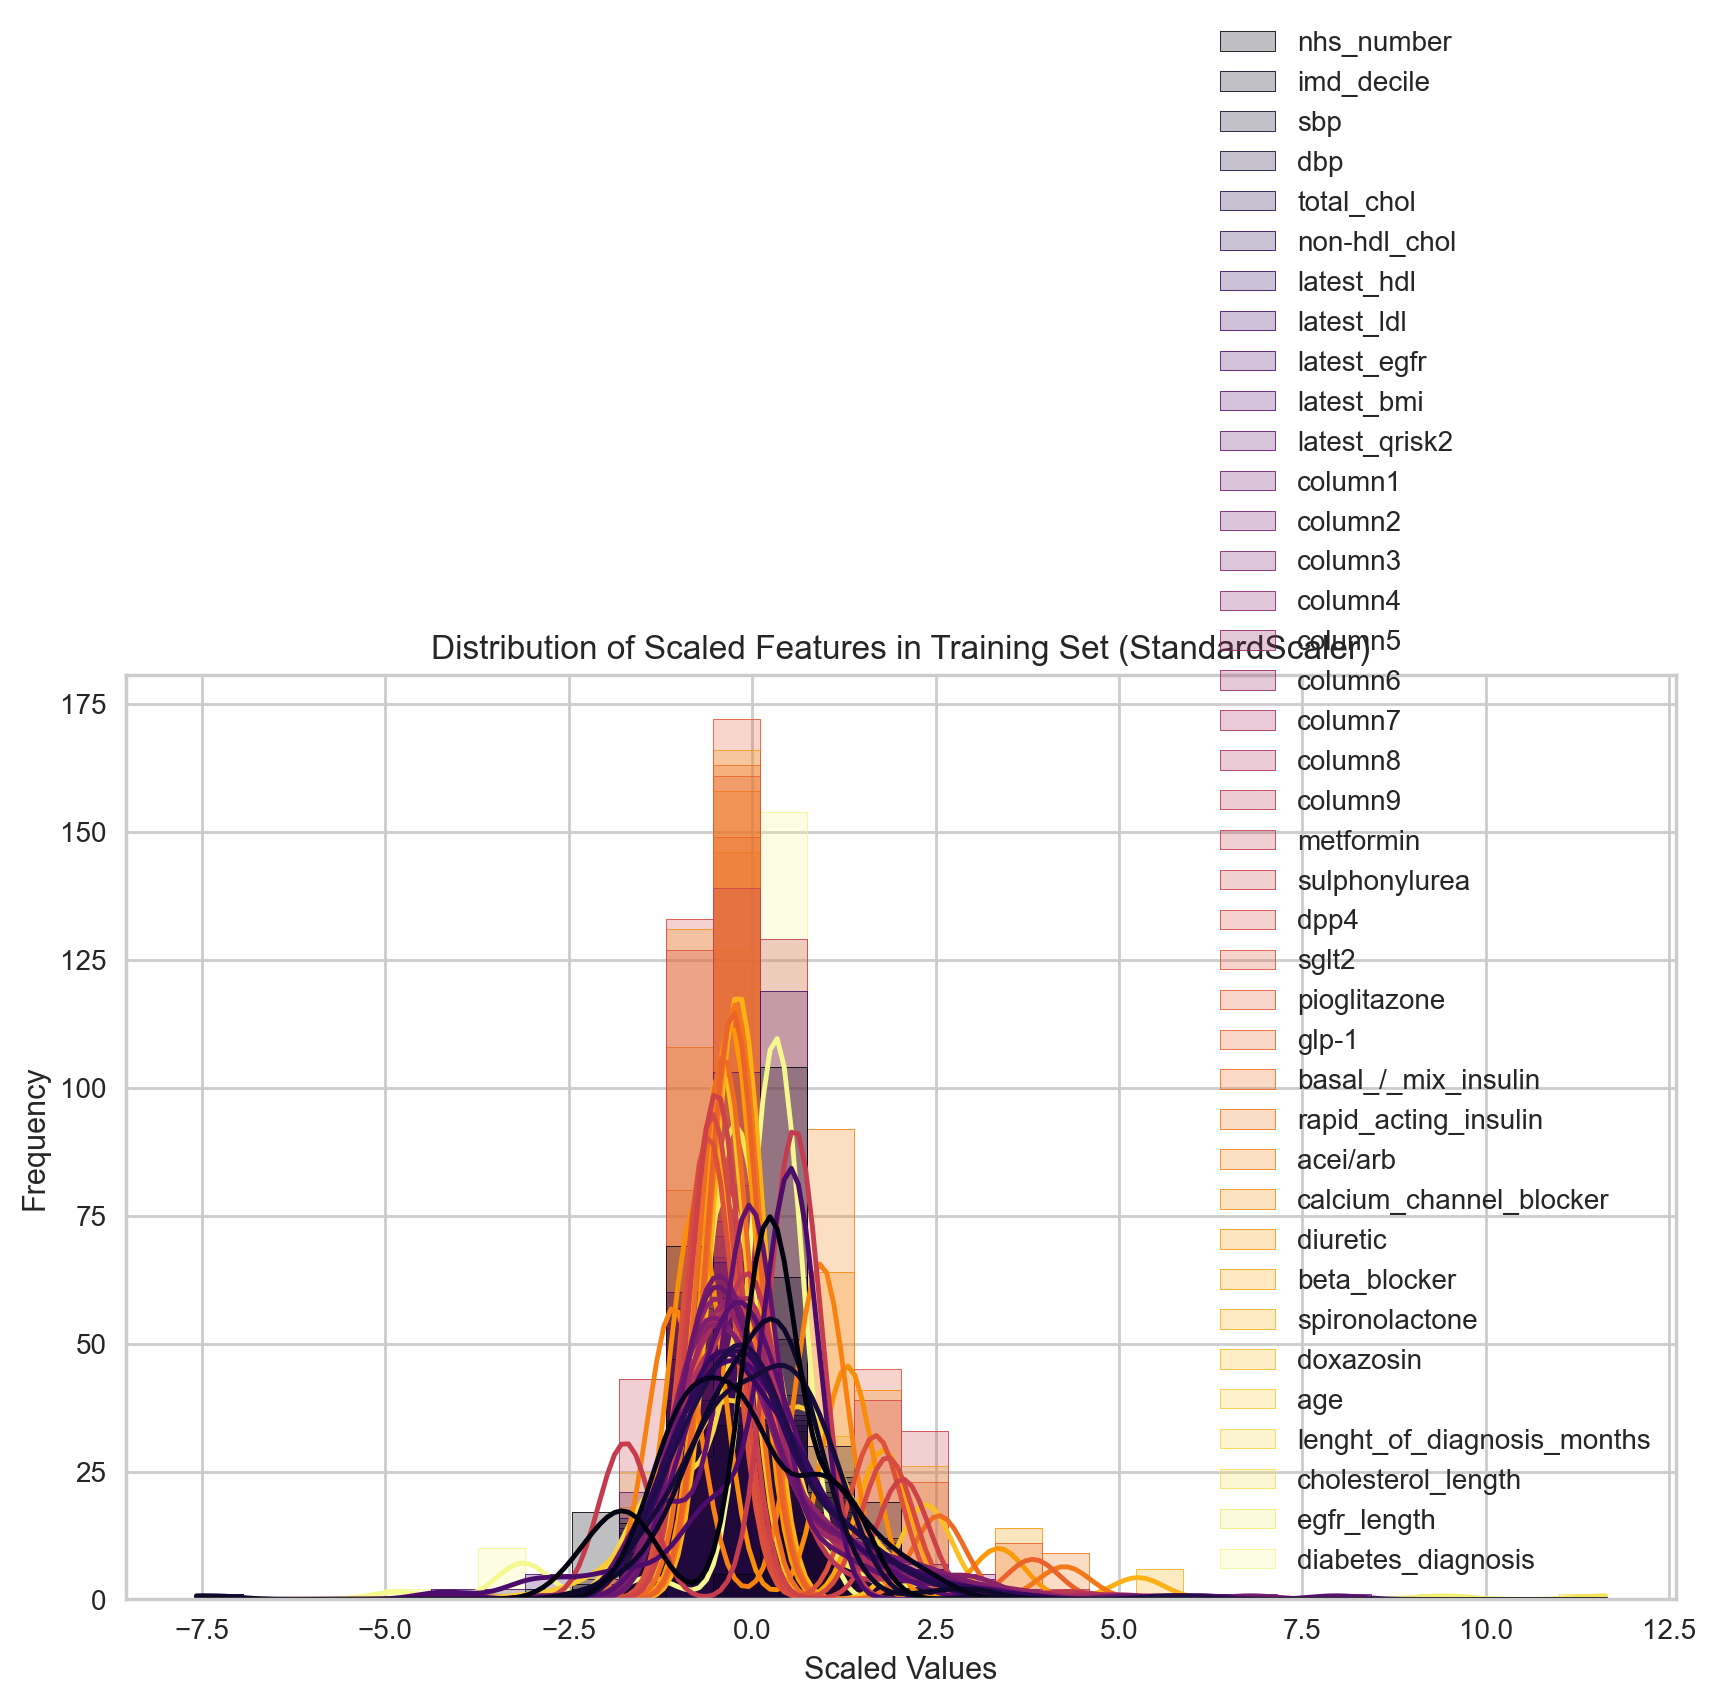

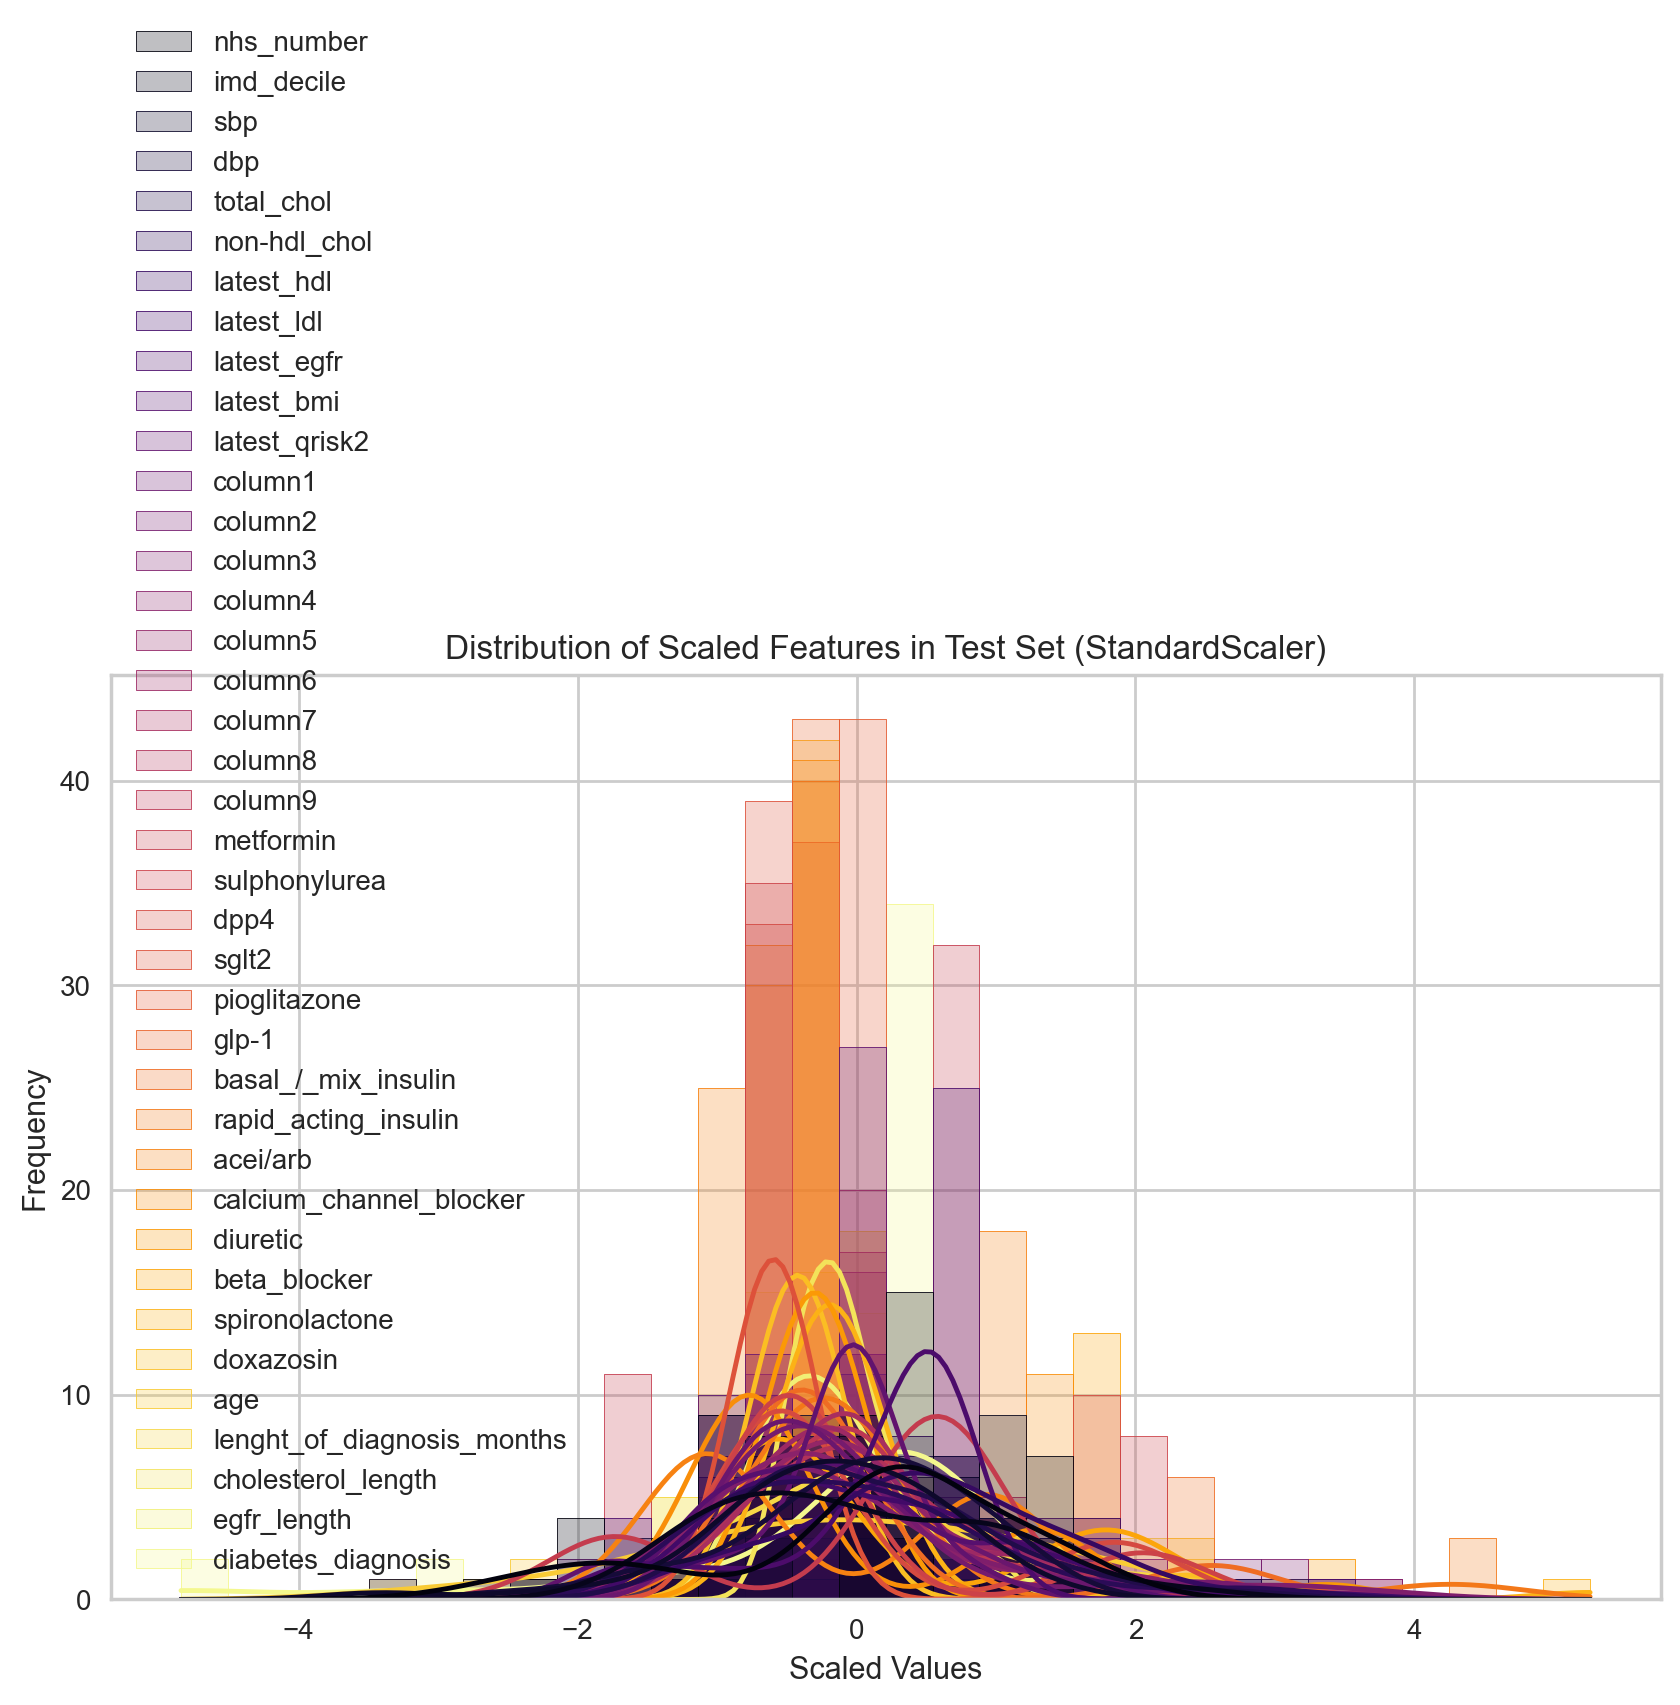

In [125]:
scaled_X_train, scaled_X_test = scale_X_train_X_test(X_train, X_test, scaler="standard", save_scaler=True)

In [127]:
from data_preprocessing.model_selection import *

In [128]:
ml0()

In [131]:
test_regression_models(X, y, test_size=0.2, random_state=None, scale_data=True)

Testing Models: 100%|██████████████████████████████████████████████| 12/12 [00:00<00:00, 16.70it/s]


Model  R² Score          MSE       RMSE        MAE
0          Gradient Boosting  0.946017    23.750842   4.873484   2.014545
1              Random Forest  0.909174    39.960460   6.321429   2.128372
2              Decision Tree  0.876154    54.488372   7.381624   1.837209
3           Ridge Regression  0.826757    76.221323   8.730482   3.424316
4           Lasso Regression  0.825411    76.813813   8.764349   2.075593
5          Linear Regression  0.821276    78.632848   8.867516   3.757339
6                   AdaBoost  0.817069    80.483935   8.971284   3.651585
7      ElasticNet Regression  0.737862   115.332584  10.739301   5.250226
8        K-Nearest Neighbors  0.422322   254.160000  15.942396  10.548837
9              MLP Regressor  0.310700   303.270549  17.414665  10.808572
10  Support Vector Regressor  0.099946   395.995732  19.899642  11.980719
11          Gaussian Process -7.382389  3687.988261  60.728809  56.917764

Mean Absolute Error (MAE): 1.3396499486252003
Mean Squared Error (MSE): 15.044227967192768
Root Mean Squared Error (RMSE): 3.878688949528277
R-squared (R2): 0.9403950889648727


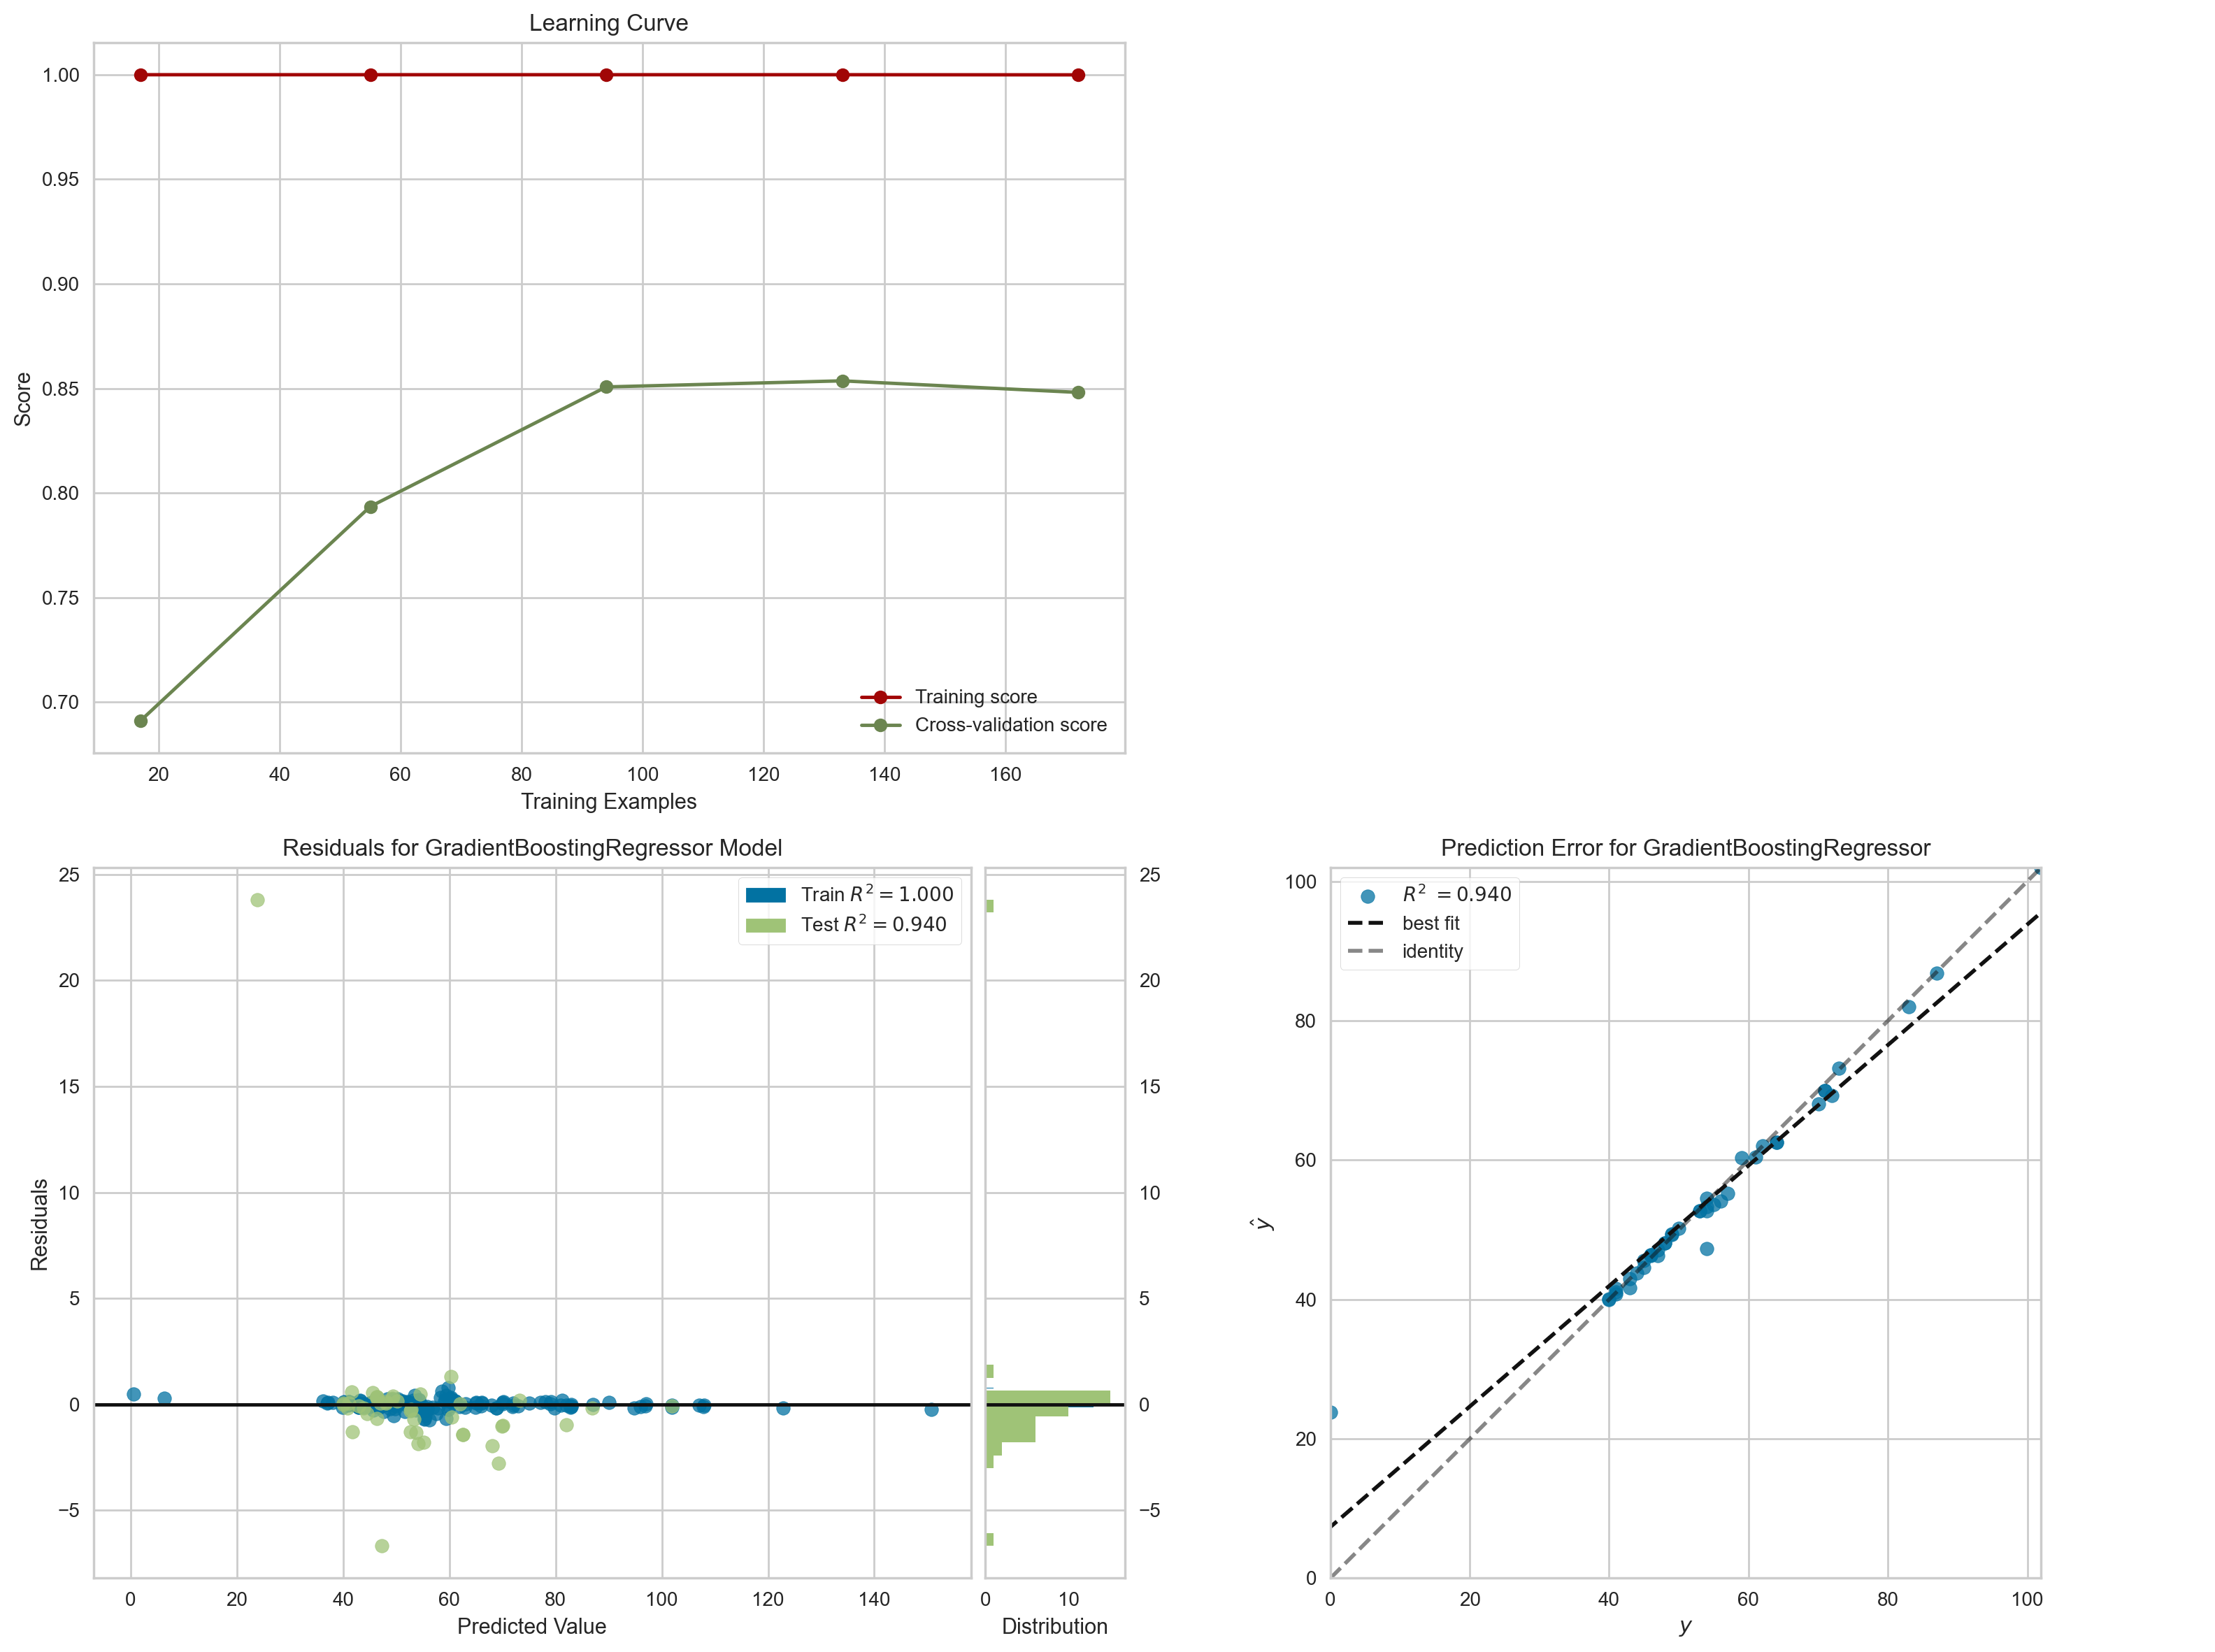

In [133]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model = GradientBoostingRegressor(random_state=42)

evaluate_regression_model(model, X, y)

In [134]:
# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 15.044227967192768
R² Score: 0.9403950889648727


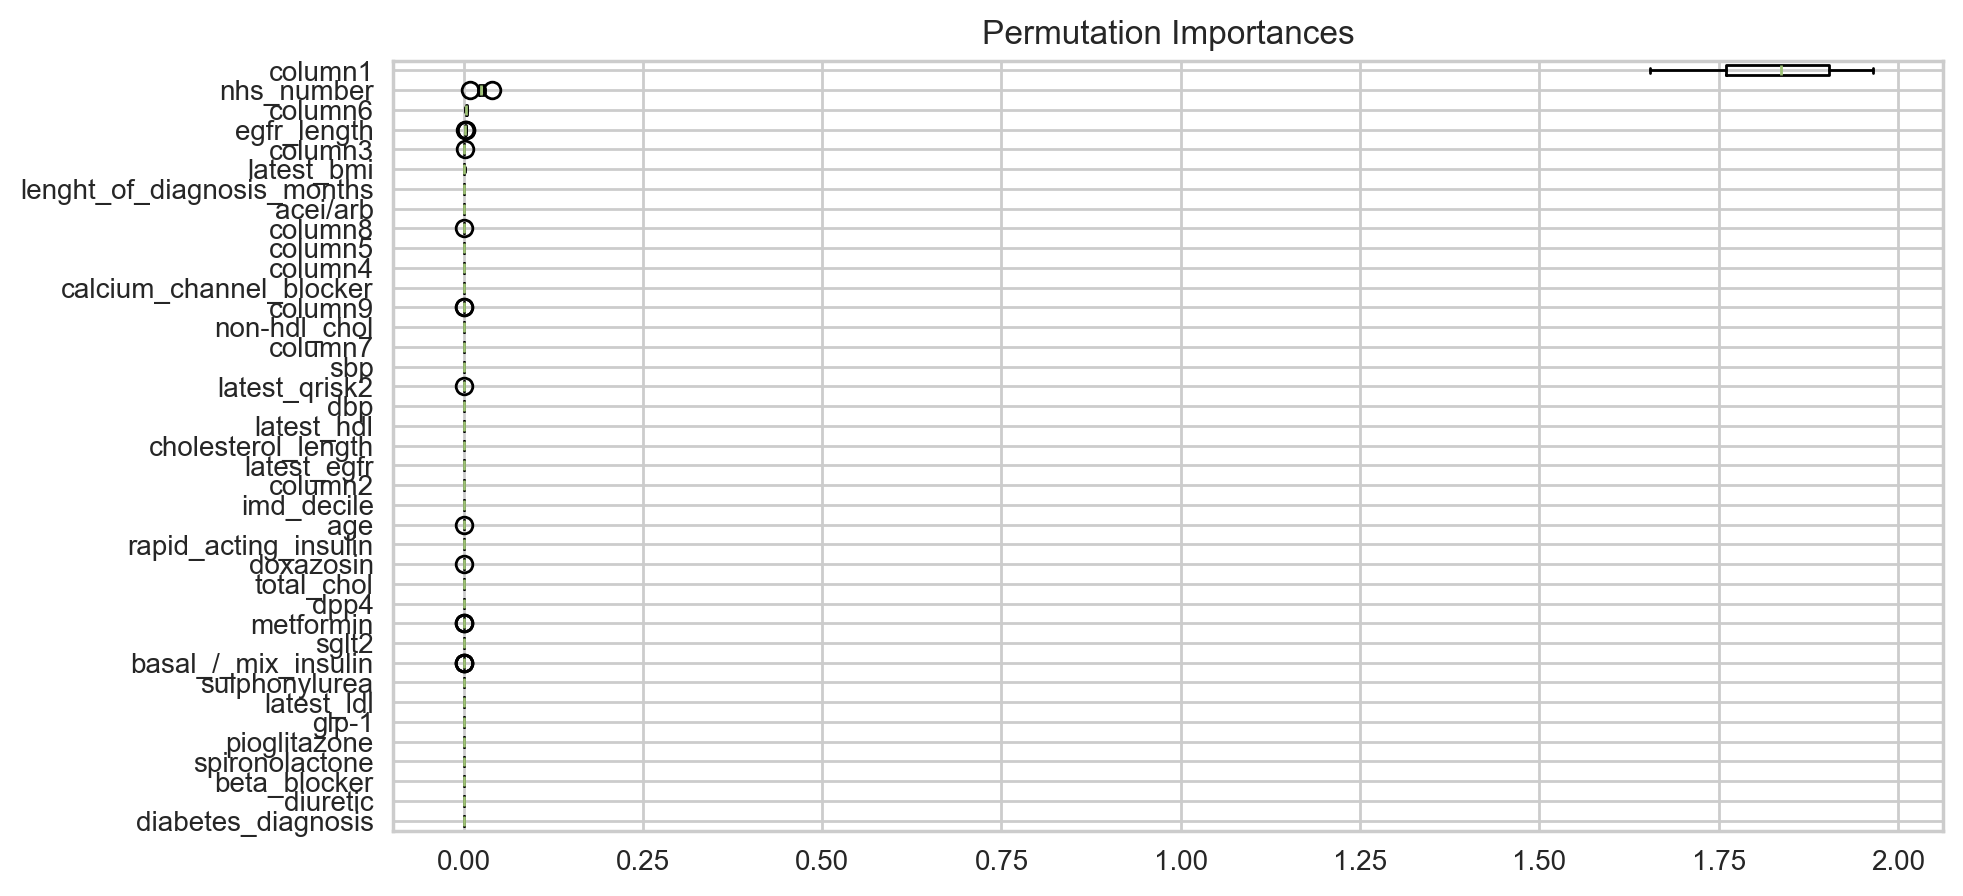

In [135]:
feature_importance_plot(model, X, y)